In [2]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

from typing import Any


def get_before_after_sums(
    dates: dict[datetime, int], vertical_line: datetime
) -> dict[str, int]:
    before = sum(value for date, value in dates.items() if date < vertical_line)
    after = sum(value for date, value in dates.items() if date >= vertical_line)
    return {"before": before, "after": after}

In [3]:
# CONSTANTS
POJISTOVNA = "cpzp"
VAX_PERIOD_IN_DAYS = 30
PRESCRIPTION_PERIOD_IN_DAYS = 364 / 2


# VARIABLES
vax_dates_map: dict[AgeCohort, dict[int, list[datetime]]] = defaultdict(dict)
max_vax_dates_map: dict[AgeCohort, dict[int, datetime]] = defaultdict(dict)

nov_vax_ppl_predpisy_map: dict[AgeCohort, dict[datetime, int]] = defaultdict(dict)
nov_vax_ppl_prvopredpisy_map: dict[AgeCohort, dict[datetime, int]] = defaultdict(dict)
def nested_defaultdict():
    return defaultdict(lambda: defaultdict(int))

prvopredpisy_map = defaultdict(nested_defaultdict)
predpisy_map = defaultdict(nested_defaultdict)
prednison_equivs_map = defaultdict(nested_defaultdict)

In [4]:
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

In [5]:
# === MAX VAXINATION DATES BY COHORT ===
for person in persons:
    if person.died_at or not person.vaccines:
        continue
    for vax in person.vaccines:
        if vax.dose_number not in vax_dates_map[vax.age_cohort]:
            vax_dates_map[vax.age_cohort][vax.dose_number] = []
        vax_dates_map[vax.age_cohort][vax.dose_number].append(vax.date)


for age_cohort, doses_map in vax_dates_map.items():
    for dose_number, dates in doses_map.items():
        if not dates:
            continue

        max_date, _ = max(Counter(dates).items(), key=lambda x: x[1])
        max_vax_dates_map[age_cohort][dose_number] = max_date

In [11]:
# === NOVAX PEOPLE METRICS ===
for p in persons:
    if p.died_at:
        continue

    if not p.vaccines:
        if not p.prescriptions:
            continue

        first_prescription_date = p.prescriptions[0].date
        if first_prescription_date not in nov_vax_ppl_prvopredpisy_map[p.age_cohort]:
            nov_vax_ppl_prvopredpisy_map[p.age_cohort][first_prescription_date] = 0
        nov_vax_ppl_prvopredpisy_map[p.age_cohort][first_prescription_date] += 1

        for prescription in p.prescriptions:
            if prescription.date not in nov_vax_ppl_predpisy_map[p.age_cohort]:
                nov_vax_ppl_predpisy_map[p.age_cohort][prescription.date] = 0
            nov_vax_ppl_predpisy_map[p.age_cohort][prescription.date] += 1

In [12]:
for p in persons:
    if p.died_at or not p.vaccines:
        continue

    for vax in p.vaccines:
        max_int_date = max_vax_dates_map[vax.age_cohort][vax.dose_number]
        if abs((vax.date - max_int_date).days) > VAX_PERIOD_IN_DAYS:
            continue

        if not p.prescriptions:
            continue

        # === PRESCRIPTIONS ===
        last_prescription_date: datetime = datetime.min.date()
        for prescription in p.prescriptions:
            if (
                abs((prescription.date - max_int_date).days)
                > PRESCRIPTION_PERIOD_IN_DAYS
            ):
                continue

            if (
                prescription.lekova_forma == "Injekční suspenze"
                or prescription.lekova_forma == "Injekční/infuzní roztok"
            ):
                if abs((last_prescription_date - prescription.date).days) < 14:
                    continue
            last_prescription_date = prescription.date

            # === PRESCRIPTIONS COUNT ===
            predpisy_map[vax.age_cohort][vax.dose_number][prescription.date] += 1

            # === PREDNISON EQUIV ===
            if prescription.prednison_equiv is not None:
                prednison_equivs_map[vax.age_cohort][vax.dose_number][
                    prescription.date
                ] += prescription.prednison_equiv

        # === FIRST PRESCRIPTIONS ===
        first_prescription = min(p.prescriptions, key=lambda x: x.date)
        if (
            abs((first_prescription.date - max_int_date).days)
            > PRESCRIPTION_PERIOD_IN_DAYS
        ):
            continue

        prvopredpisy_map[vax.age_cohort][vax.dose_number][first_prescription.date] += 1

print(prvopredpisy_map)

defaultdict(<function nested_defaultdict at 0x7fefc6488220>, {<AgeCohort.MORE_THAN_70: 'more_than_70'>: defaultdict(<function nested_defaultdict.<locals>.<lambda> at 0x7fee51481e40>, {3: defaultdict(<class 'int'>, {datetime.date(2022, 1, 26): 14, datetime.date(2022, 4, 6): 12, datetime.date(2021, 9, 2): 20, datetime.date(2021, 7, 11): 4, datetime.date(2021, 6, 15): 32, datetime.date(2022, 3, 23): 16, datetime.date(2021, 10, 14): 28, datetime.date(2022, 1, 28): 16, datetime.date(2021, 11, 3): 12, datetime.date(2022, 1, 4): 38, datetime.date(2022, 4, 4): 26, datetime.date(2022, 6, 1): 16, datetime.date(2022, 4, 25): 36, datetime.date(2021, 10, 20): 16, datetime.date(2022, 2, 8): 8, datetime.date(2022, 5, 2): 30, datetime.date(2022, 1, 3): 10, datetime.date(2022, 1, 20): 18, datetime.date(2022, 4, 17): 4, datetime.date(2021, 10, 27): 12, datetime.date(2021, 8, 19): 20, datetime.date(2022, 4, 27): 10, datetime.date(2021, 7, 28): 20, datetime.date(2021, 8, 10): 16, datetime.date(2022, 1, 24

In [9]:
class ChartDrawer:
    def draw_chart(
        self,
        vax_dates_map,
        novax_dates_map,
        rozhodne_datum,
        title,
    ):
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        fig.tight_layout(pad=5.0)
        fig.suptitle(title, fontsize=16)

        self.__draw_scatter_plot(
            axes[0, 0],
            list(vax_dates_map.keys()),
            list(vax_dates_map.values()),
            "Očkovaná skupina",
            rozhodne_datum,
        )

        vax_before_after_sums = self.__get_before_after_sums(
            vax_dates_map, rozhodne_datum
        )
        self.__draw_bar_chart(
            axes[0, 1],
            list(vax_before_after_sums.keys()),
            list(vax_before_after_sums.values()),
            "Očkovaná skupina",
        )

        self.__draw_scatter_plot(
            axes[1, 0],
            list(novax_dates_map.keys()),
            list(novax_dates_map.values()),
            "Neočkovaná skupina",
            rozhodne_datum,
        )

        novax_before_after_sums = self.__get_before_after_sums(
            novax_dates_map, rozhodne_datum
        )
        self.__draw_bar_chart(
            axes[1, 1],
            list(novax_before_after_sums.keys()),
            list(novax_before_after_sums.values()),
            "Neočkovaná skupina",
        )

        plt.show()

    def __draw_scatter_plot(self, axes, x_data, y_data, title, rozhodne_datum):
        axes.plot(
            x_data,
            y_data,
            label="Original data",
            alpha=0.7,
            marker="o",
            linestyle="None",
        )
        axes.set_xlabel("Dny kolem max intenzity")
        axes.set_ylabel("Počet předpisů za den")
        axes.axvline(
            x=rozhodne_datum,
            color="green",
            linestyle="--",
            linewidth=2,
            label=f"Rozhodné datum: {rozhodne_datum}",
        )
        axes.set_title(title)
        axes.legend()
        axes.grid(True, alpha=0.3)

    def __draw_bar_chart(self, axes, x_data, y_data, title):
        bars = axes.bar(x_data, y_data, color="skyblue", edgecolor="black")
        axes.set_xlabel("Období před a po max intenzitě")
        axes.set_ylabel("Celkový počet předpisů")
        axes.set_title(title)
        axes.legend()
        axes.grid(True, alpha=0.3)

        percentages = [100, (y_data[1] / y_data[0]) * 100 if y_data[0] != 0 else 0]
        i = 0
        for bar, value in zip(bars, y_data):
            axes.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{value:,} / {percentages[i]:.2f}%",
                ha="center",
                va="bottom",
                fontsize=9,
            )
            i += 1

    def __get_before_after_sums(self, dates_map, rozhodne_datum):
        before_sum = sum(dates_map[date] for date in dates_map if date < rozhodne_datum)
        after_sum = sum(dates_map[date] for date in dates_map if date > rozhodne_datum)
        return {
            "before": before_sum,
            "after": after_sum,
        }

/tmp/ipykernel_39121/1489114346.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


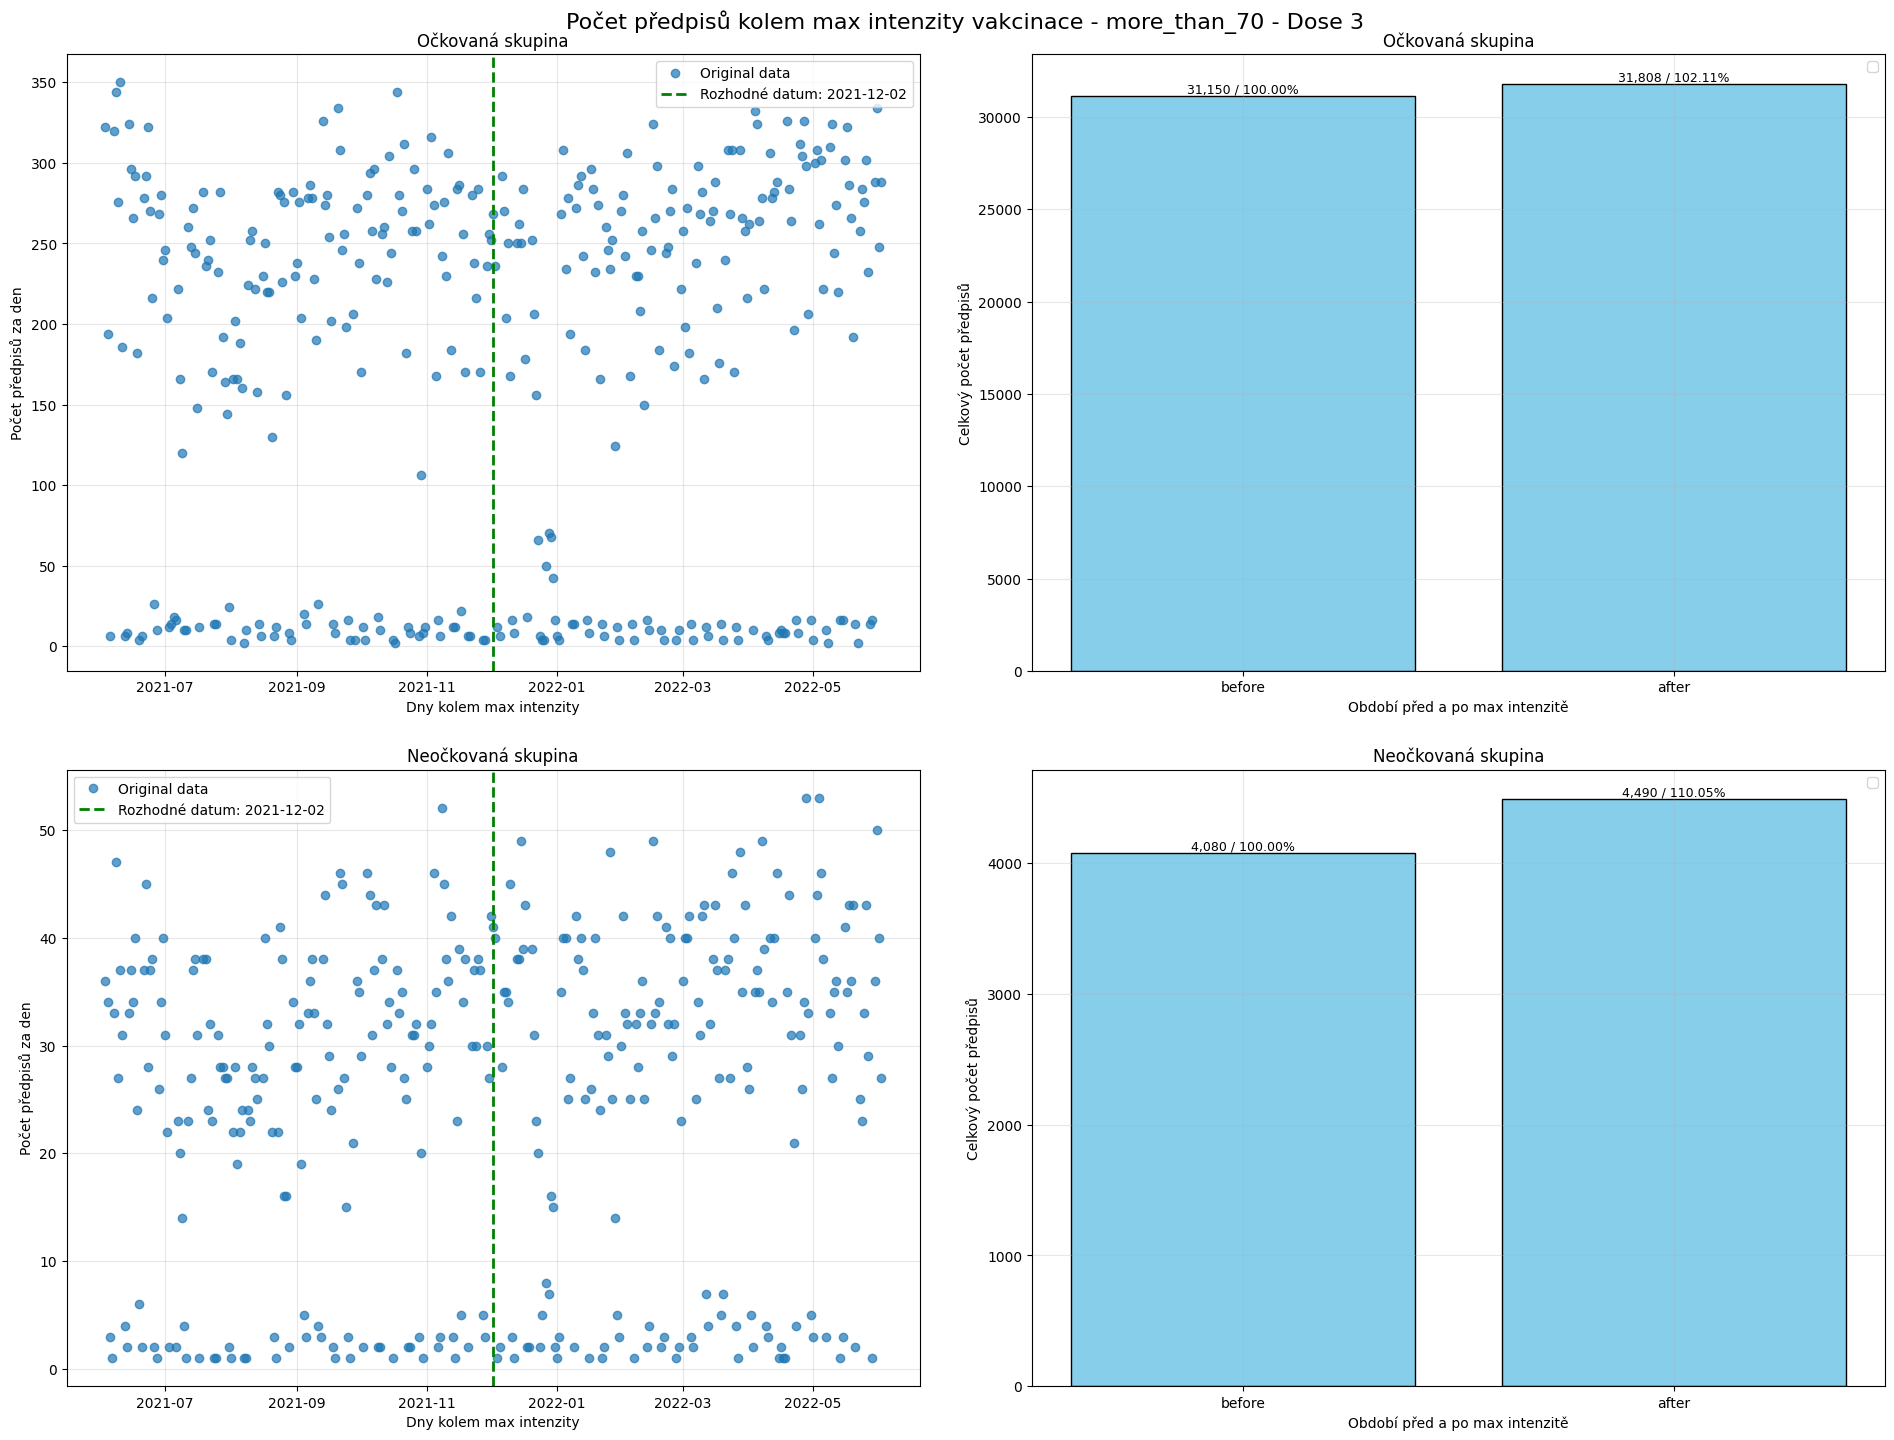

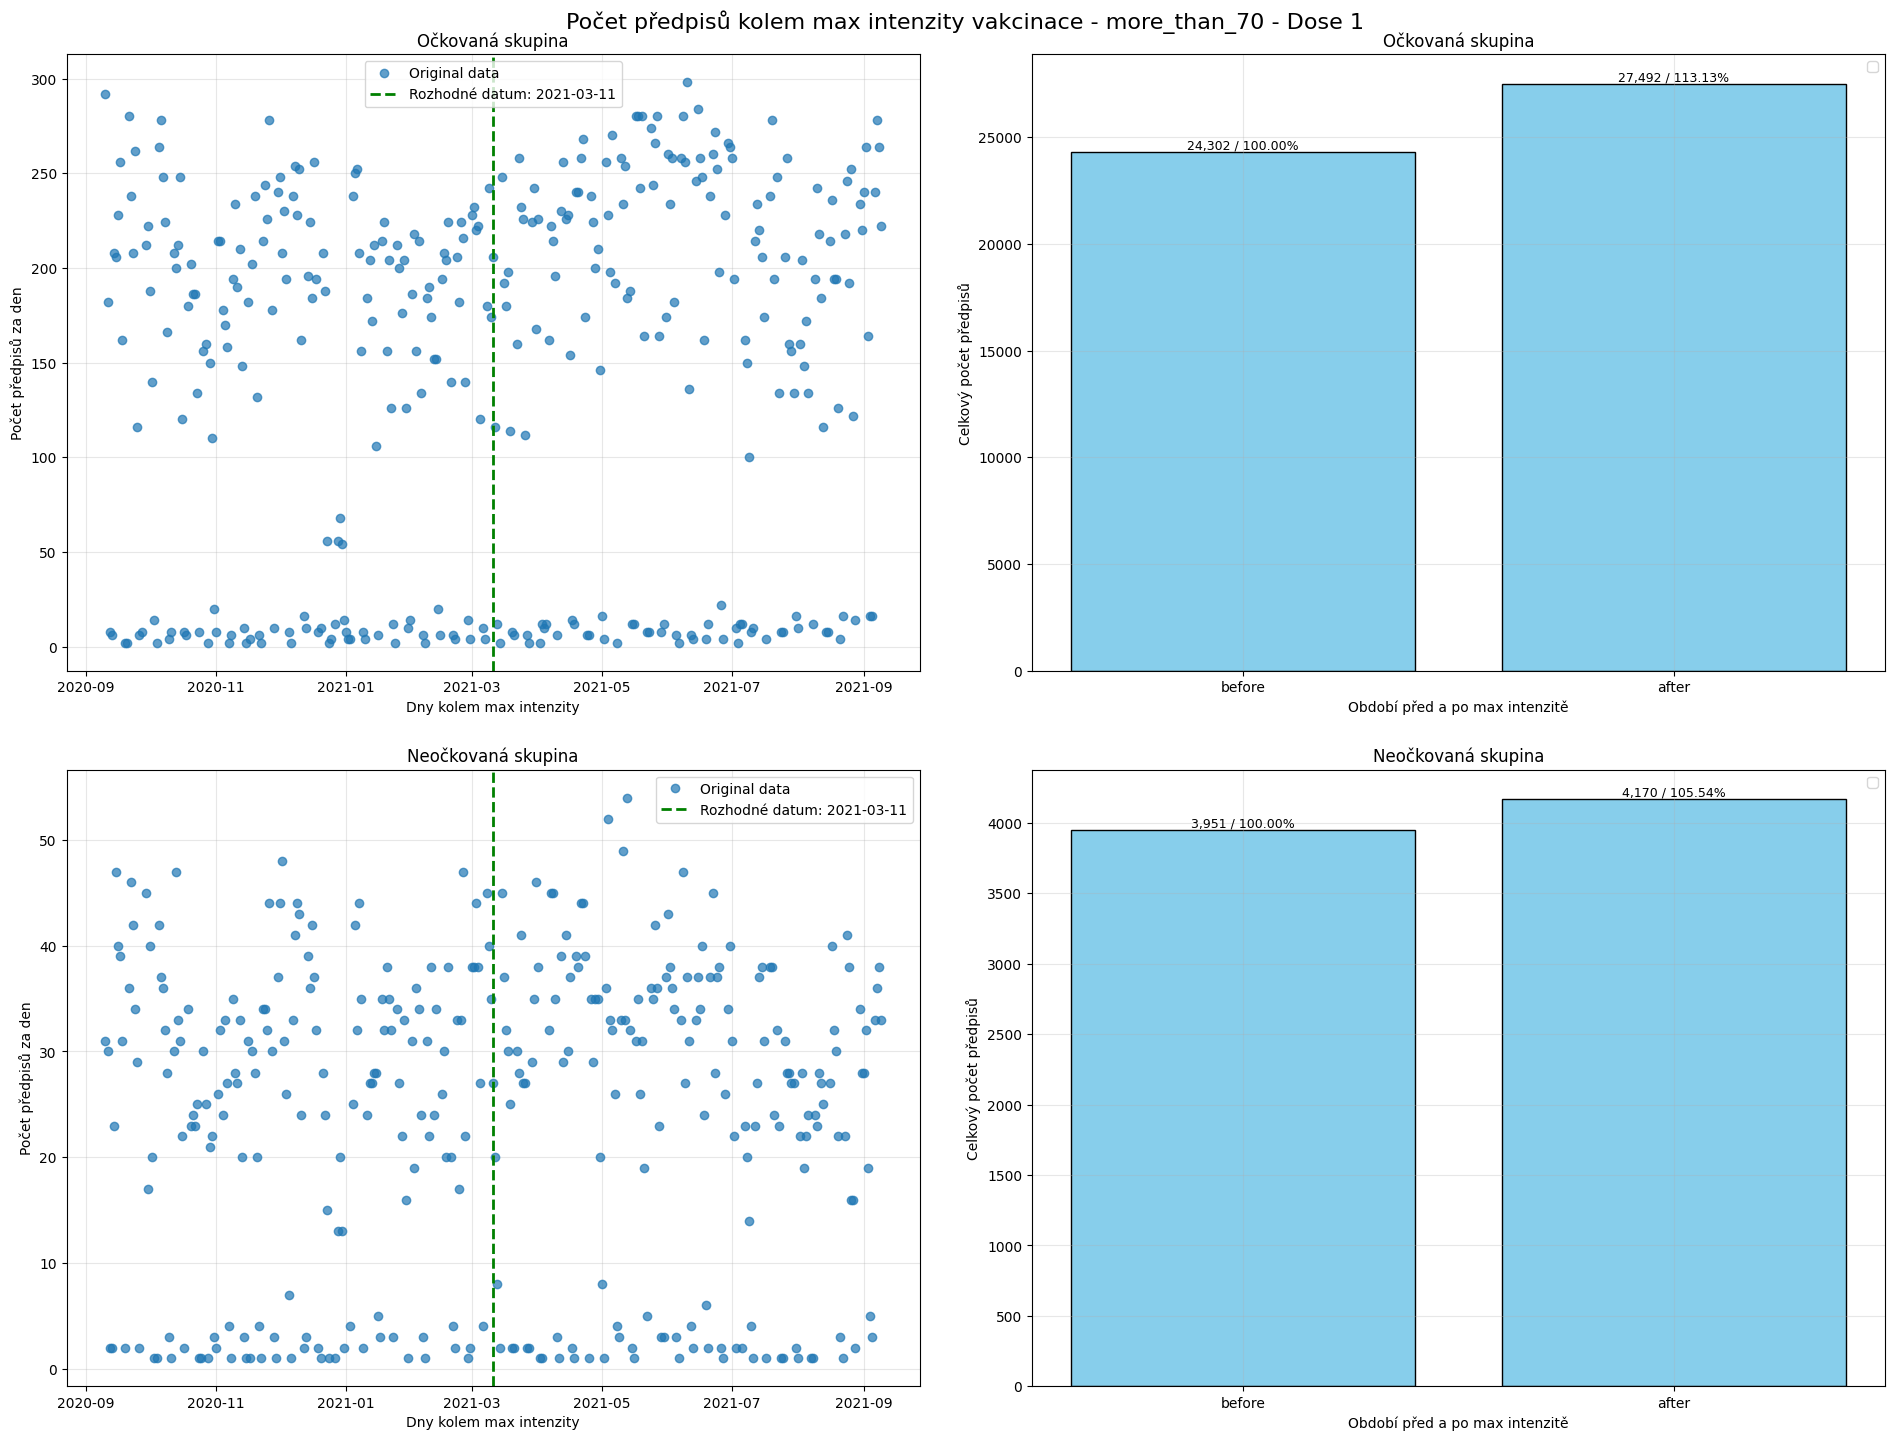

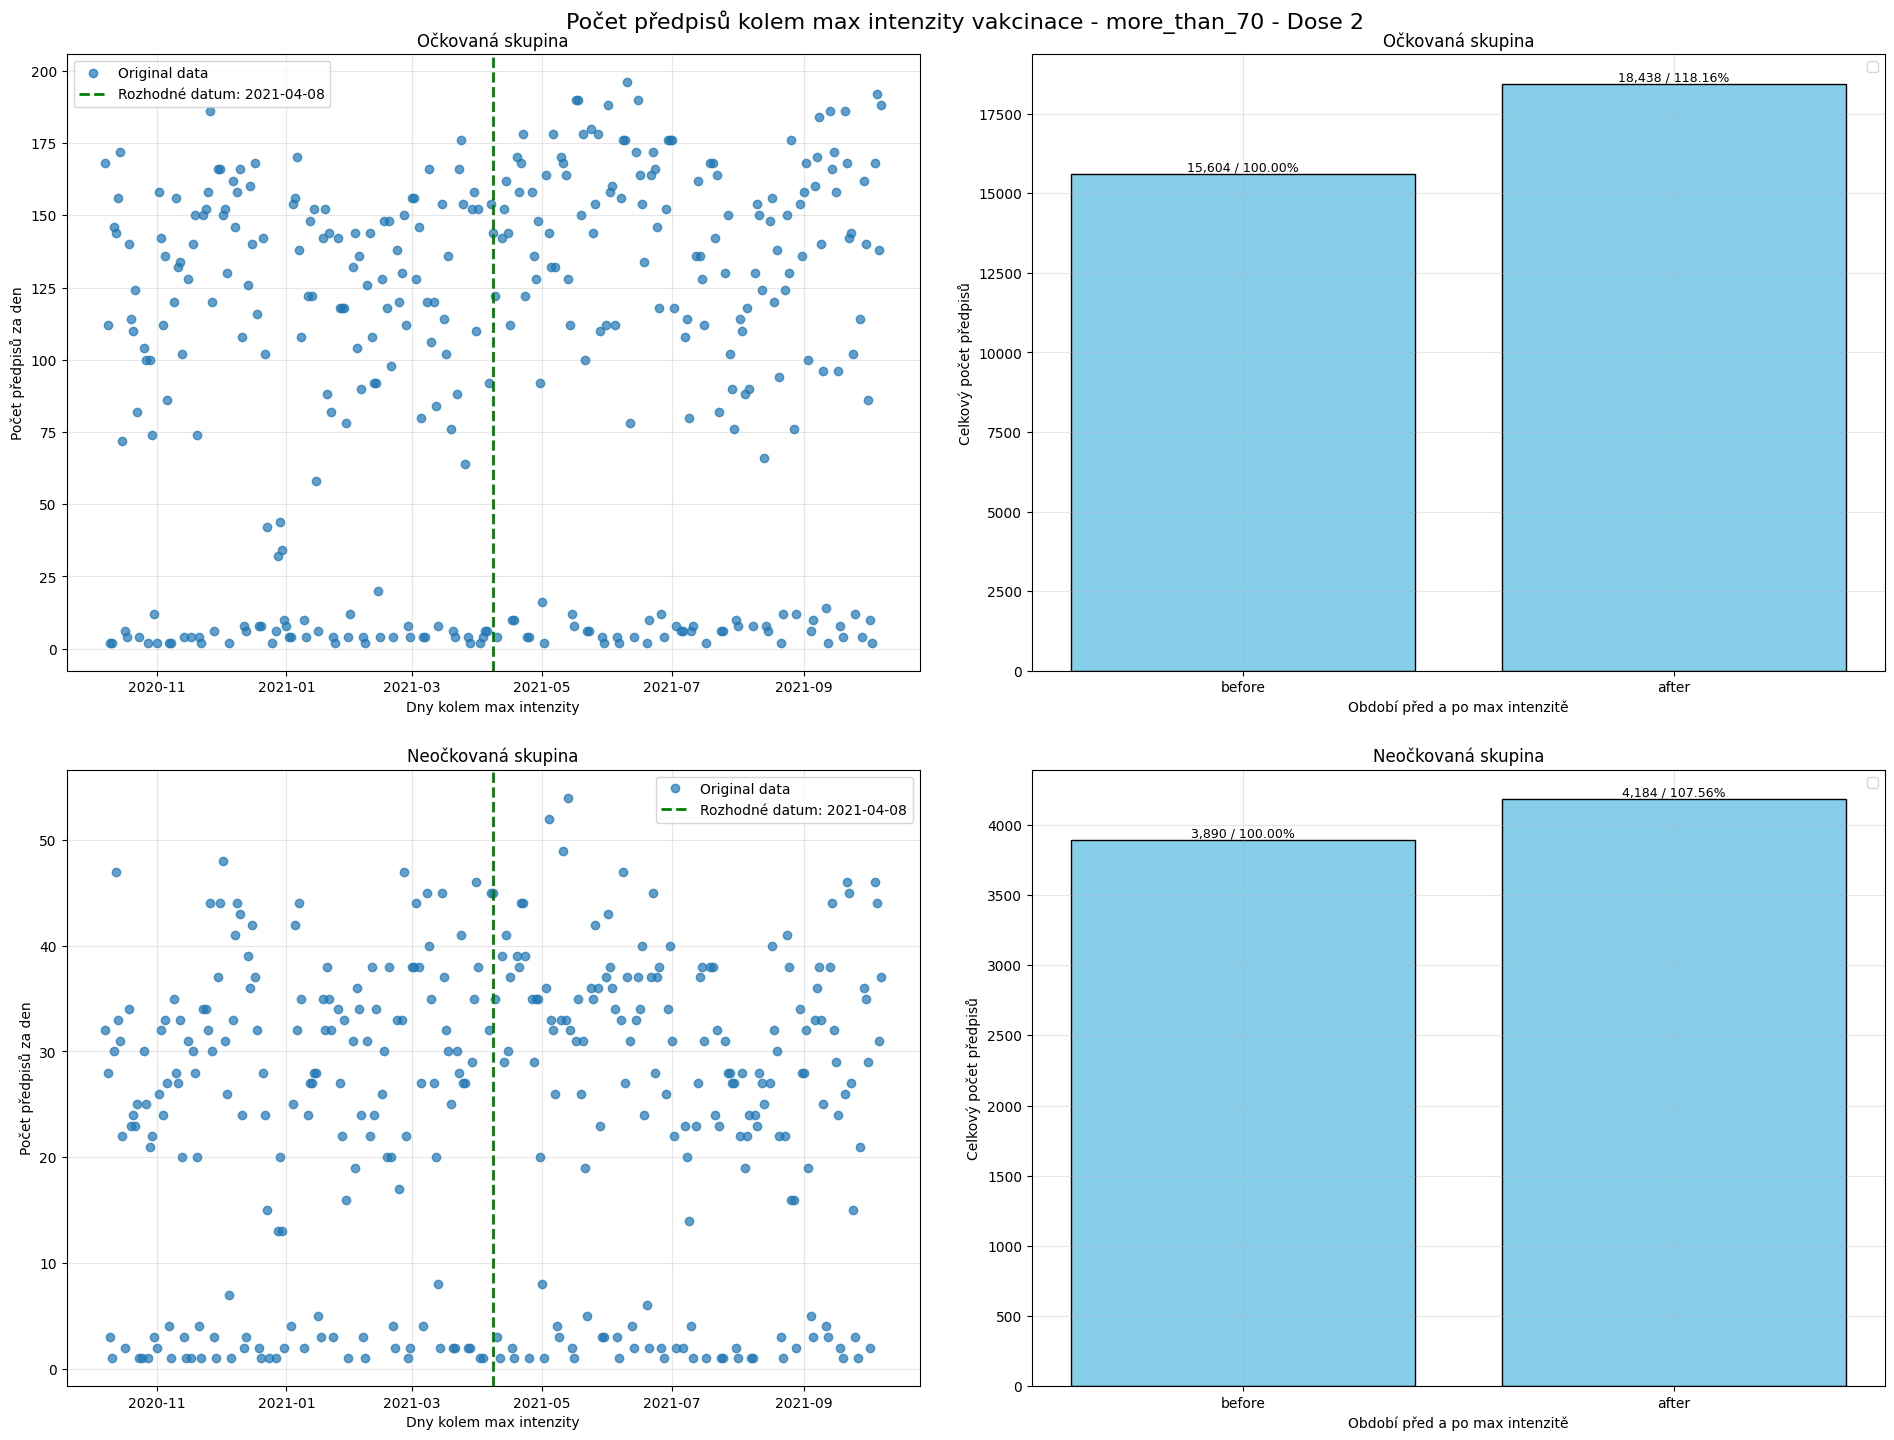

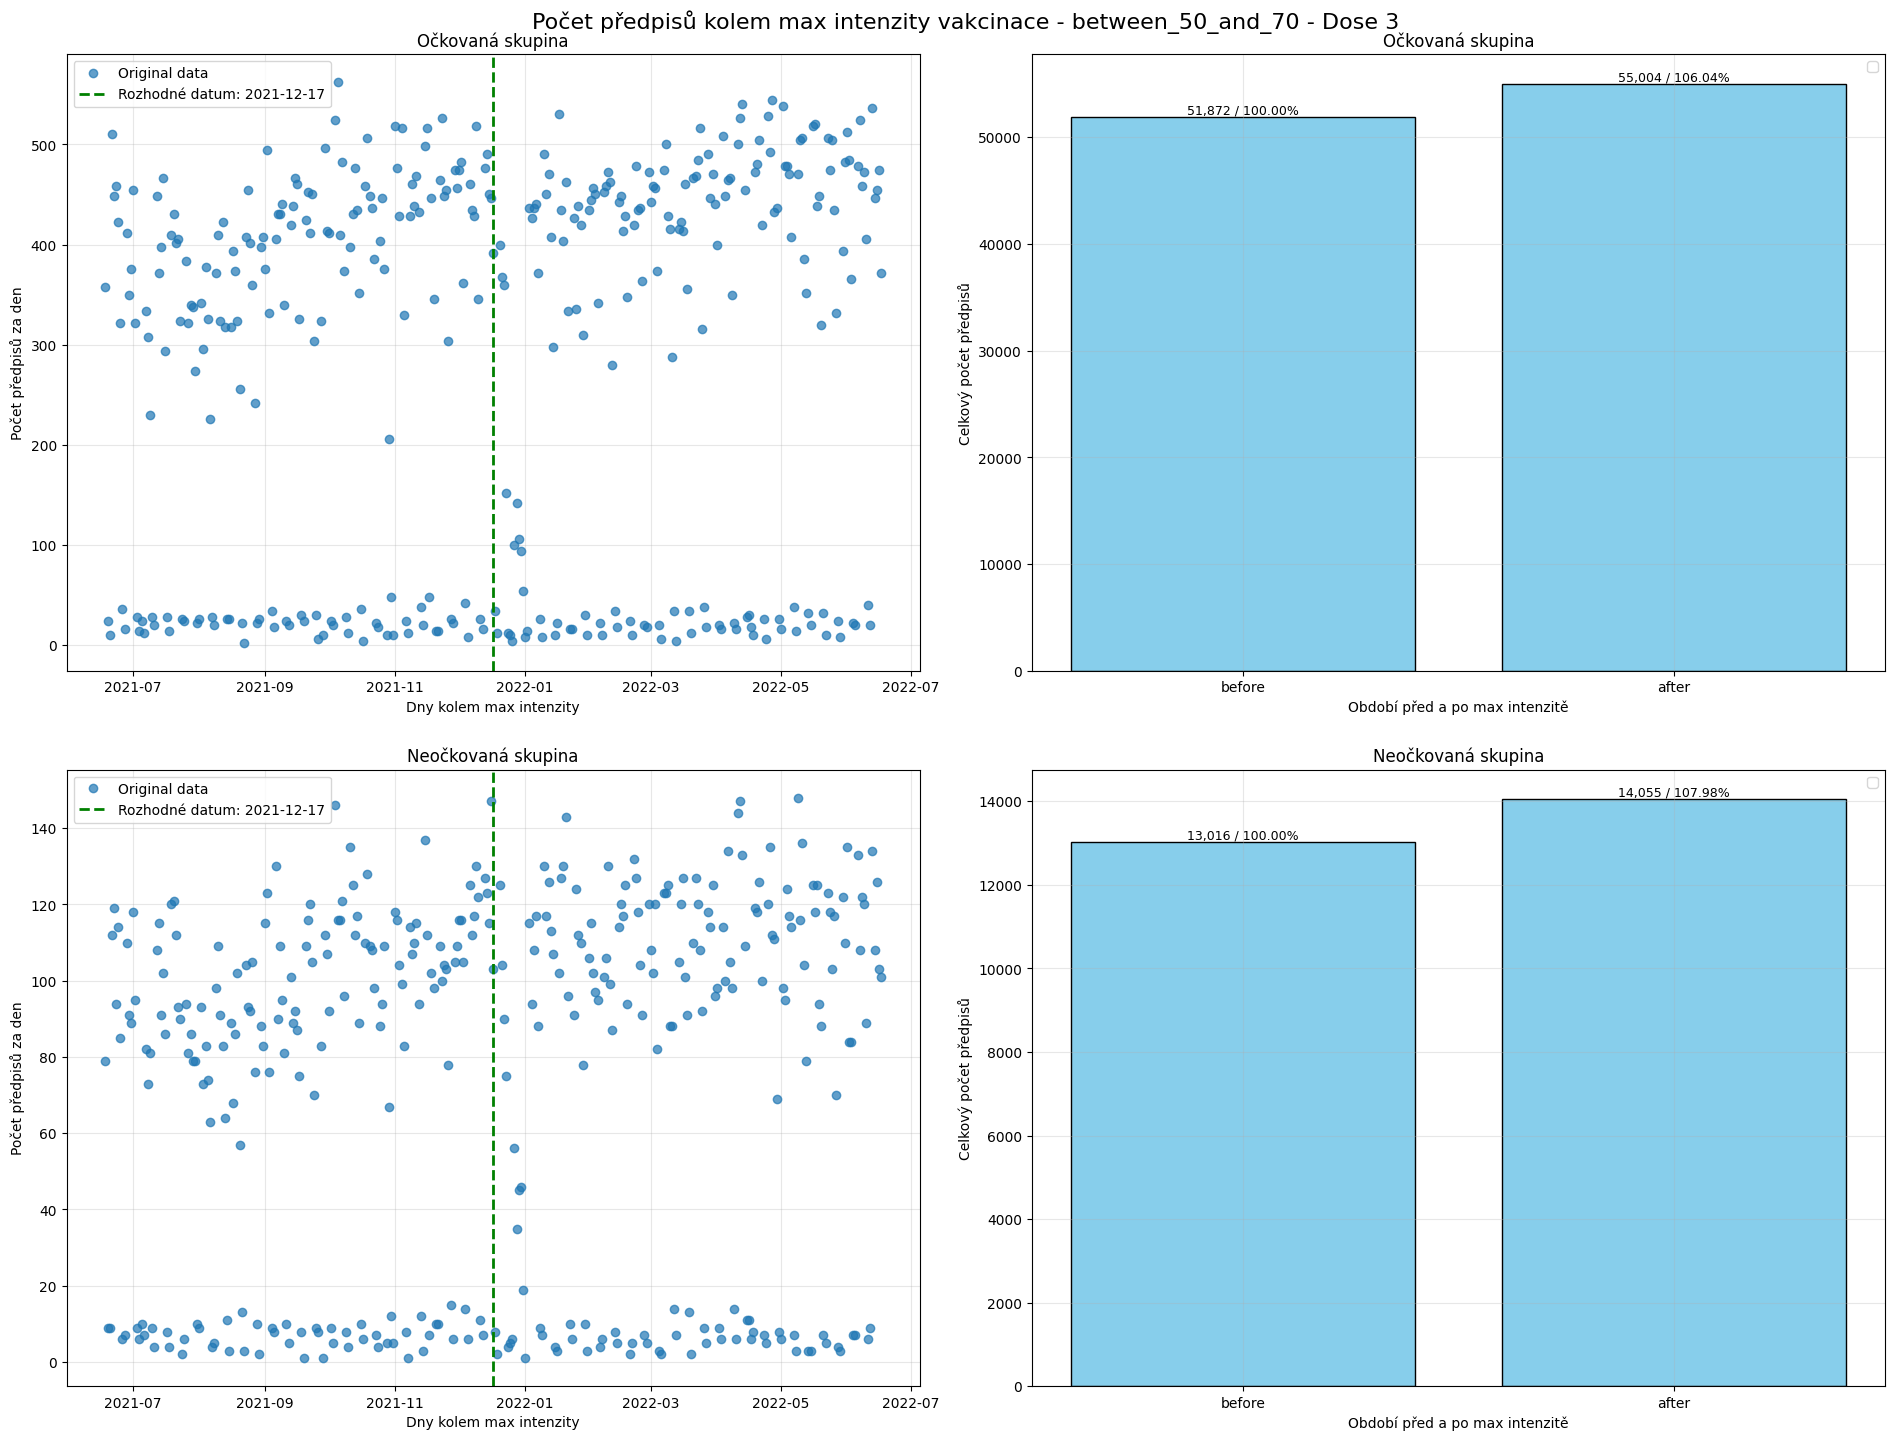

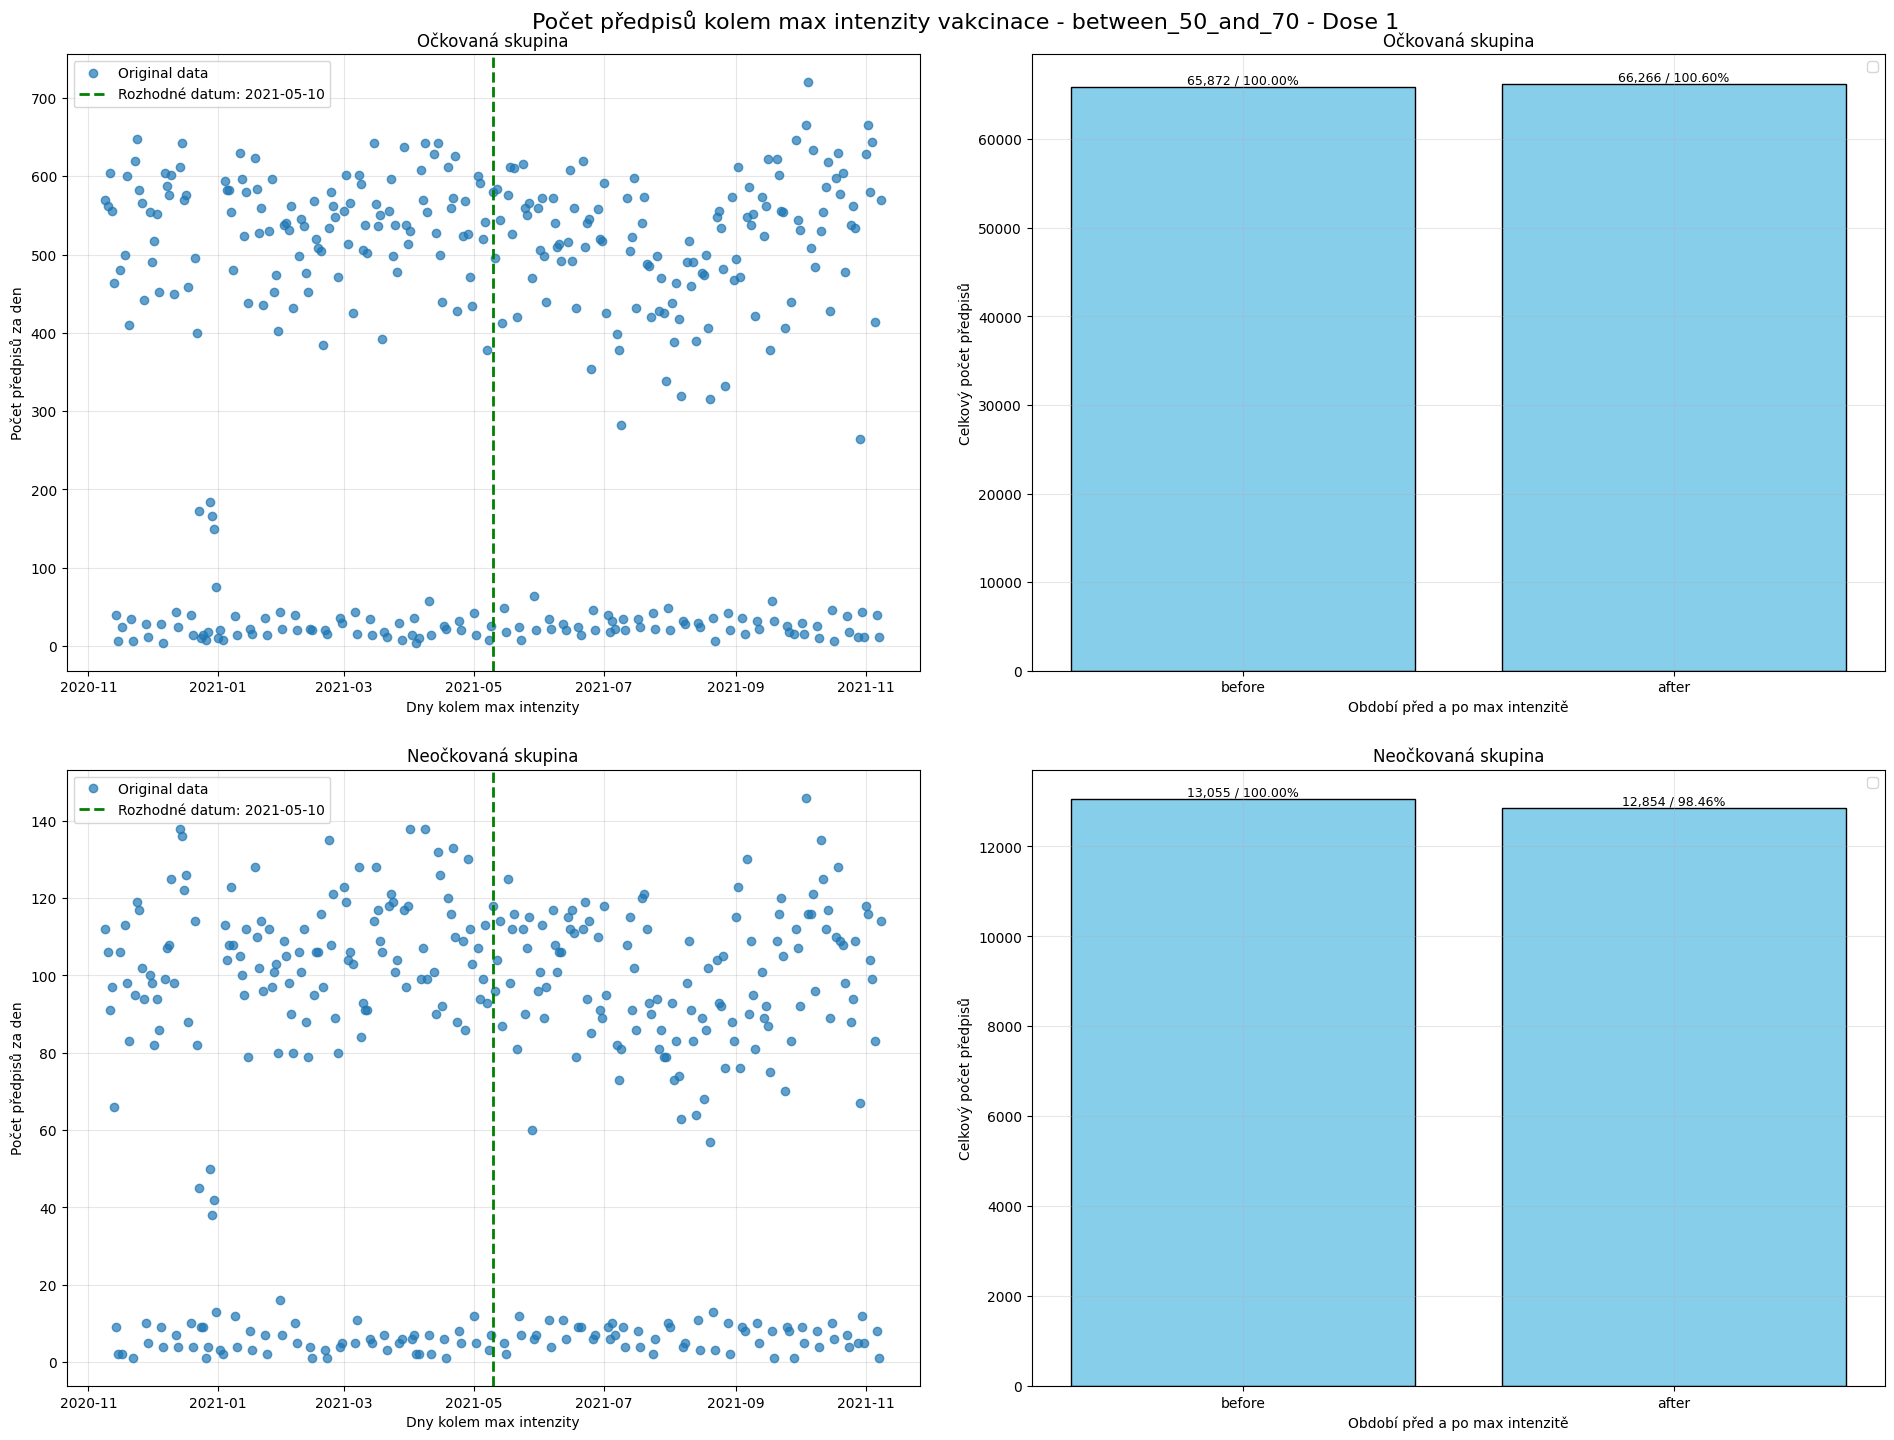

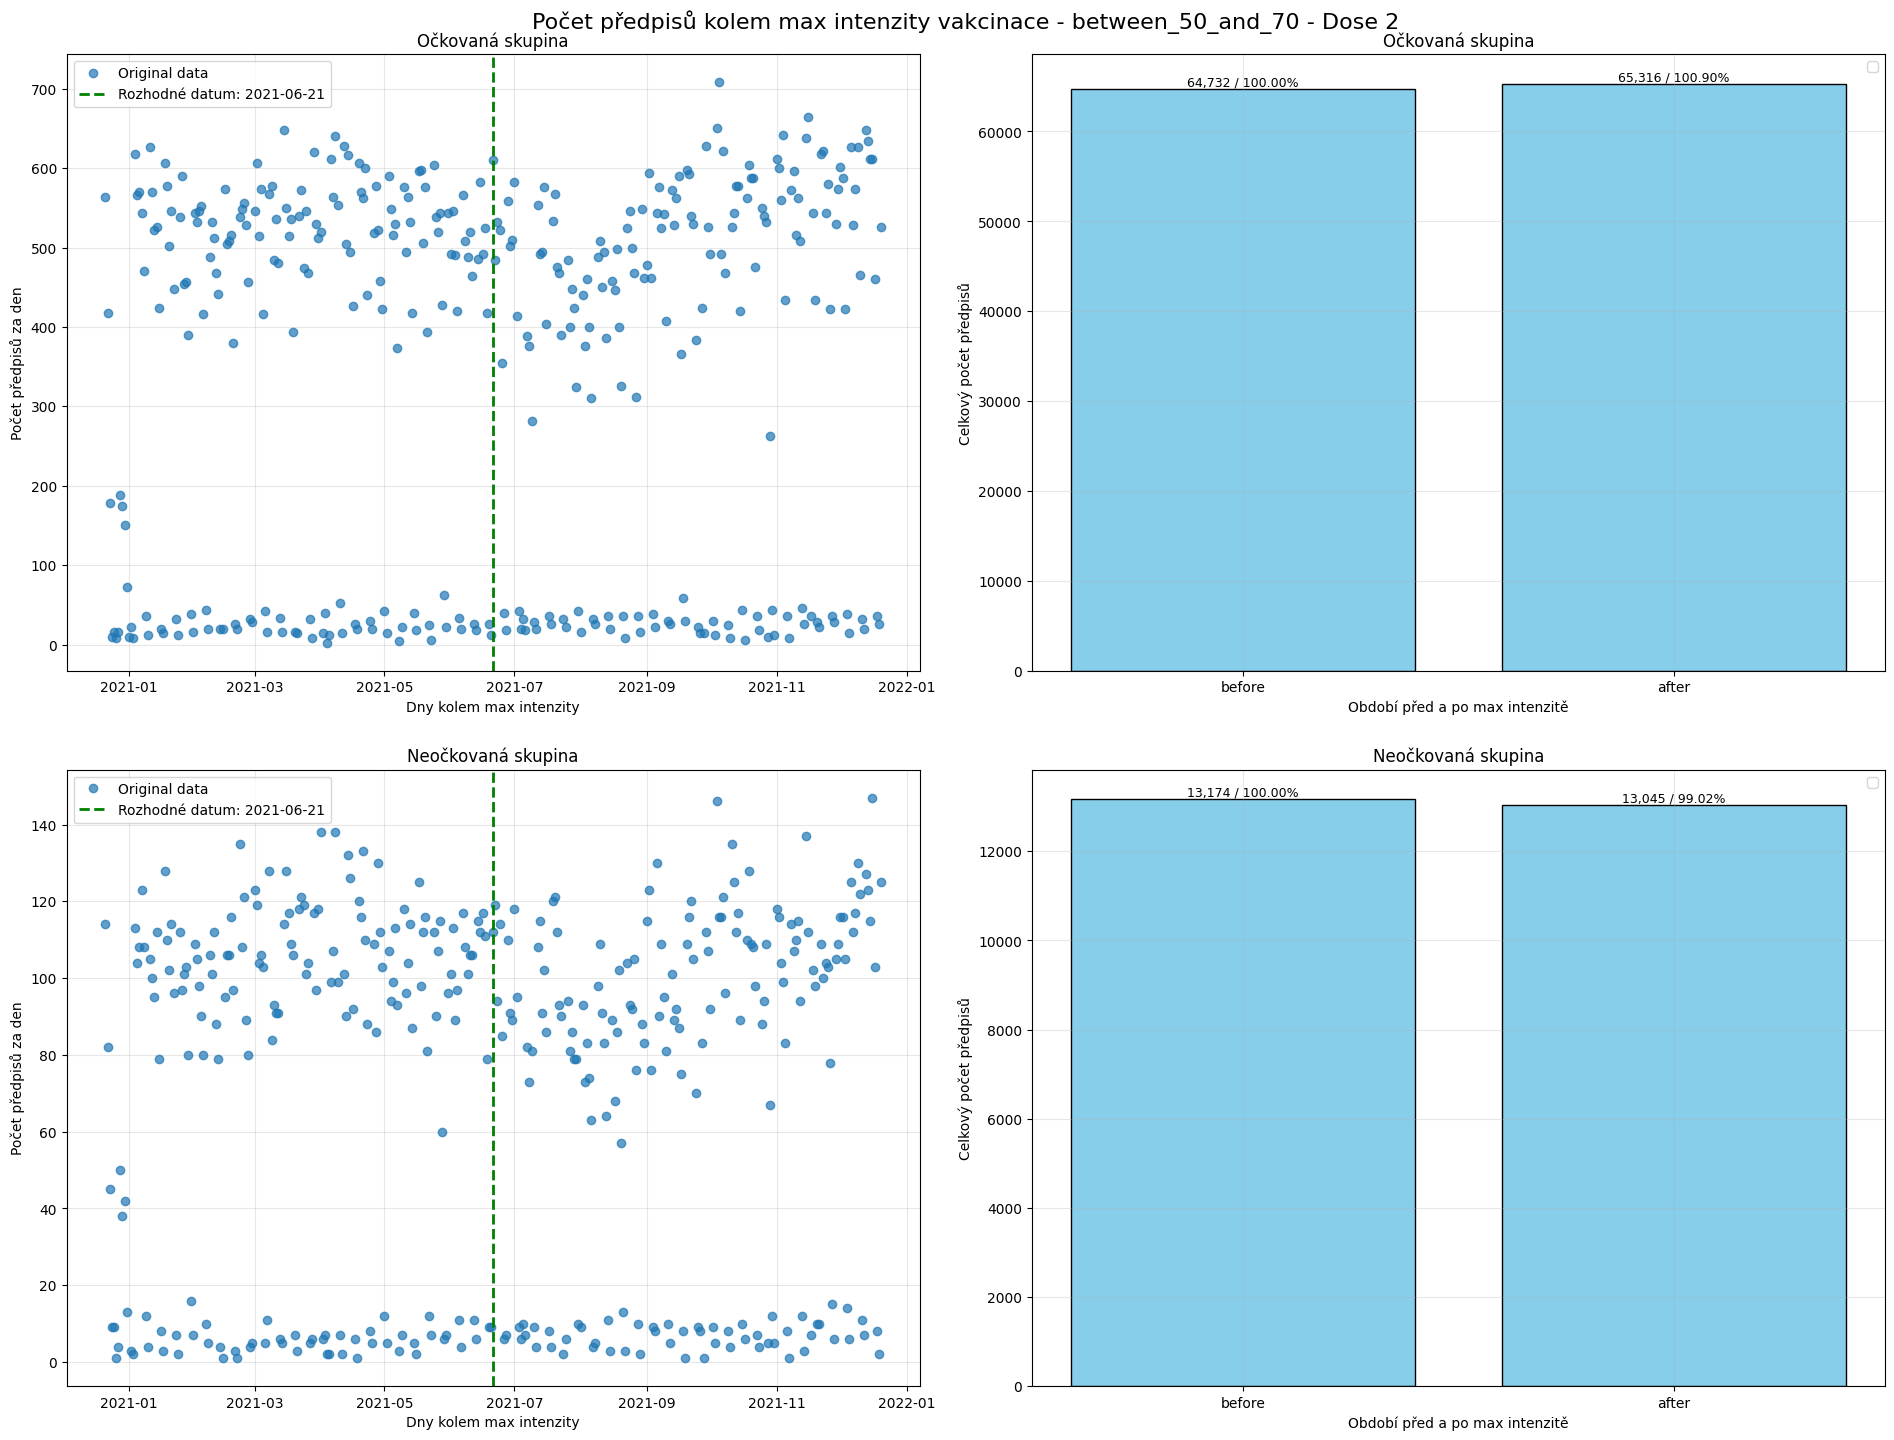

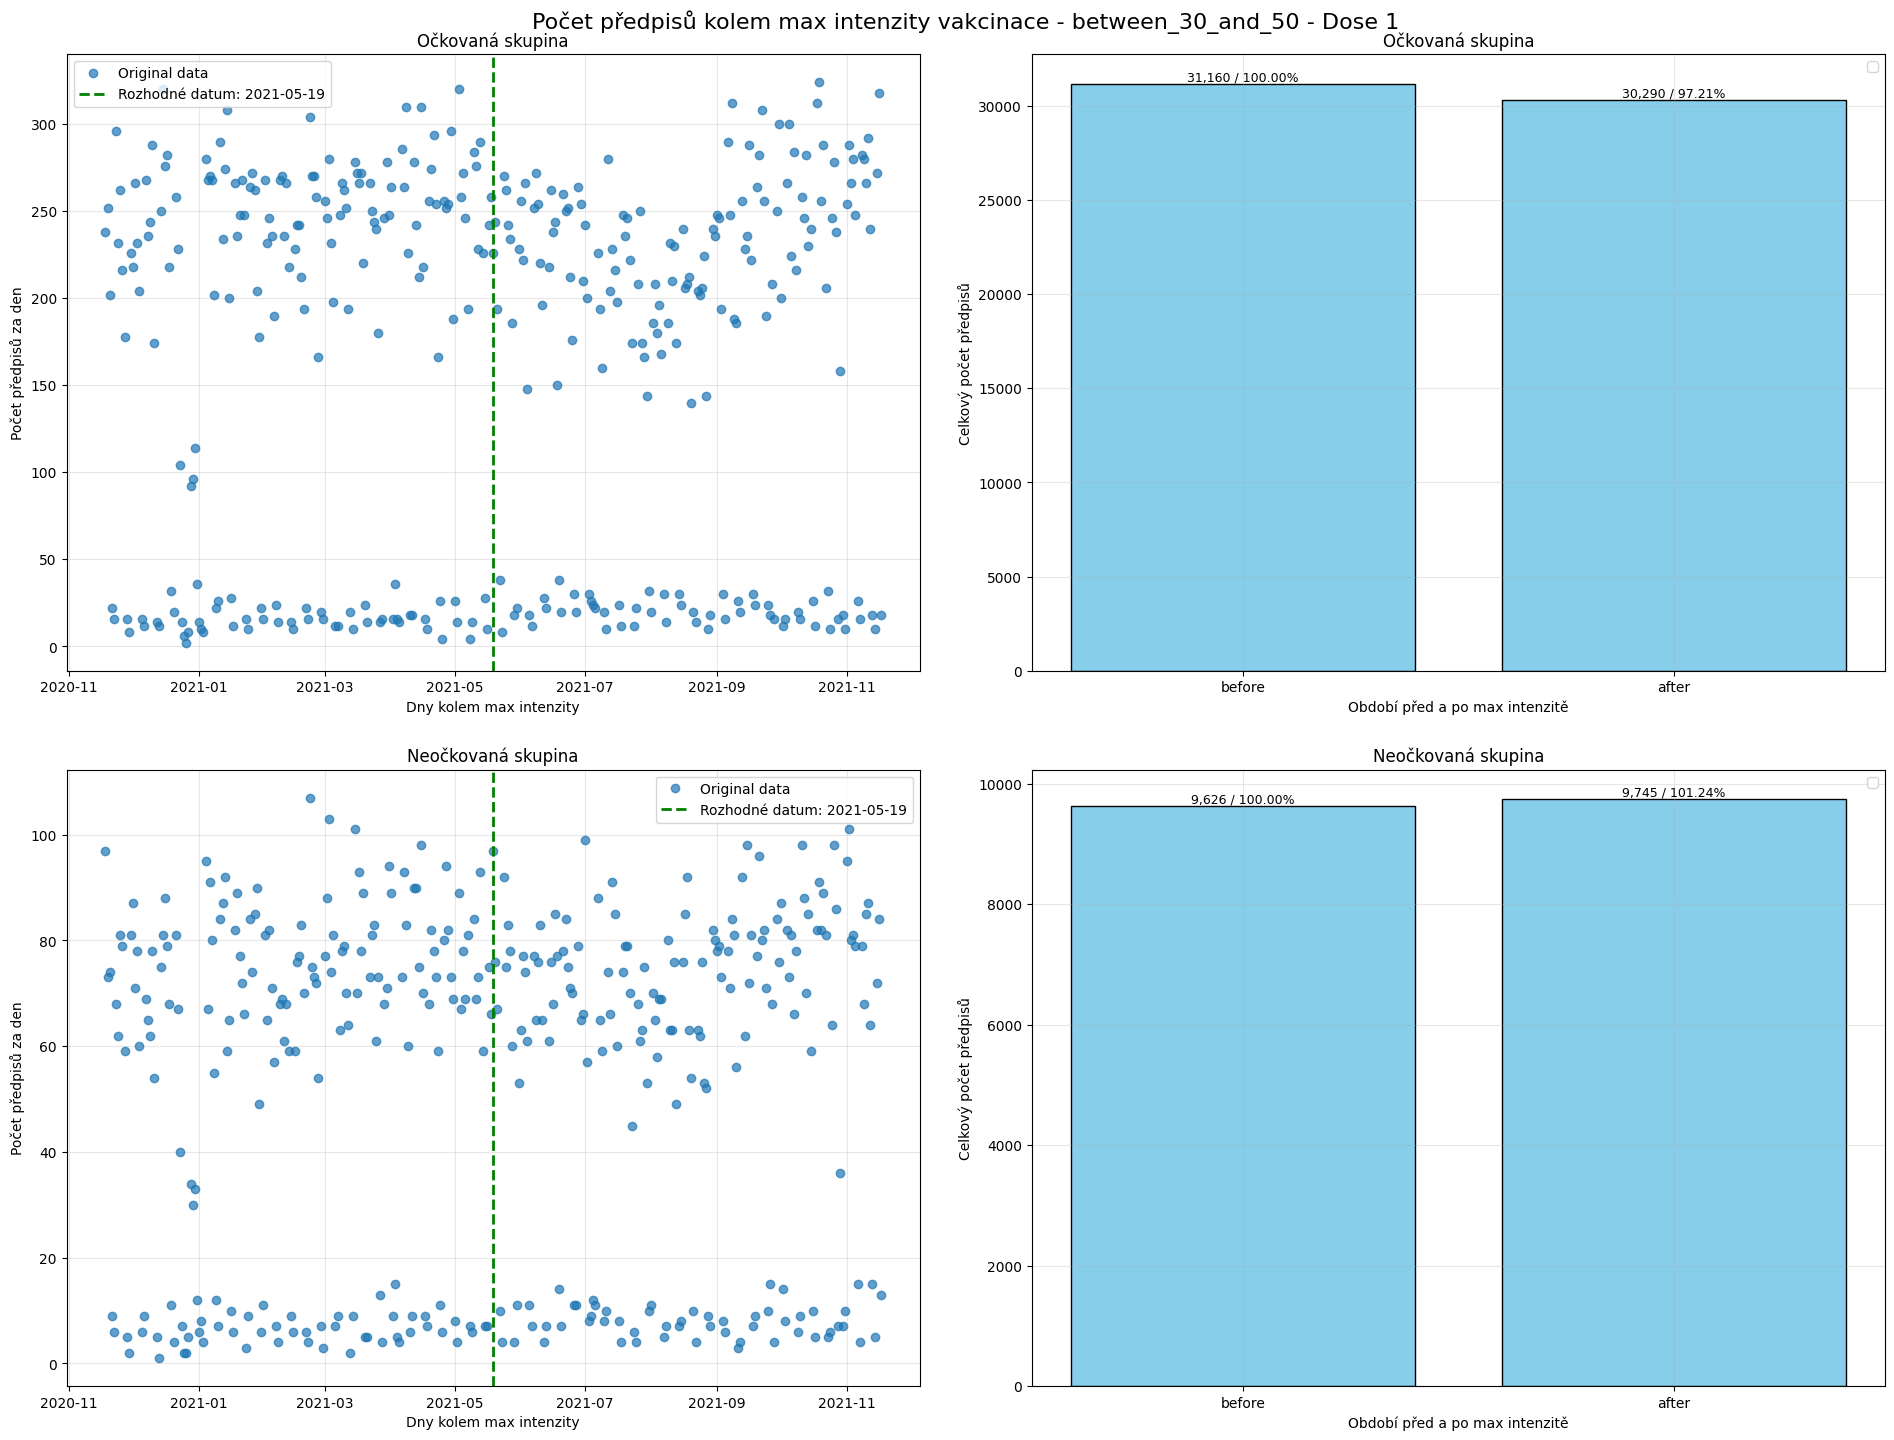

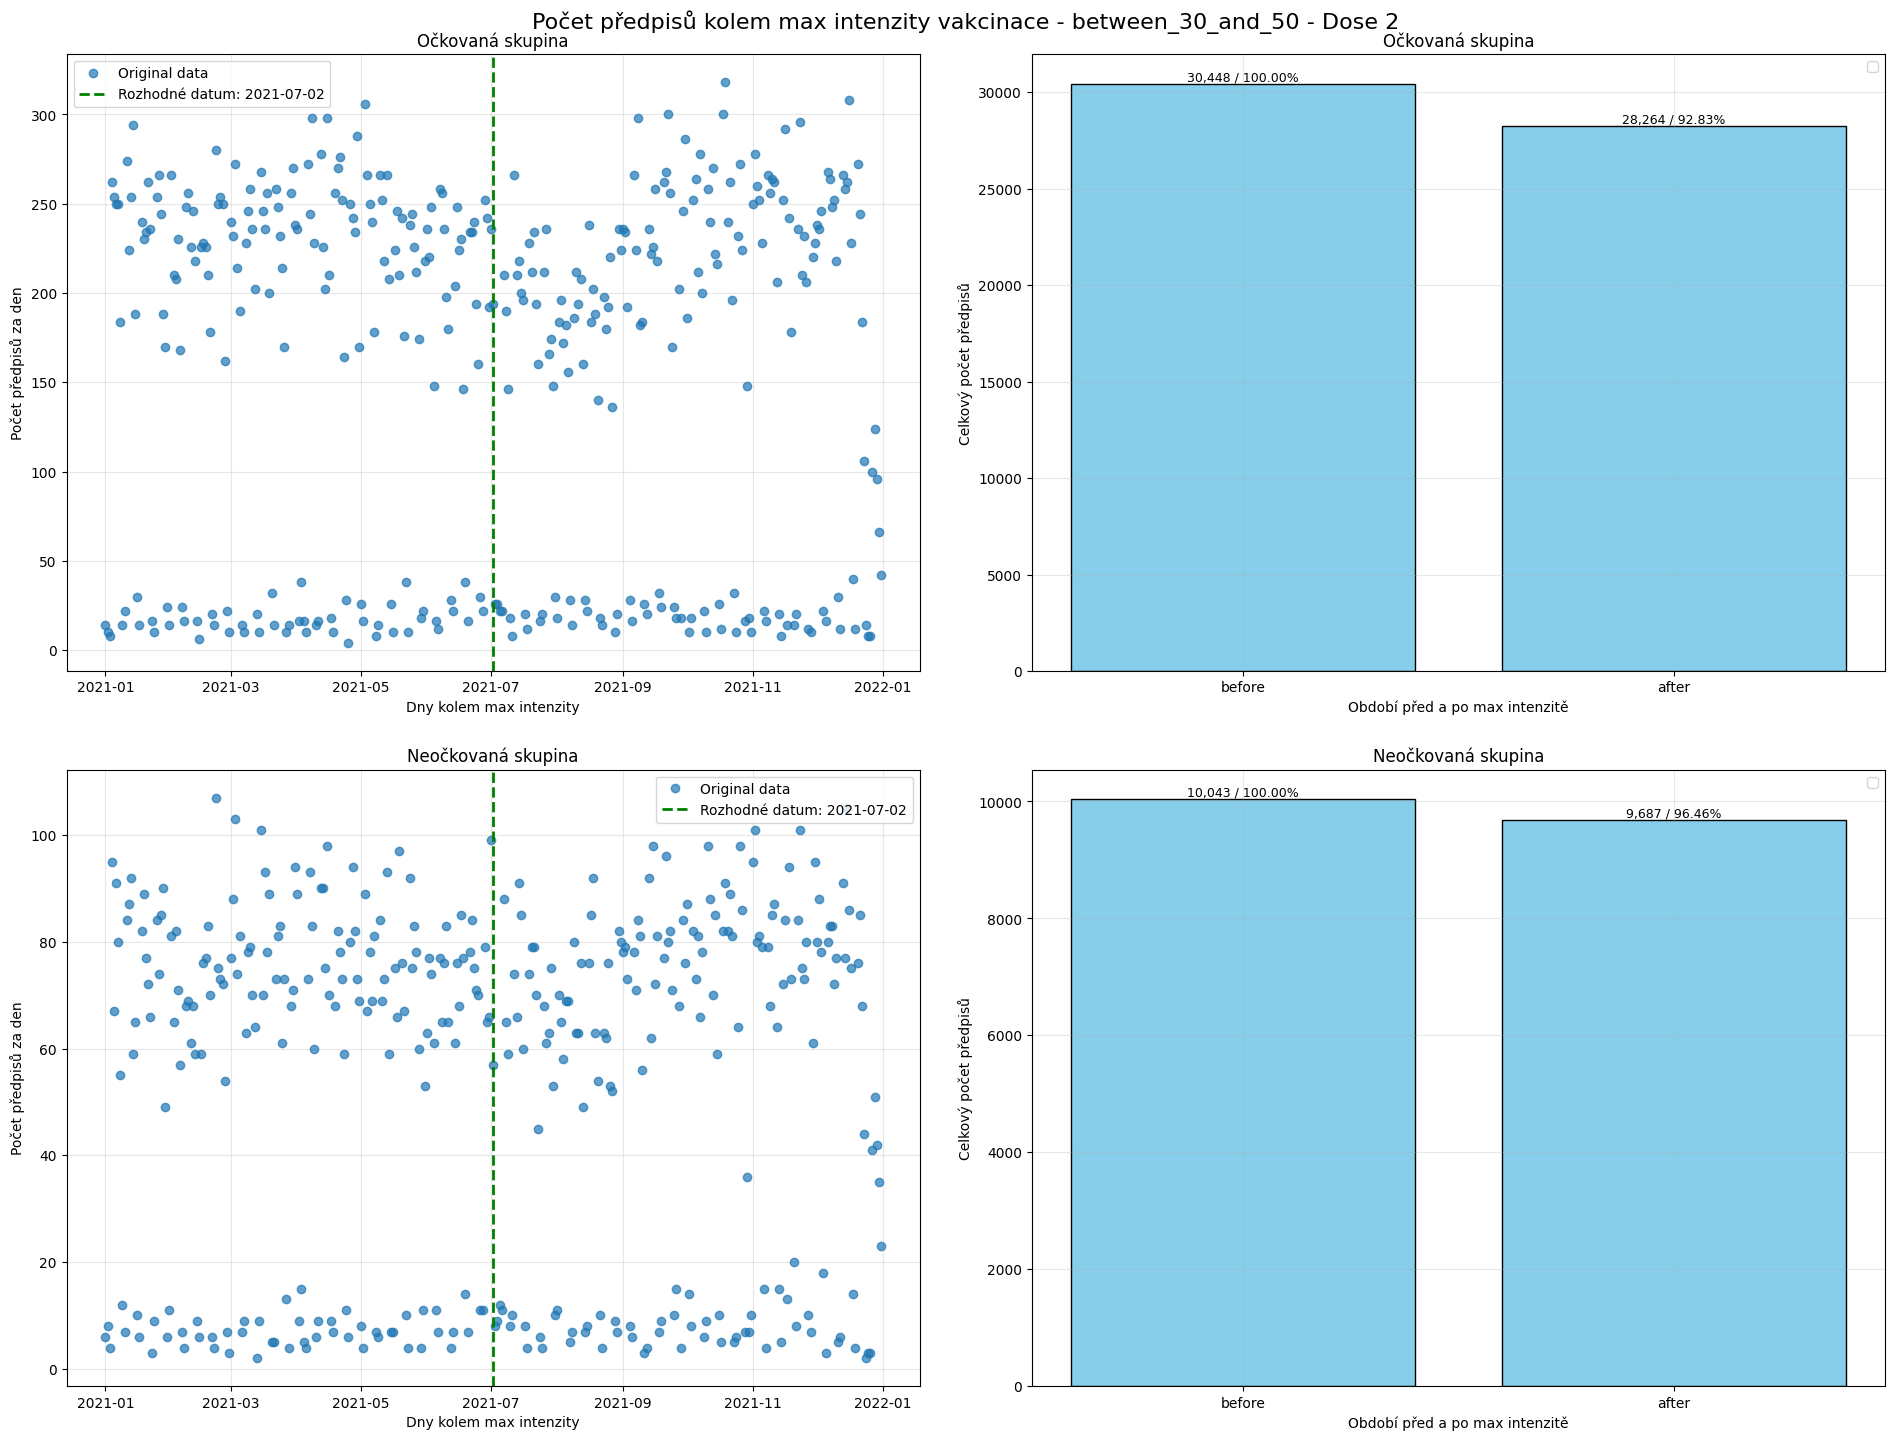

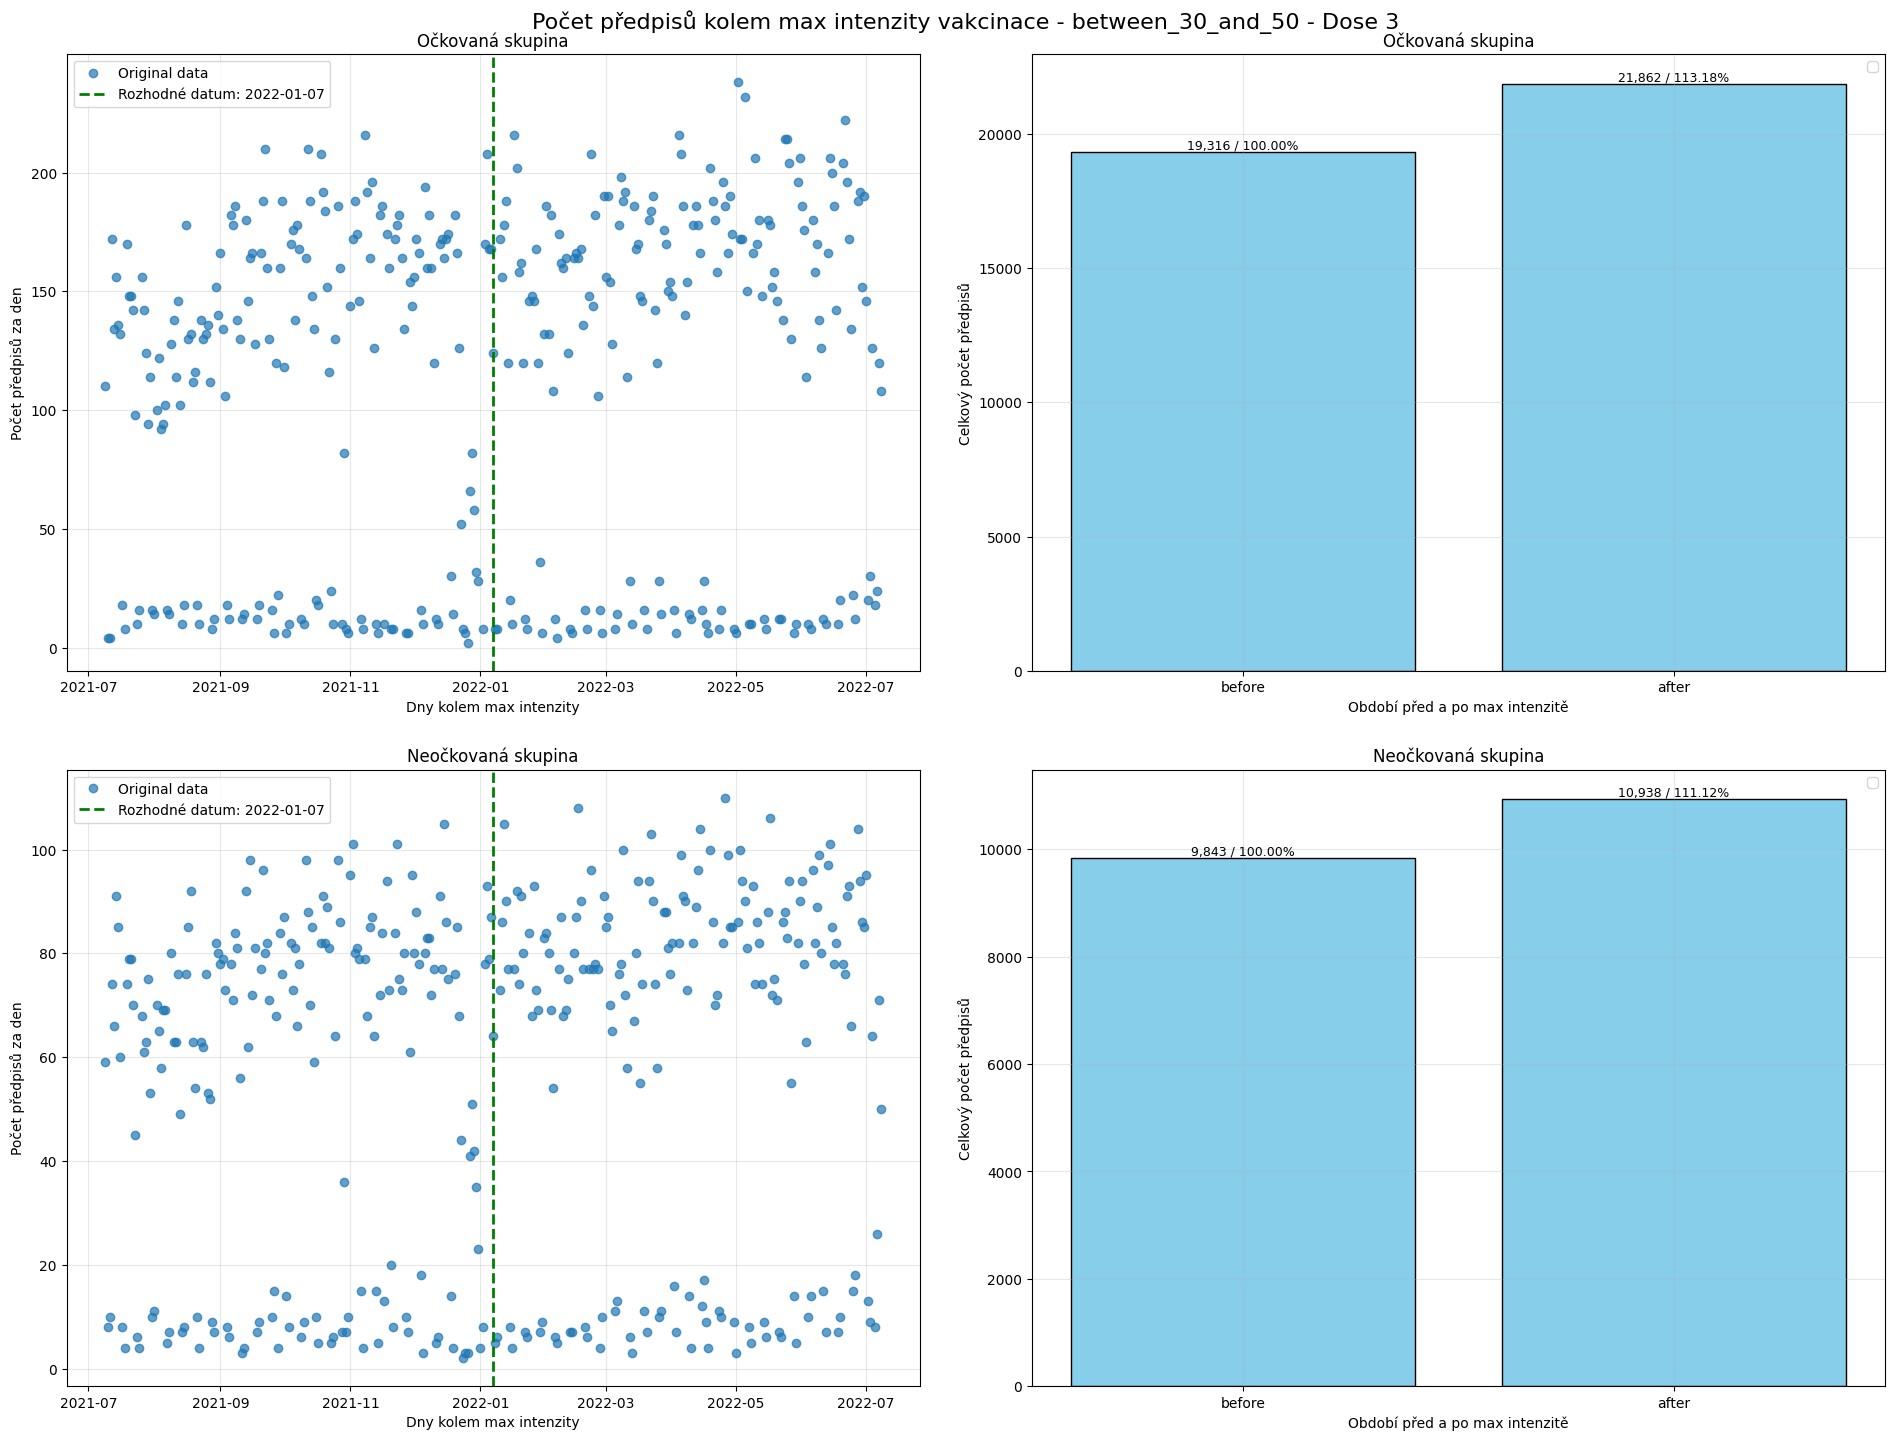

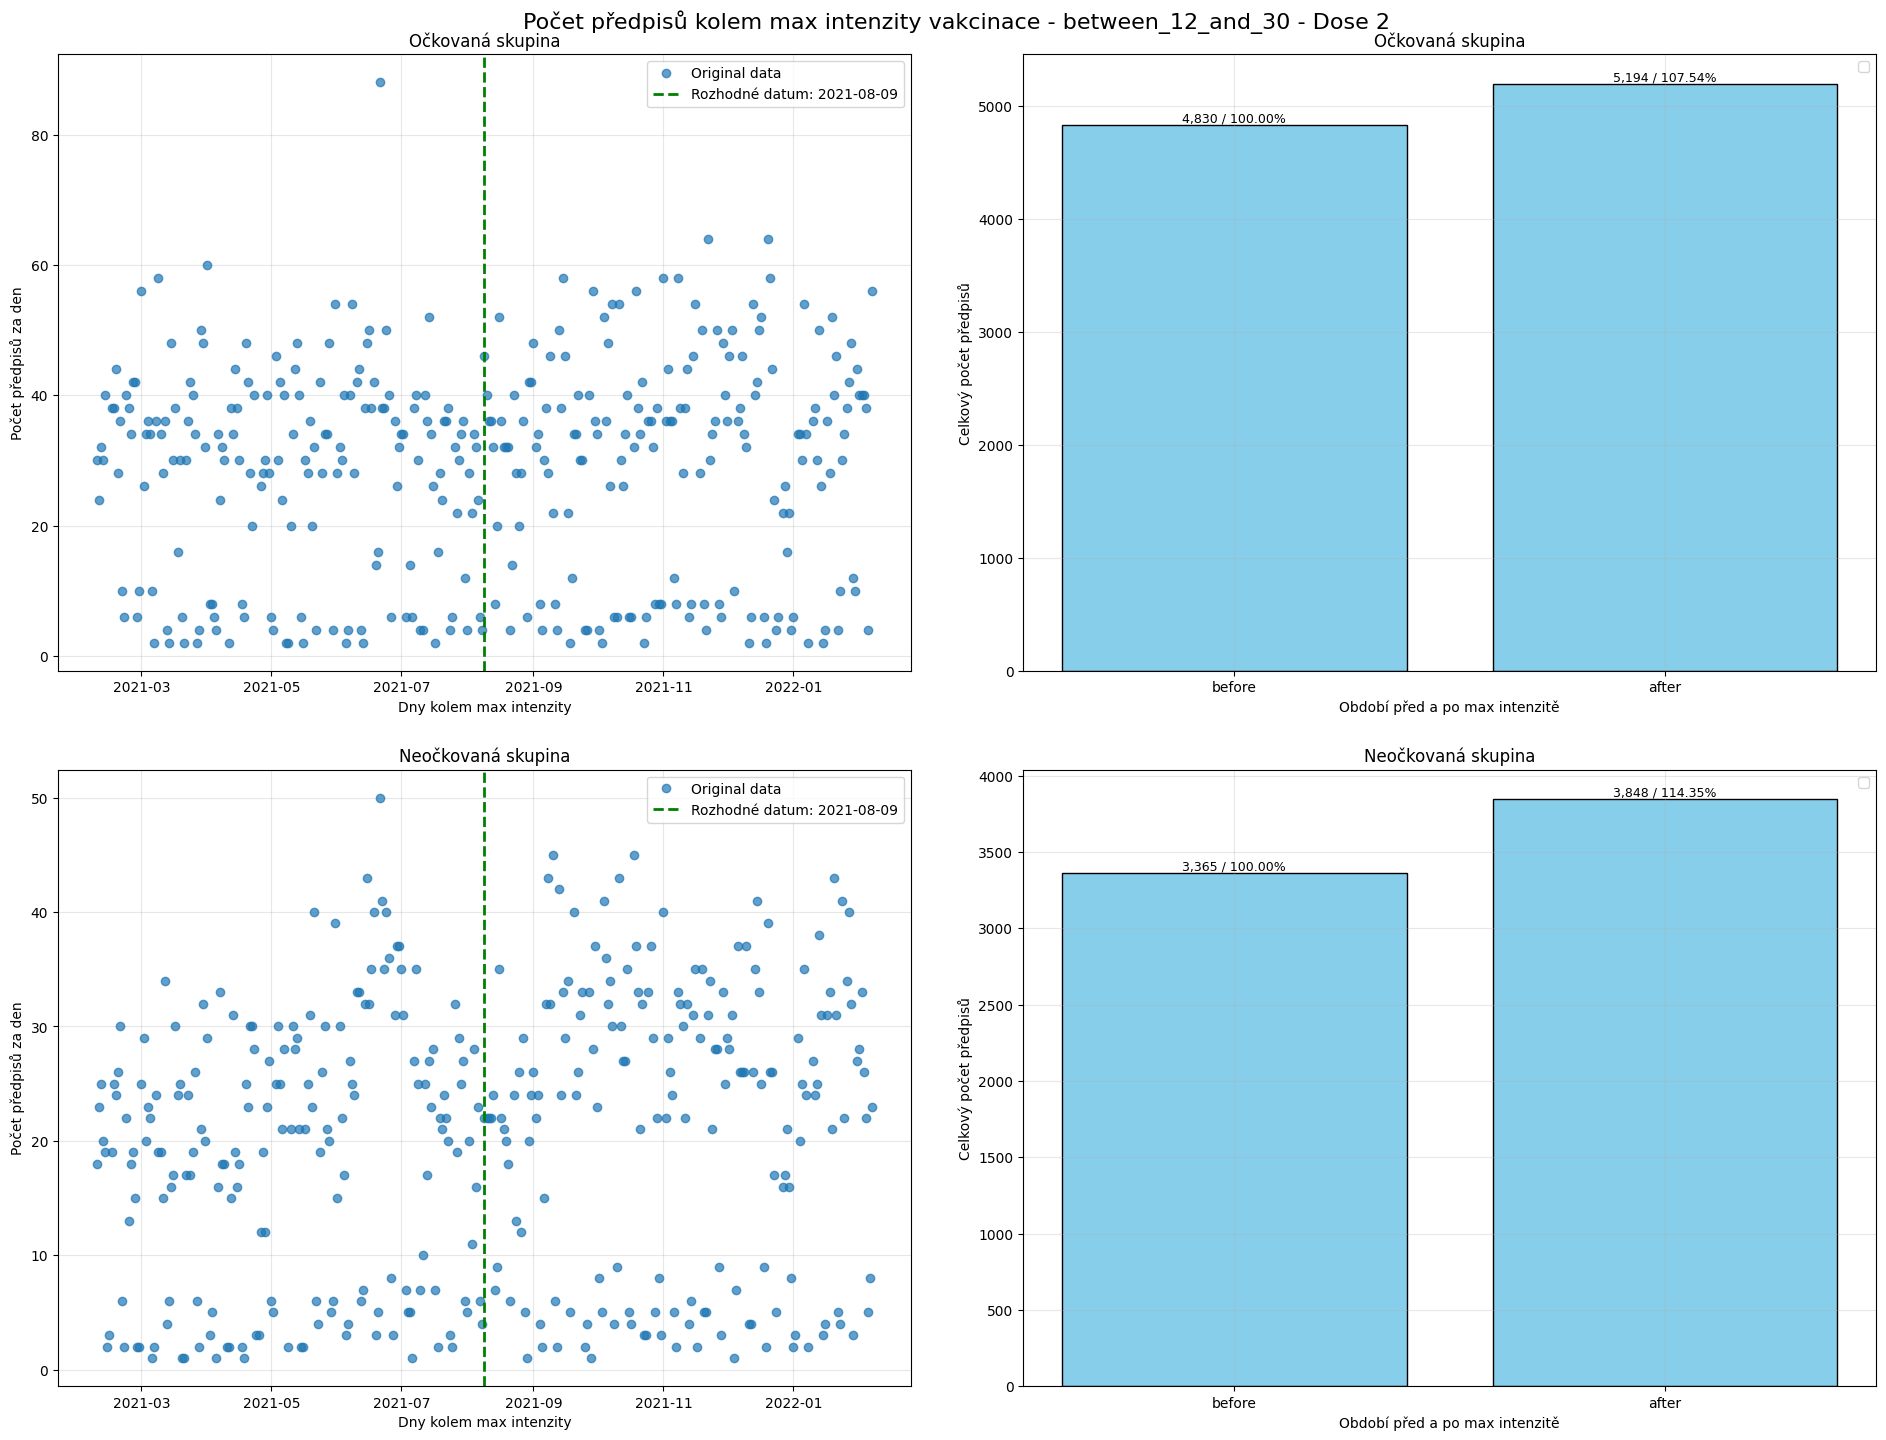

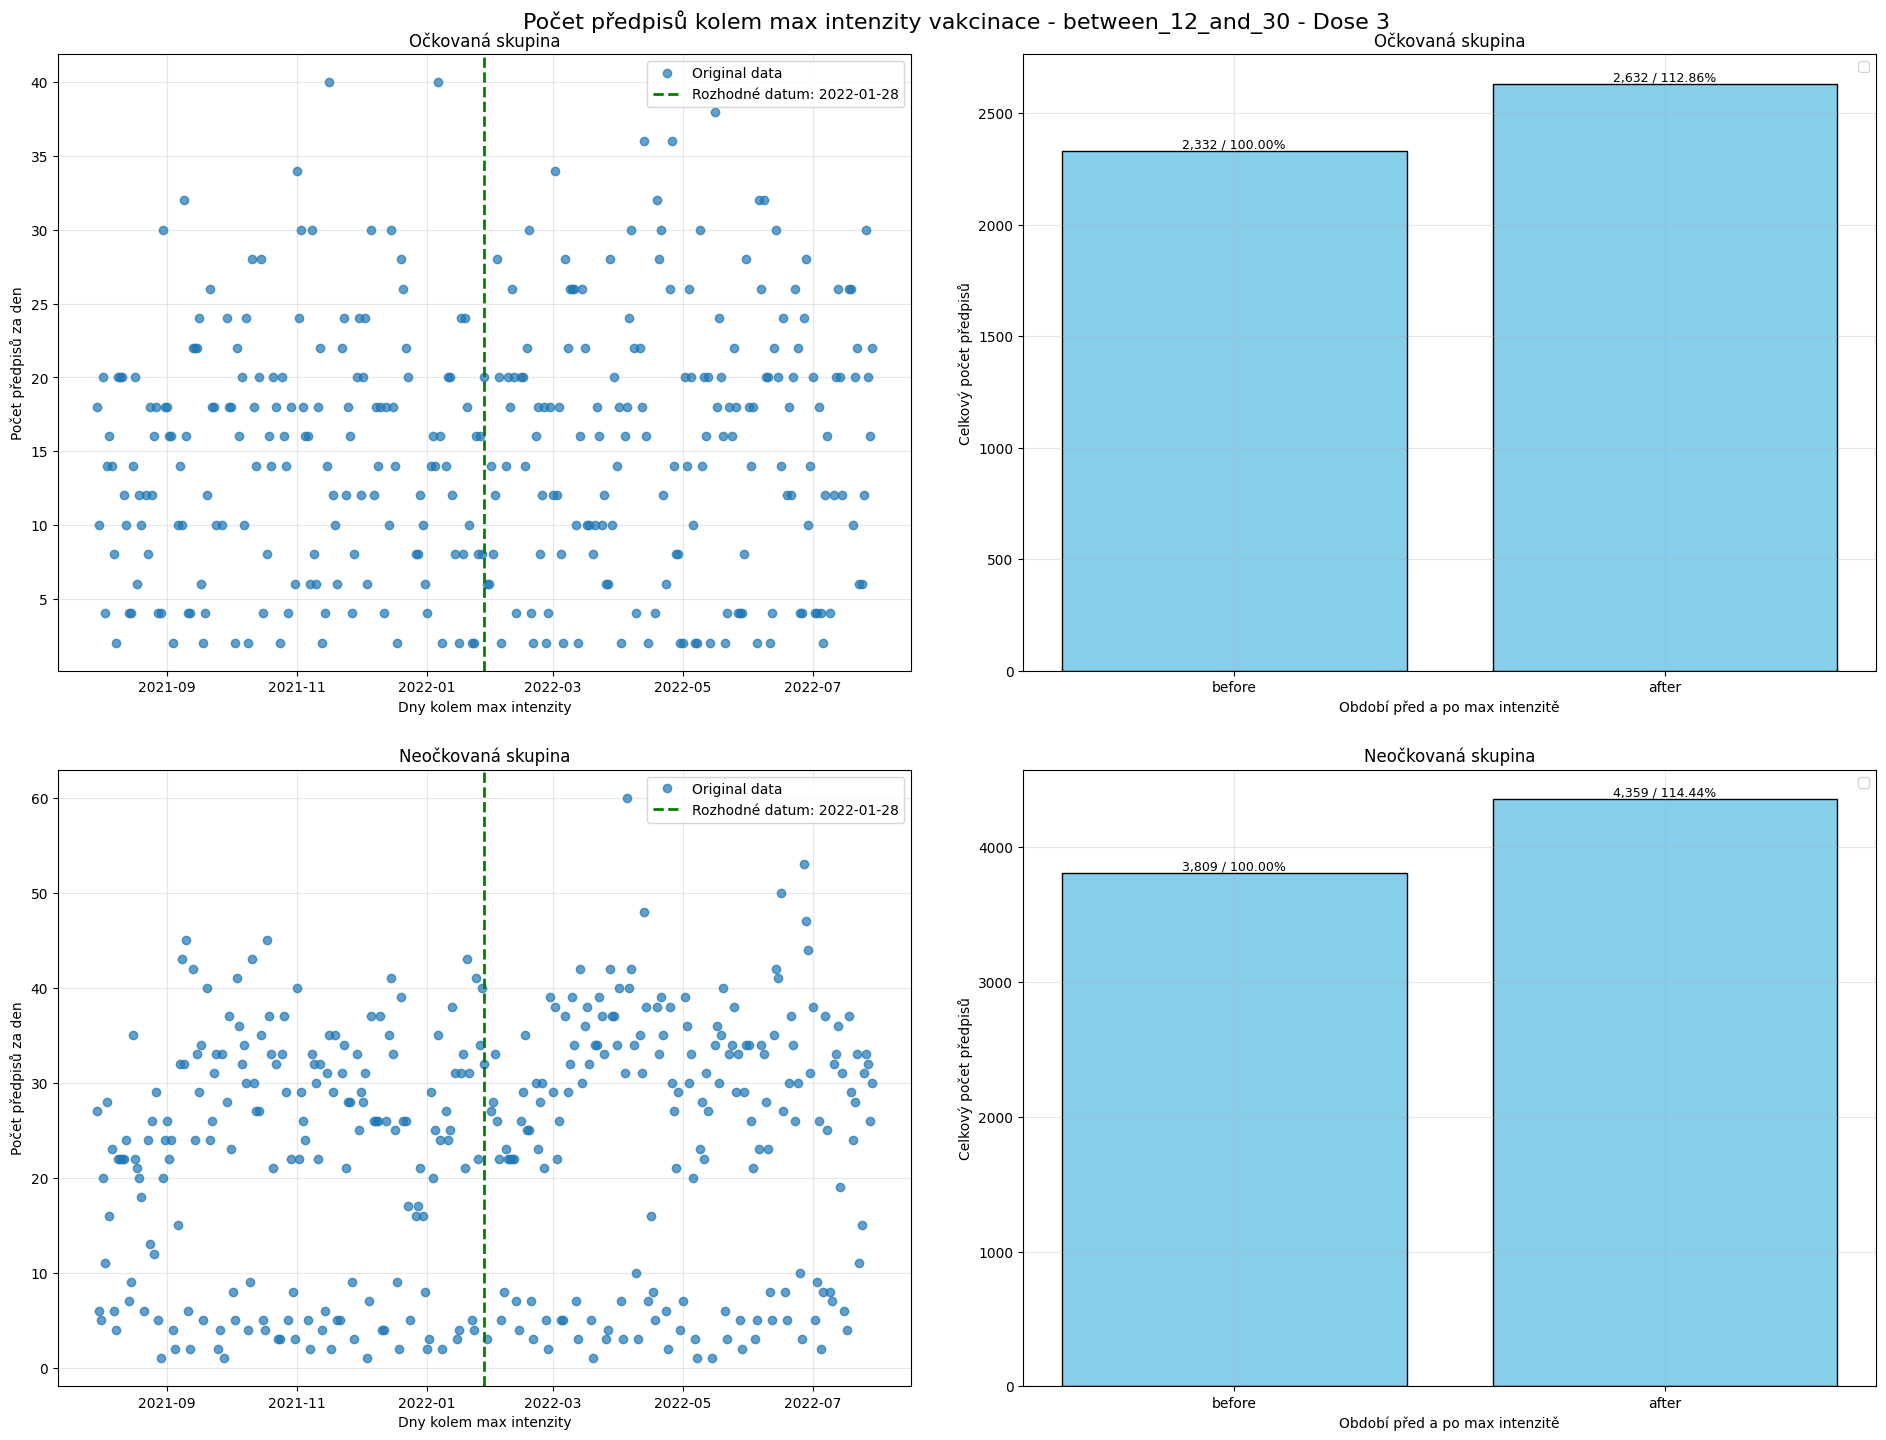

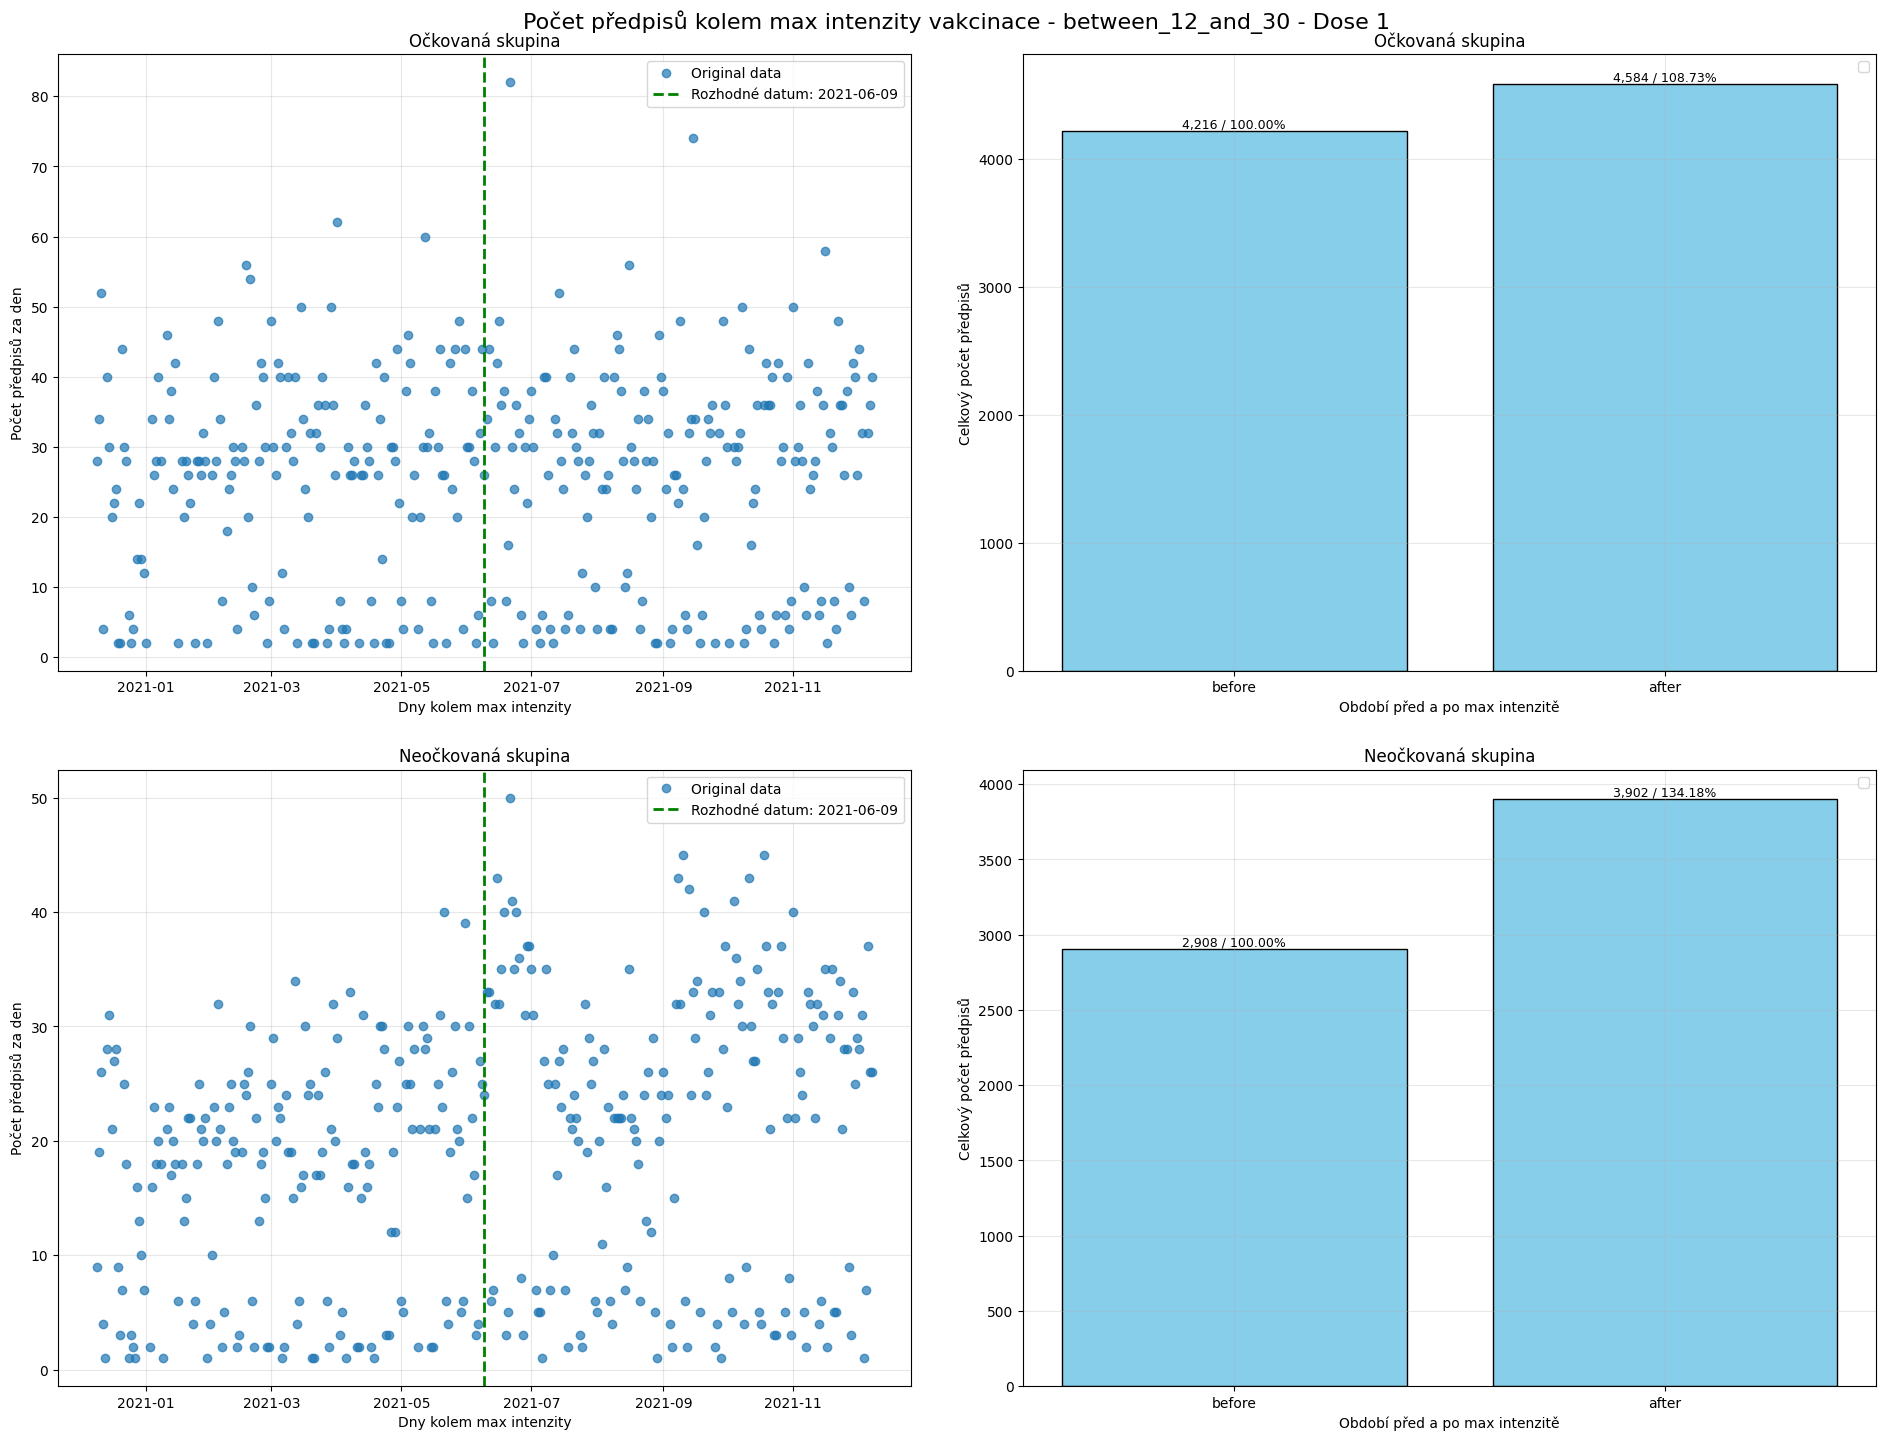

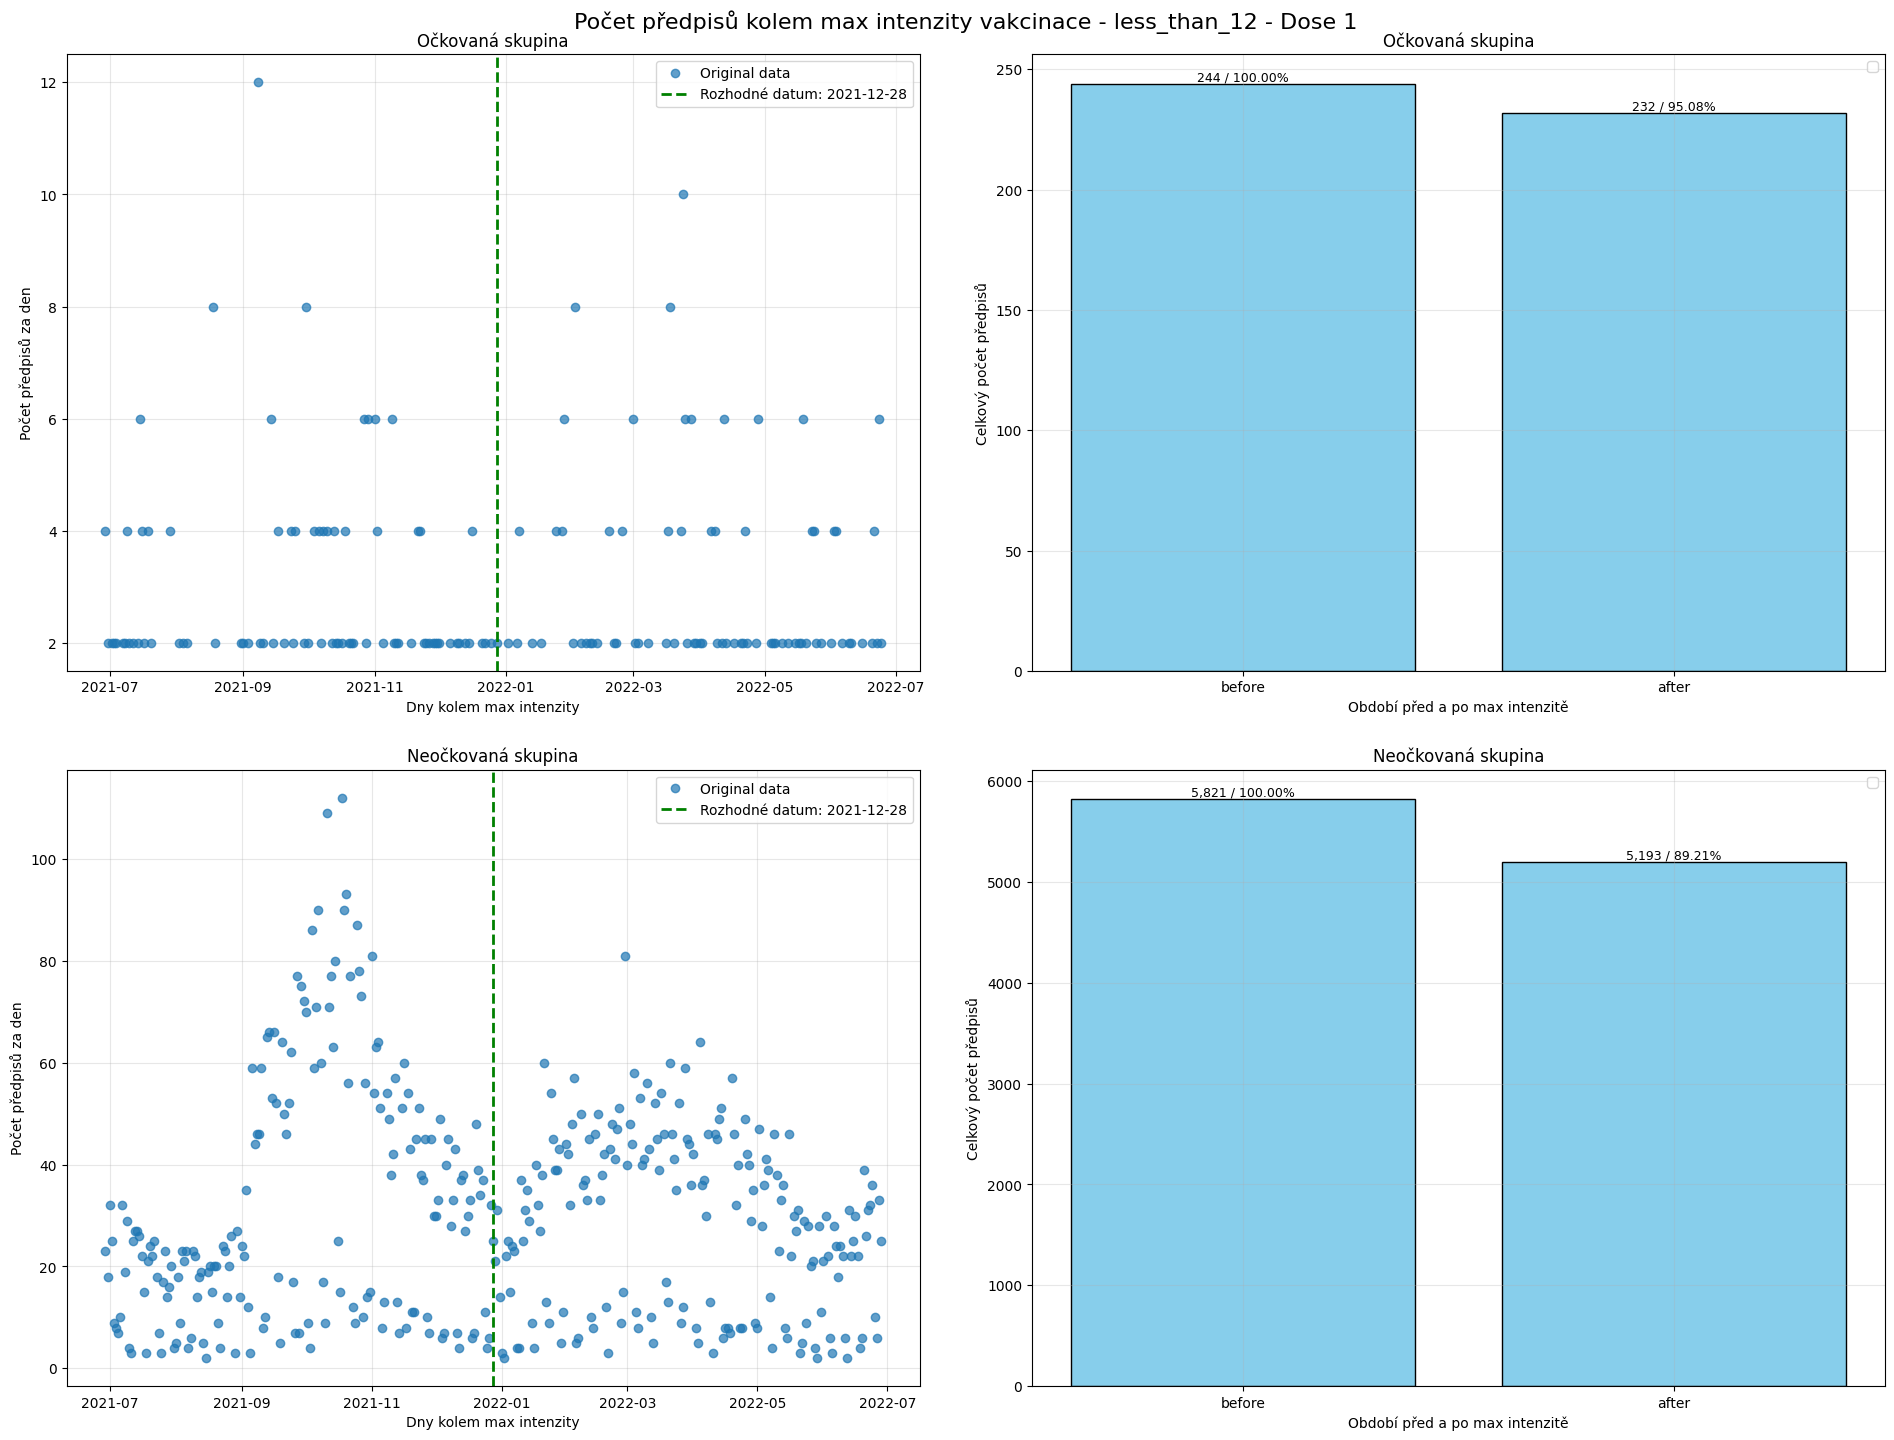

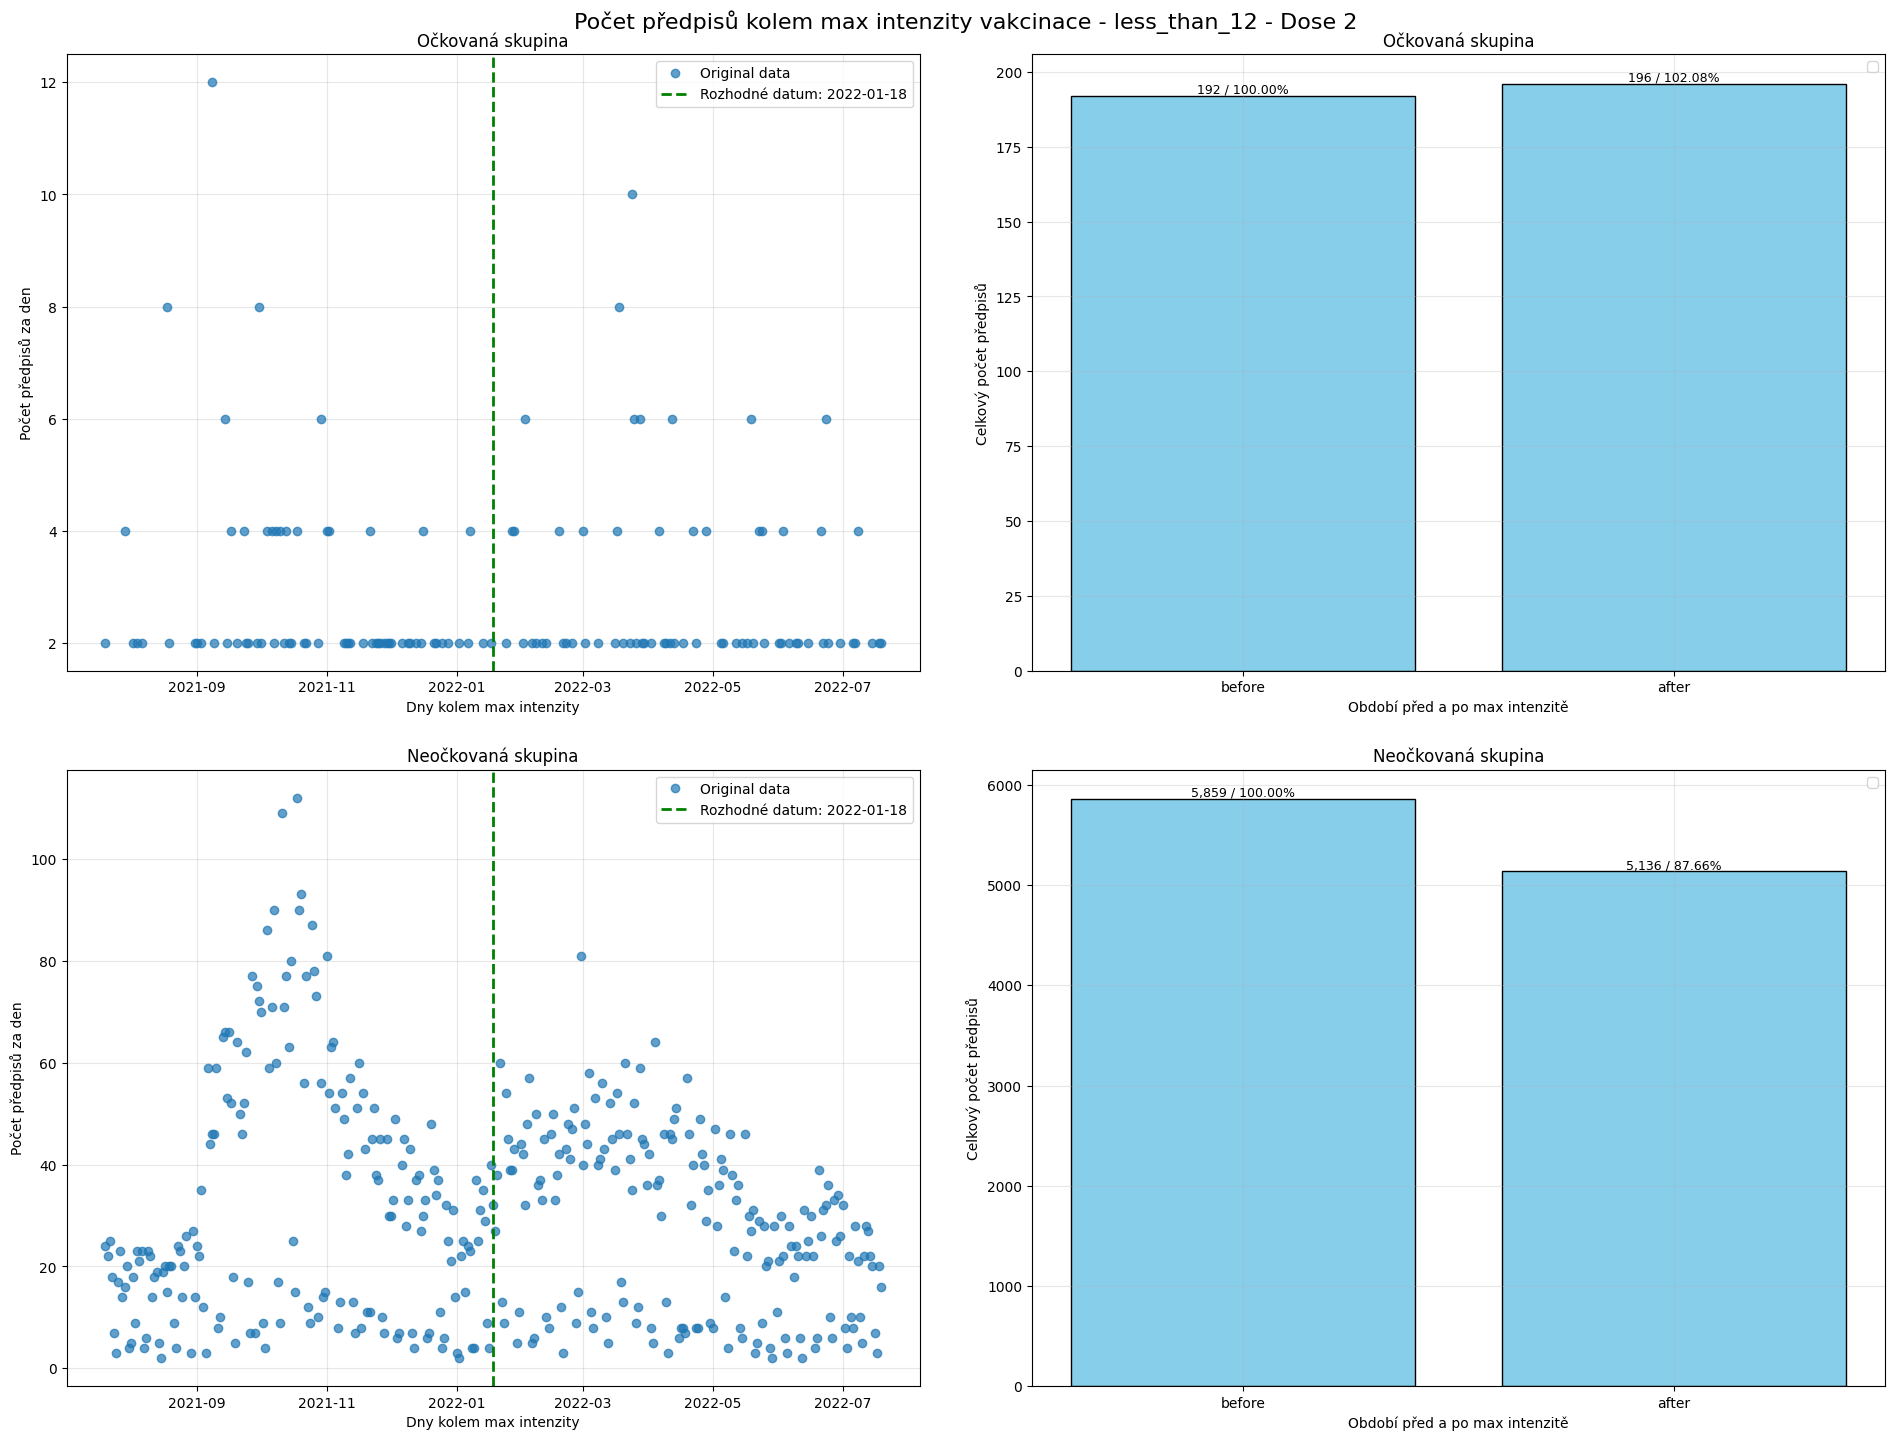

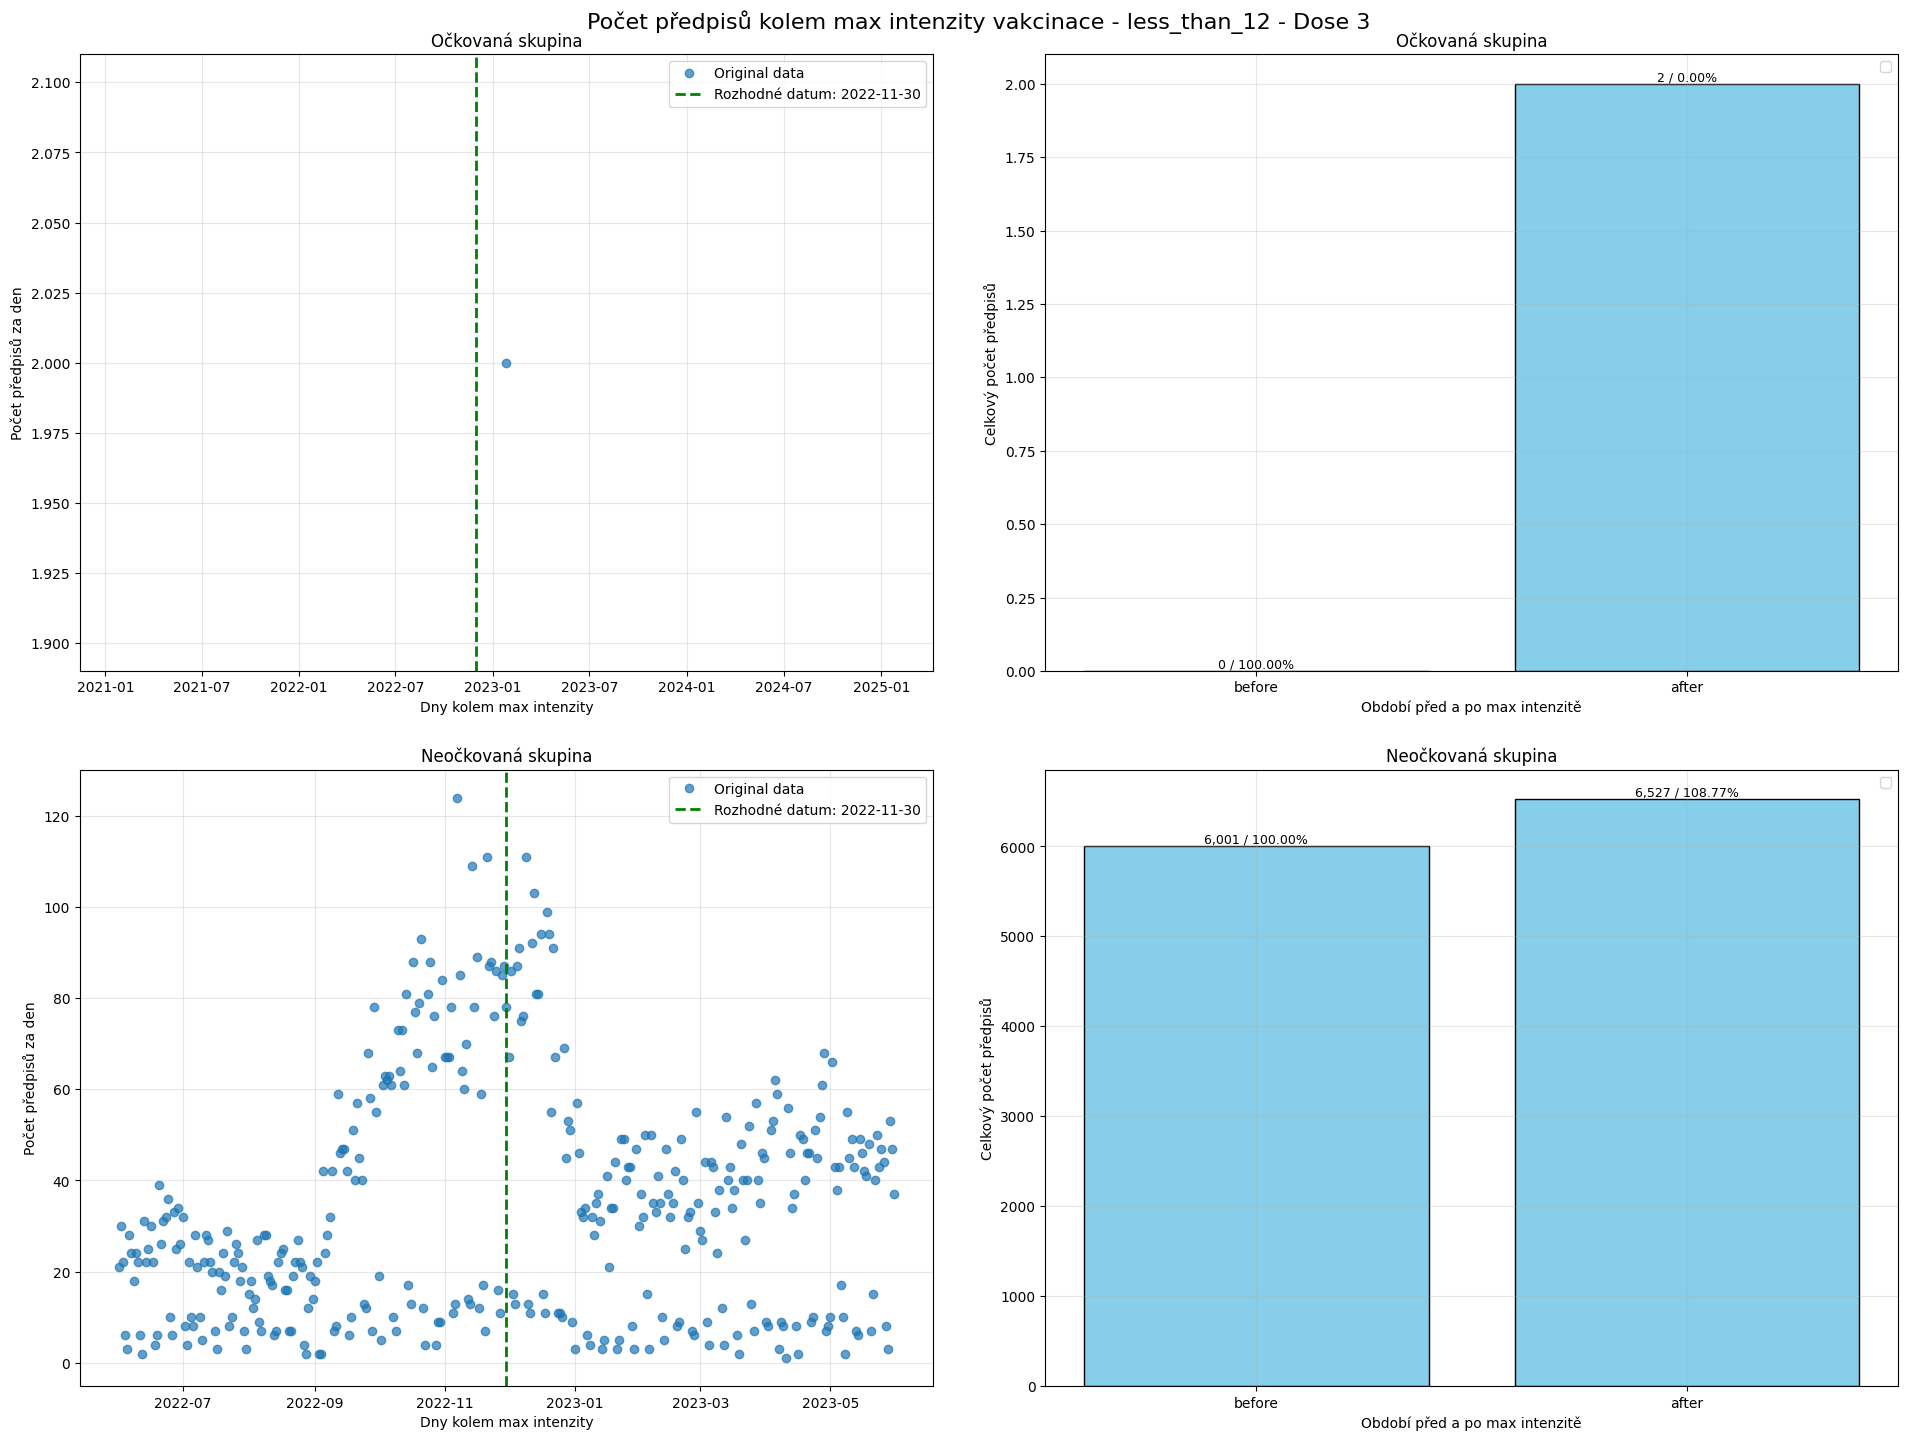

In [13]:
for age_cohort, doses_map in predpisy_map.items():
    for dose_number, dates in doses_map.items():
        if dose_number > 3:
            continue
        # age_cohort = AgeCohort.BETWEEN_12_AND_30
        # dose_number = 1
        vax_dates_map = predpisy_map[age_cohort][dose_number]
        rozhodne_datum = max_vax_dates_map[age_cohort][dose_number]

        novax_dates_map = {
            date: value
            for date, value in nov_vax_ppl_predpisy_map[age_cohort].items()
            if rozhodne_datum - timedelta(days=PRESCRIPTION_PERIOD_IN_DAYS)
            <= date
            <= rozhodne_datum + timedelta(days=PRESCRIPTION_PERIOD_IN_DAYS)
        }

        ChartDrawer().draw_chart(
            vax_dates_map,
            novax_dates_map,
            rozhodne_datum,
            f"Počet předpisů kolem max intenzity vakcinace - {age_cohort.value} - Dose {dose_number}",
        )

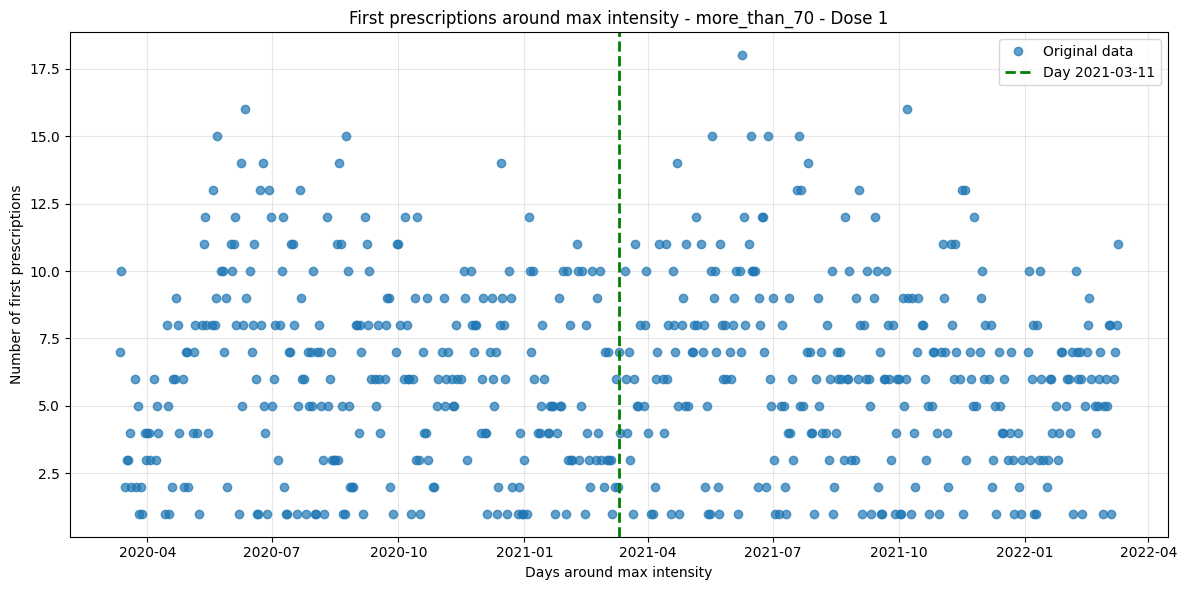

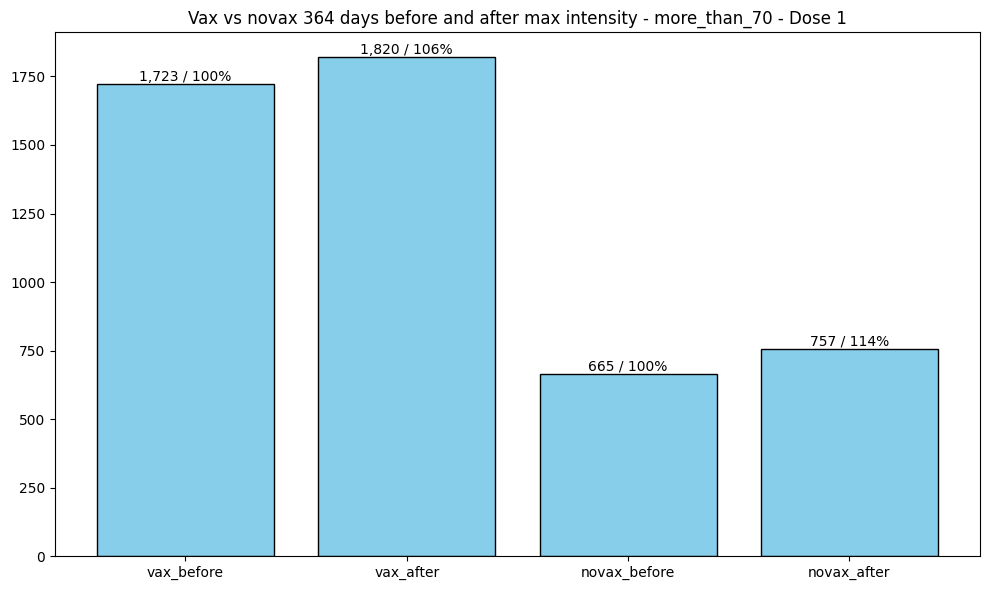

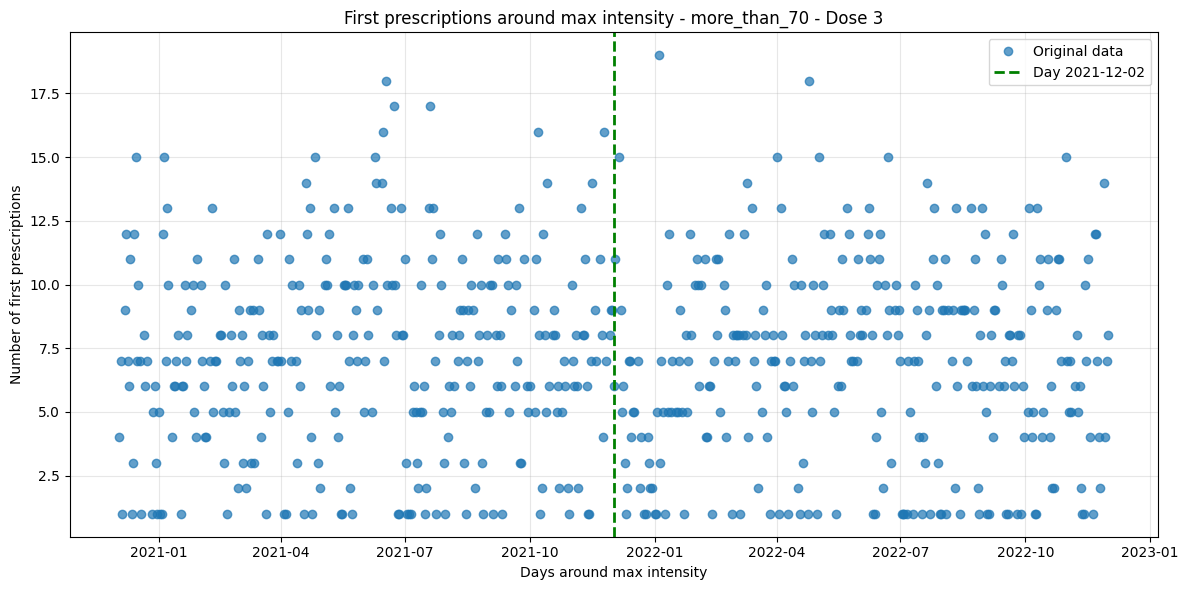

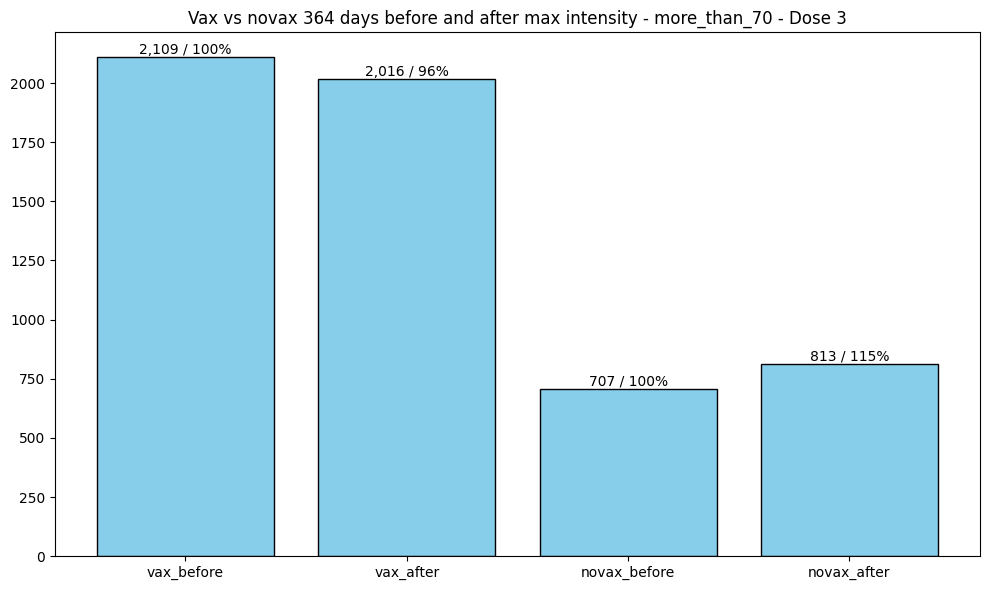

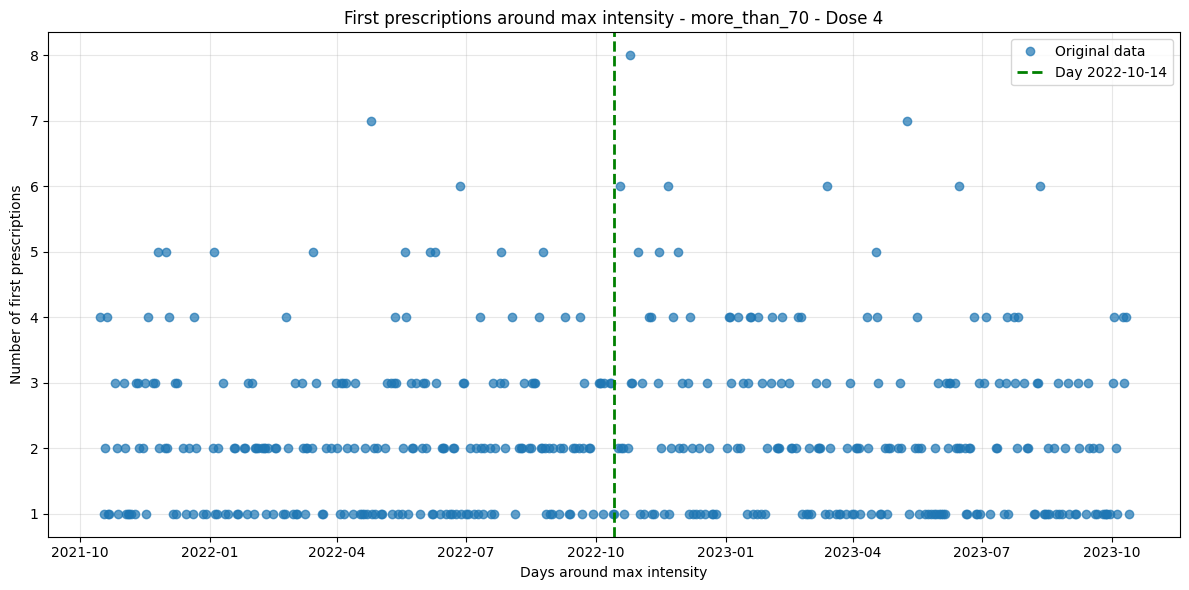

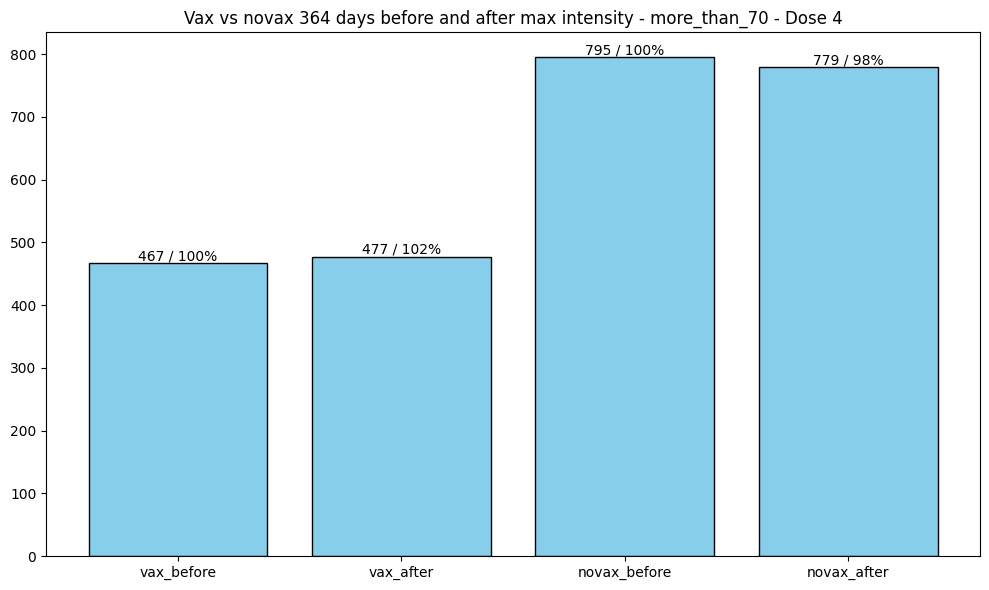

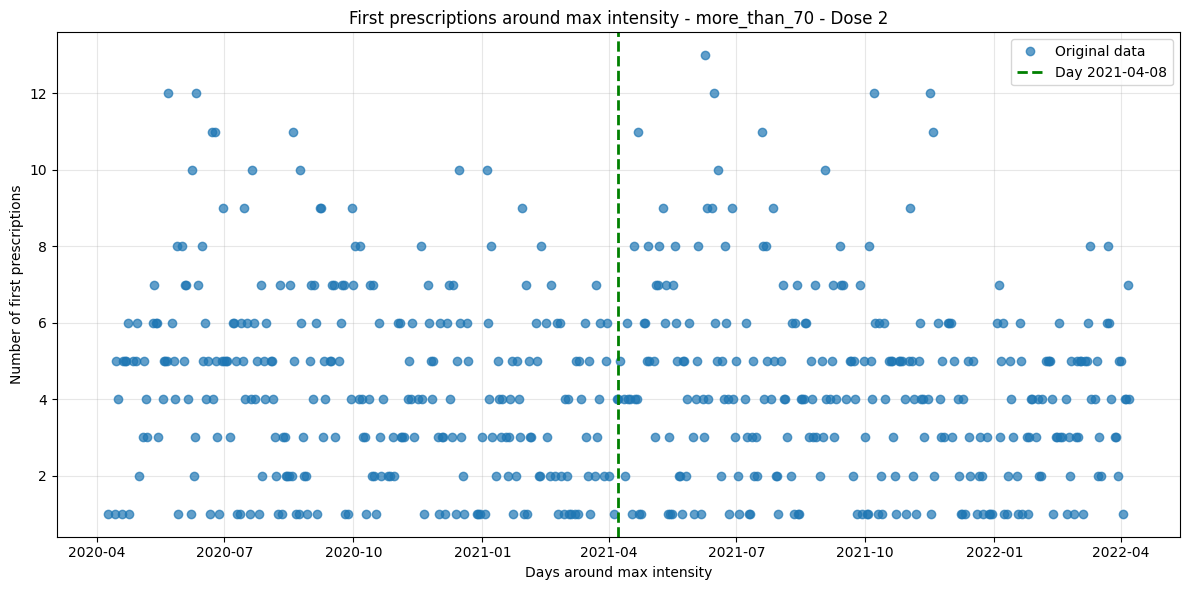

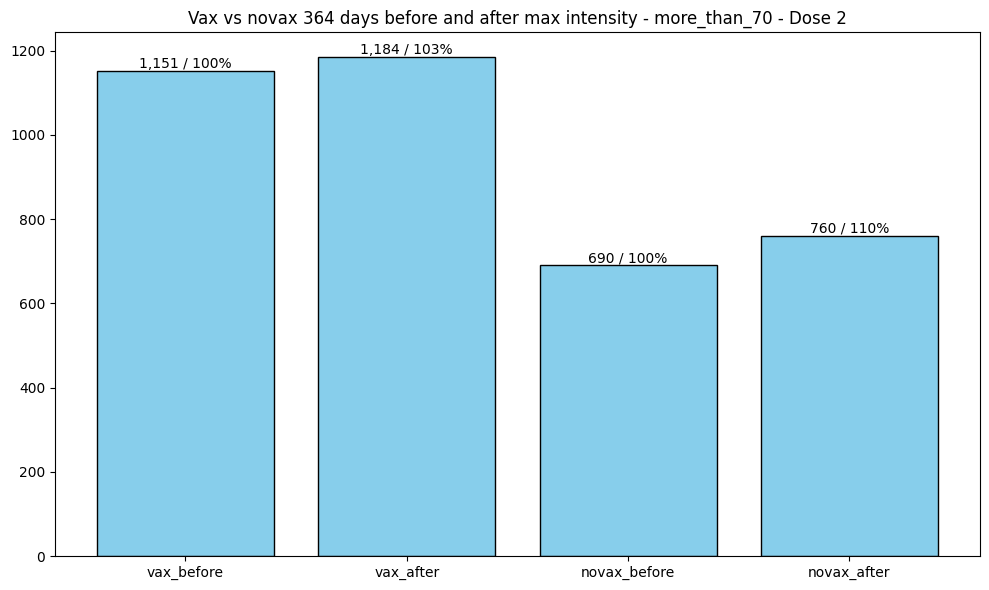

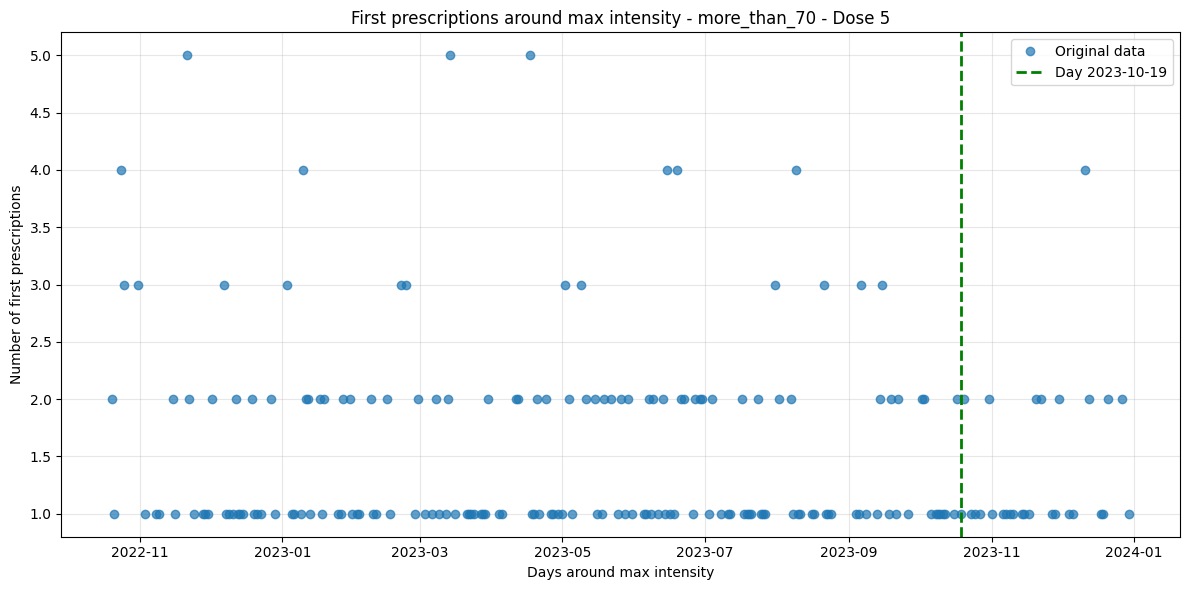

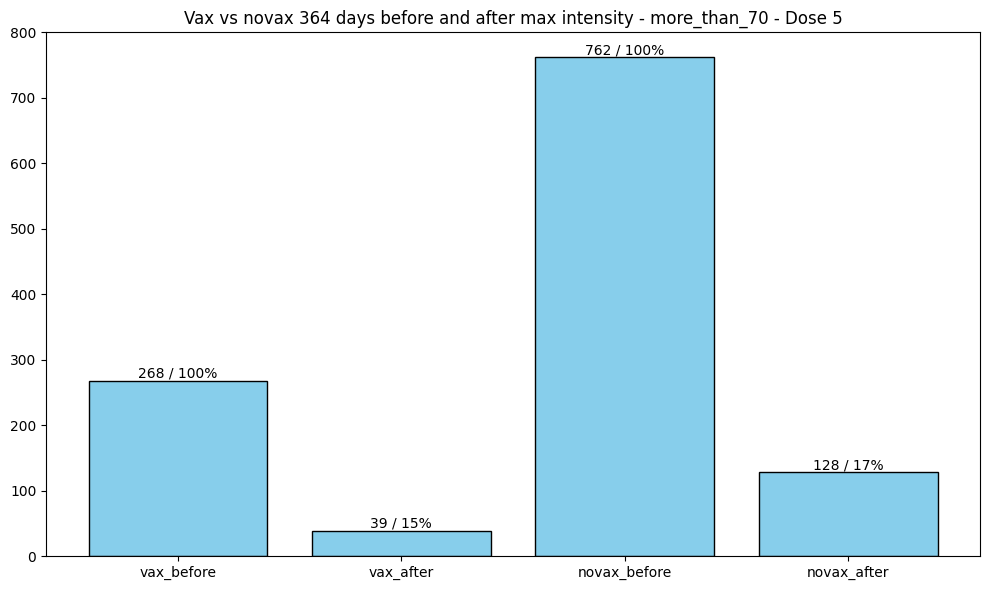

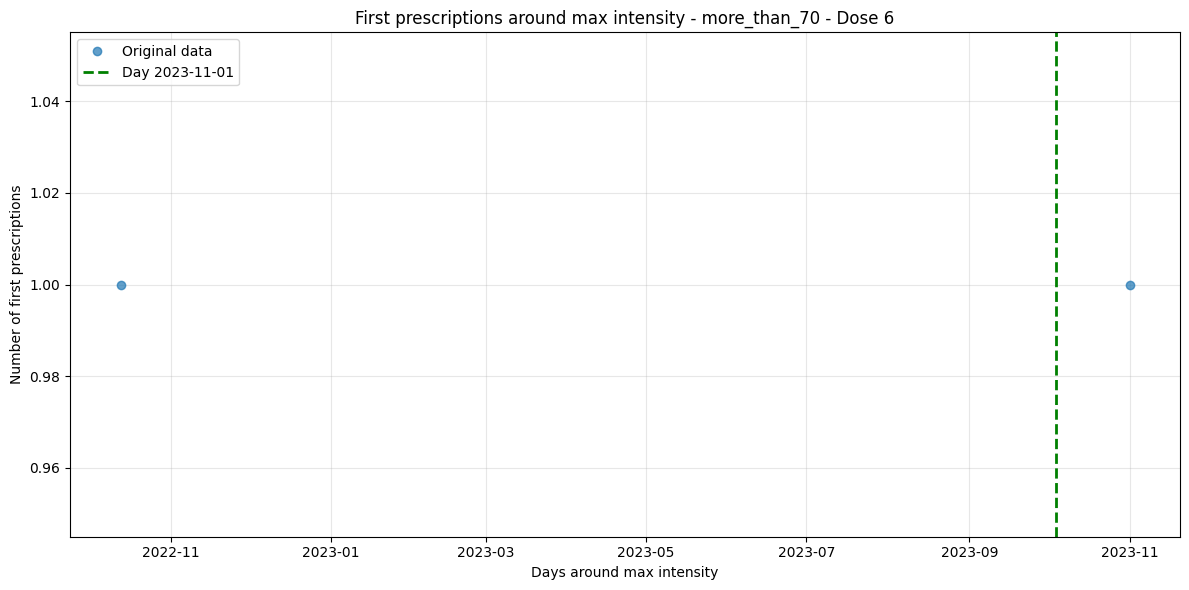

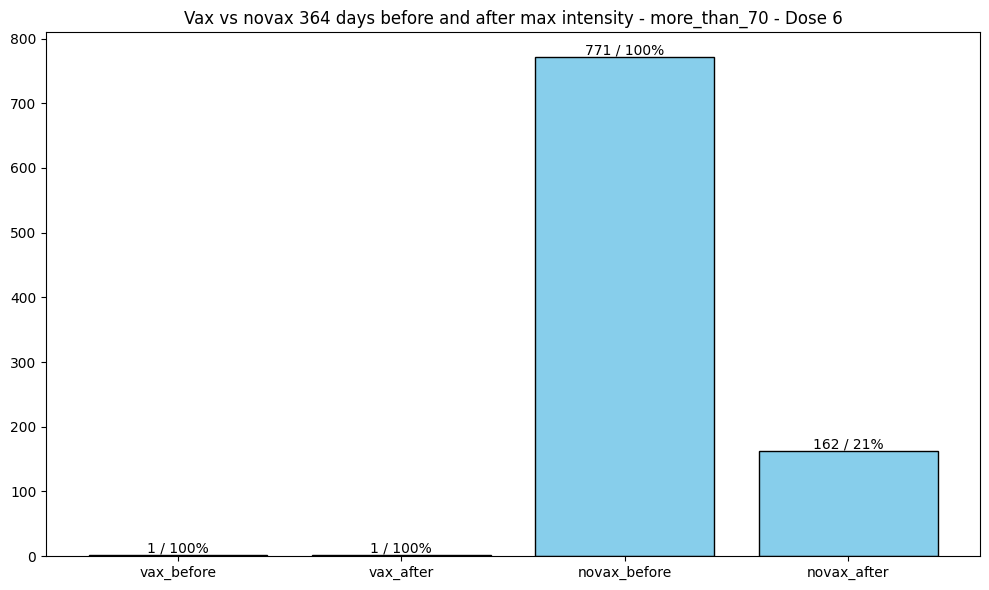

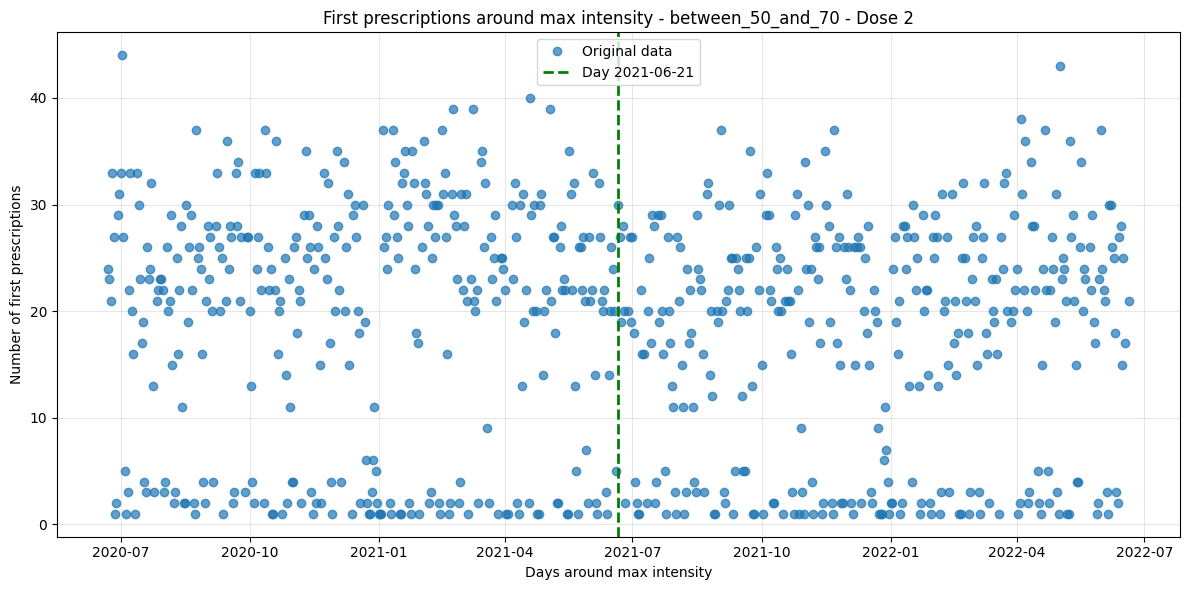

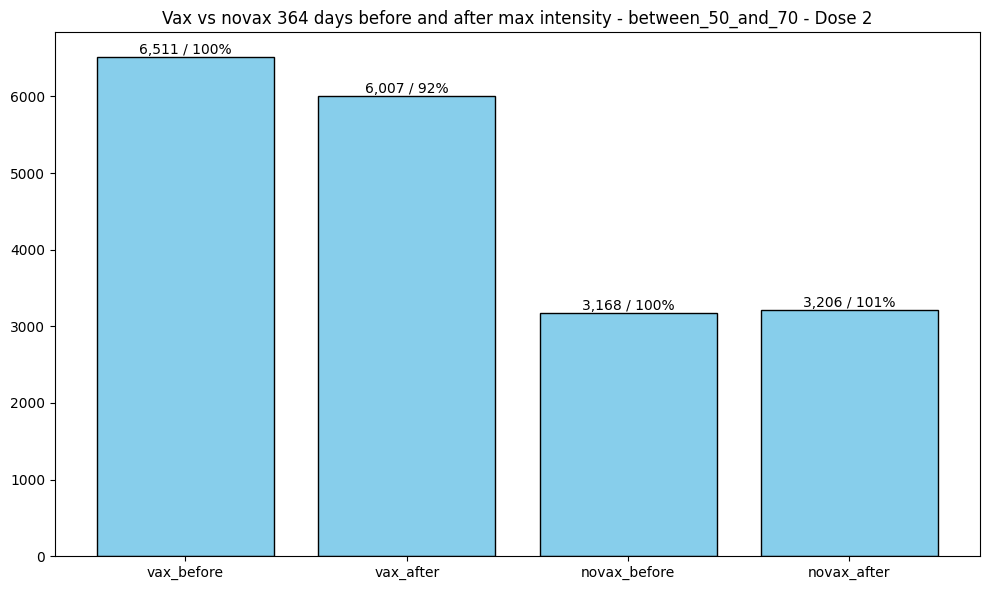

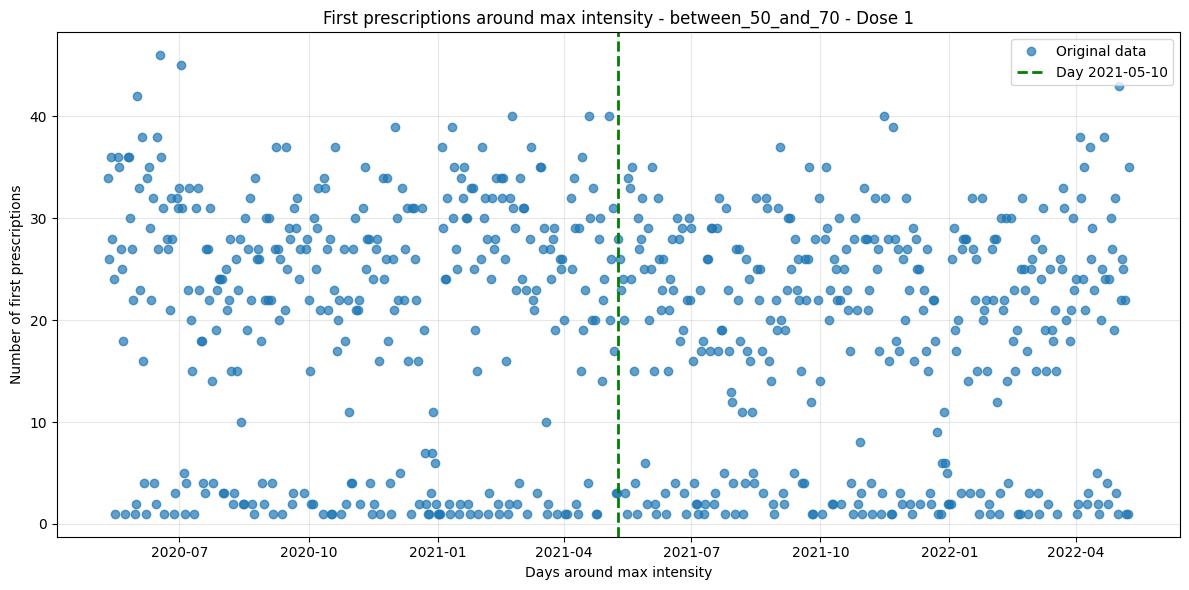

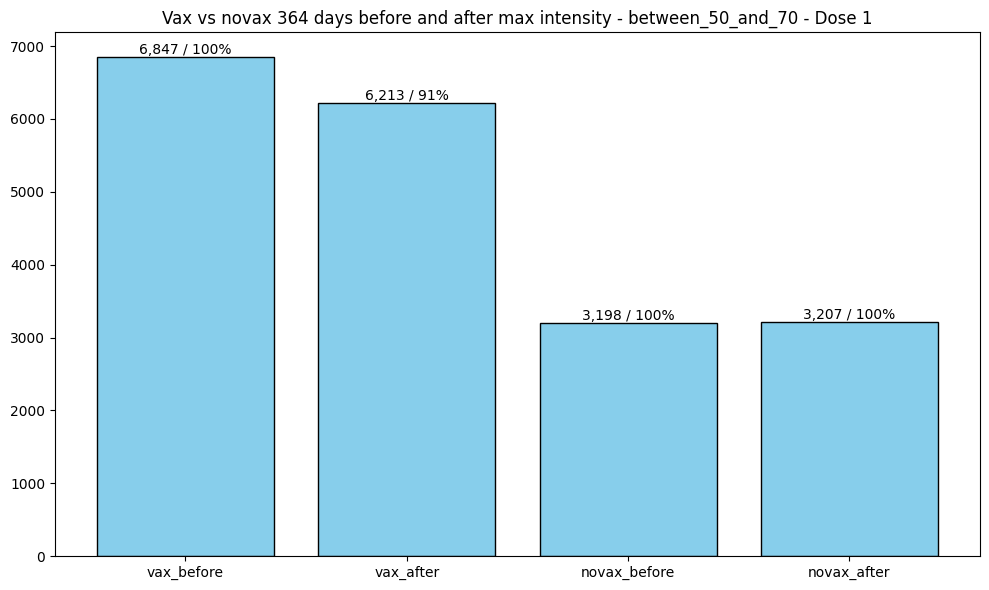

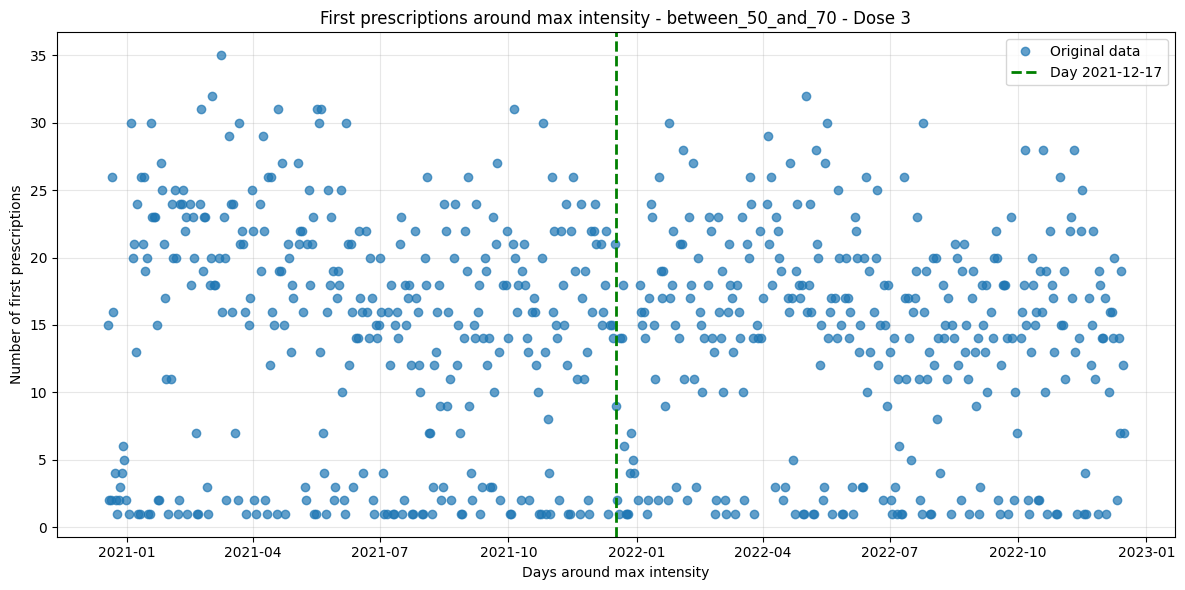

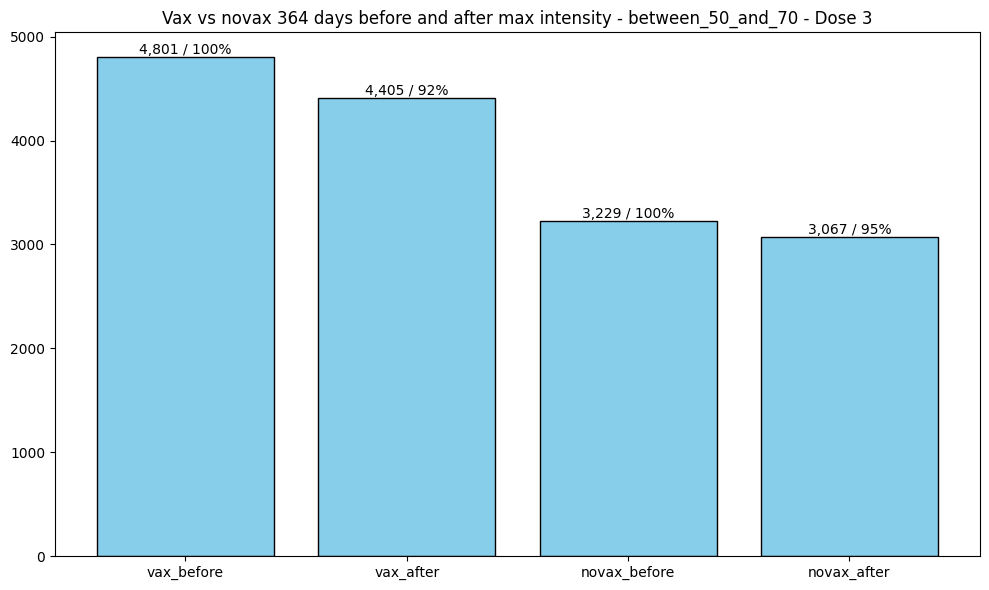

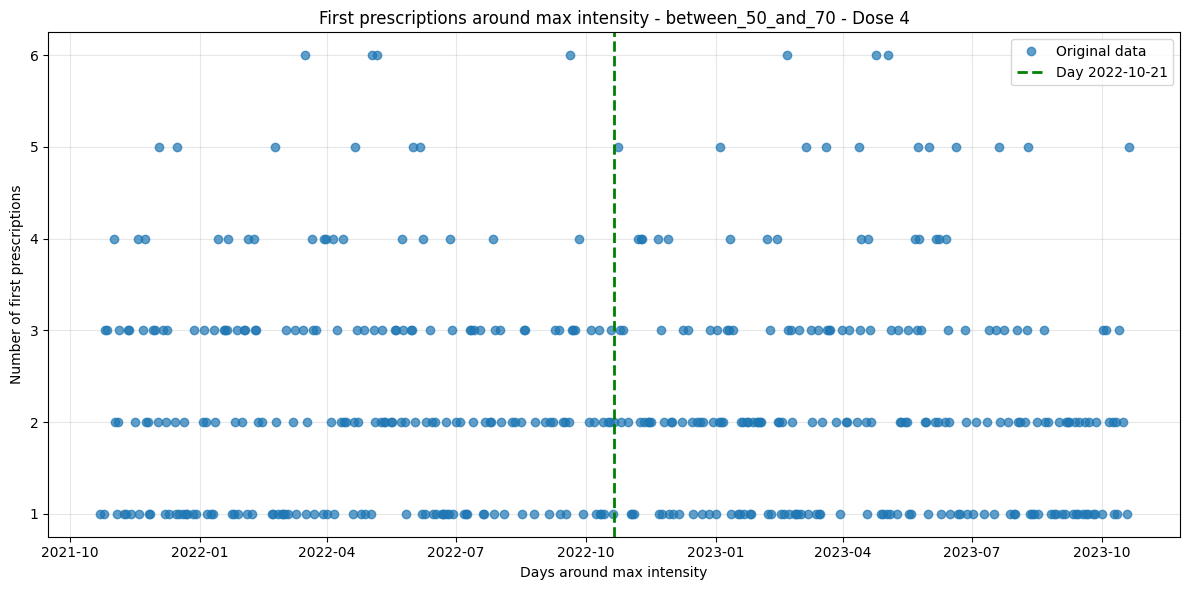

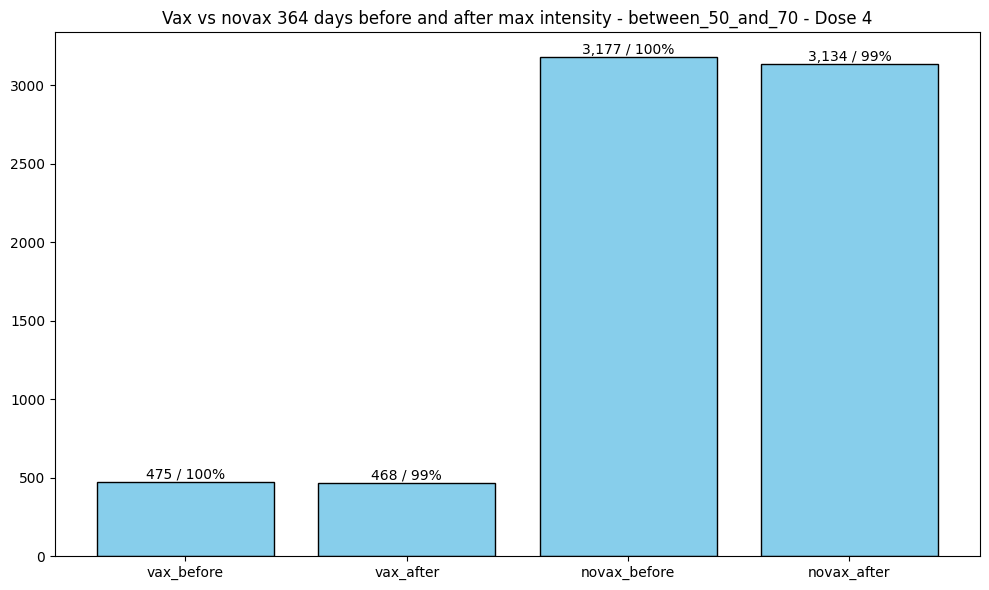

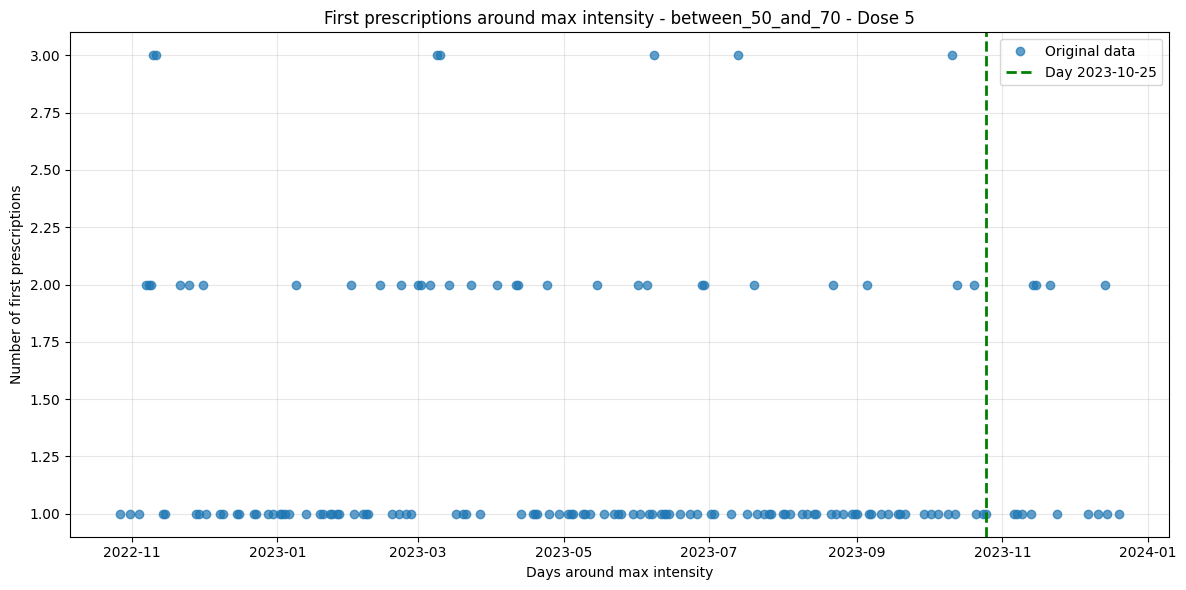

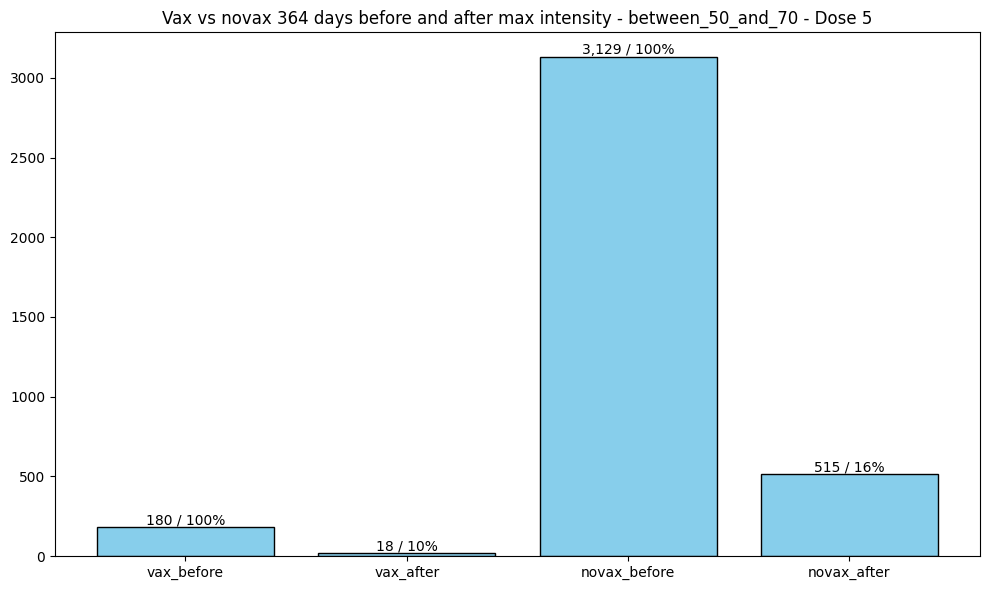

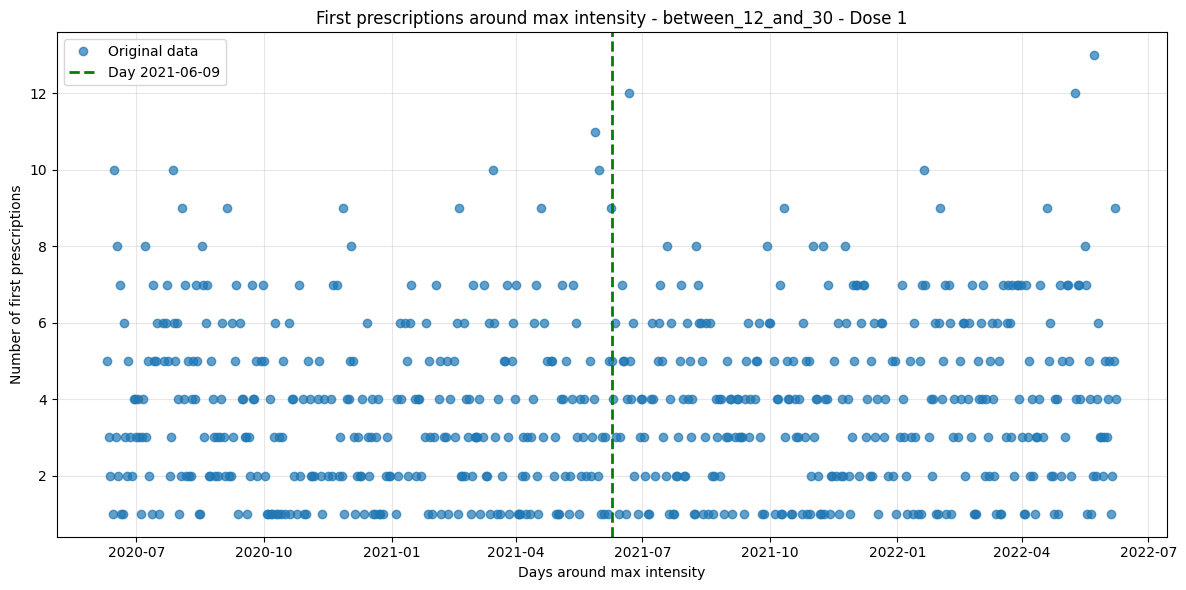

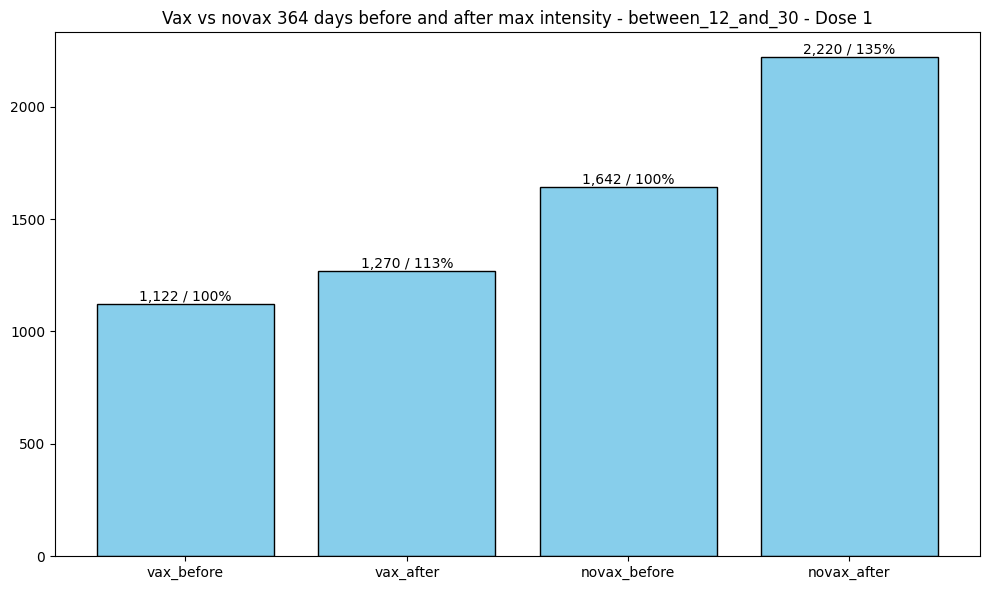

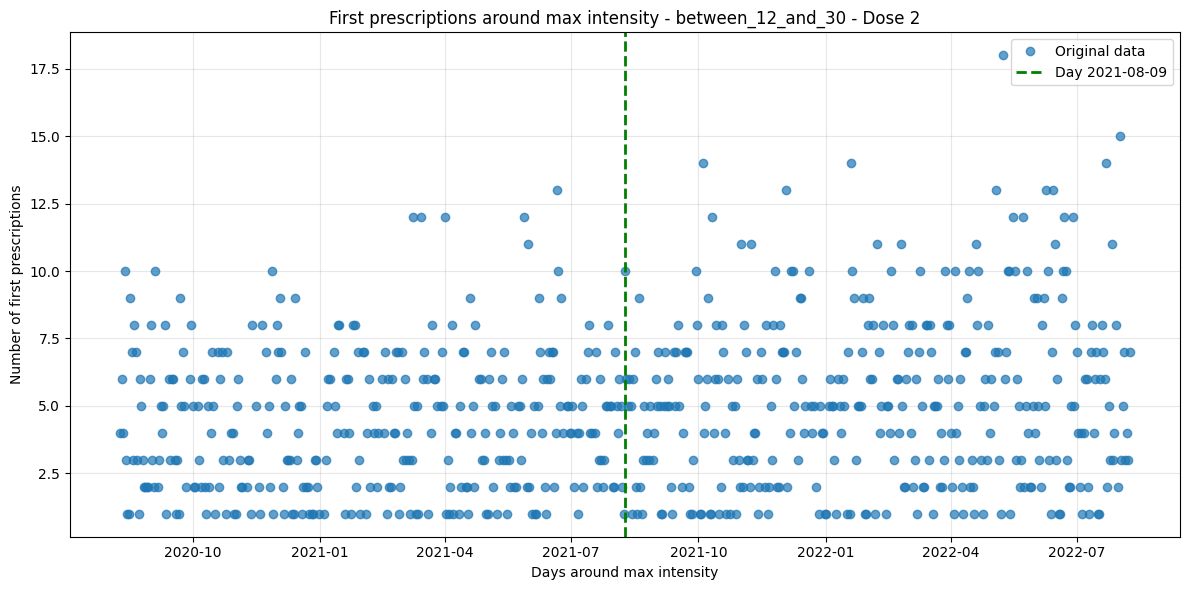

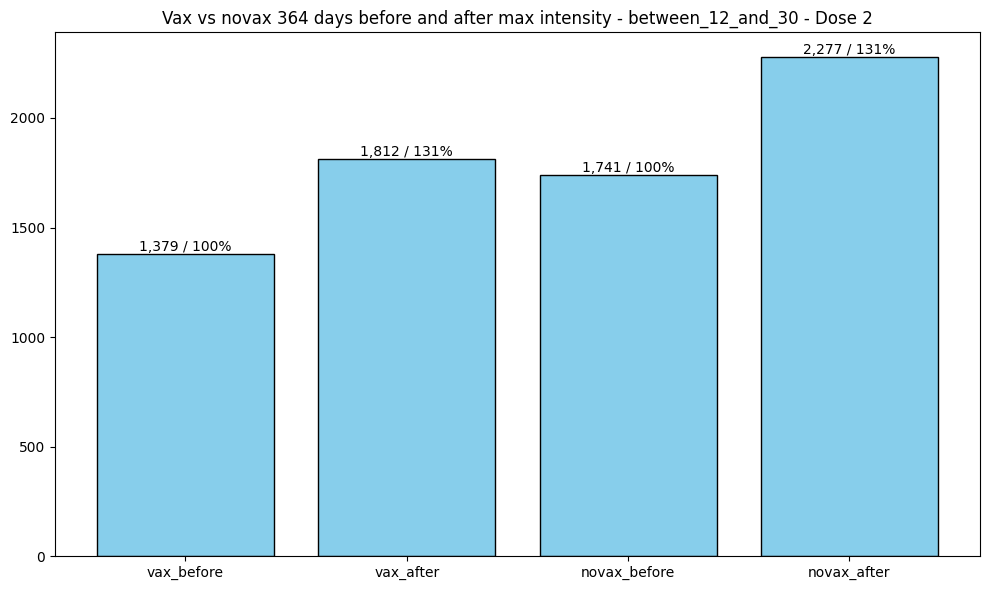

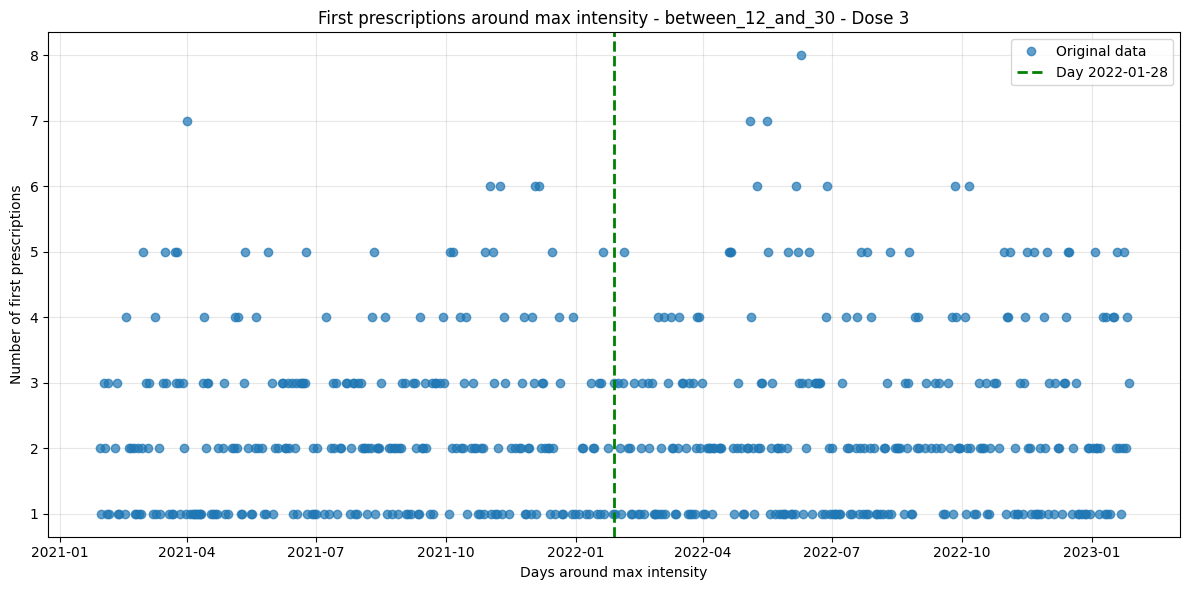

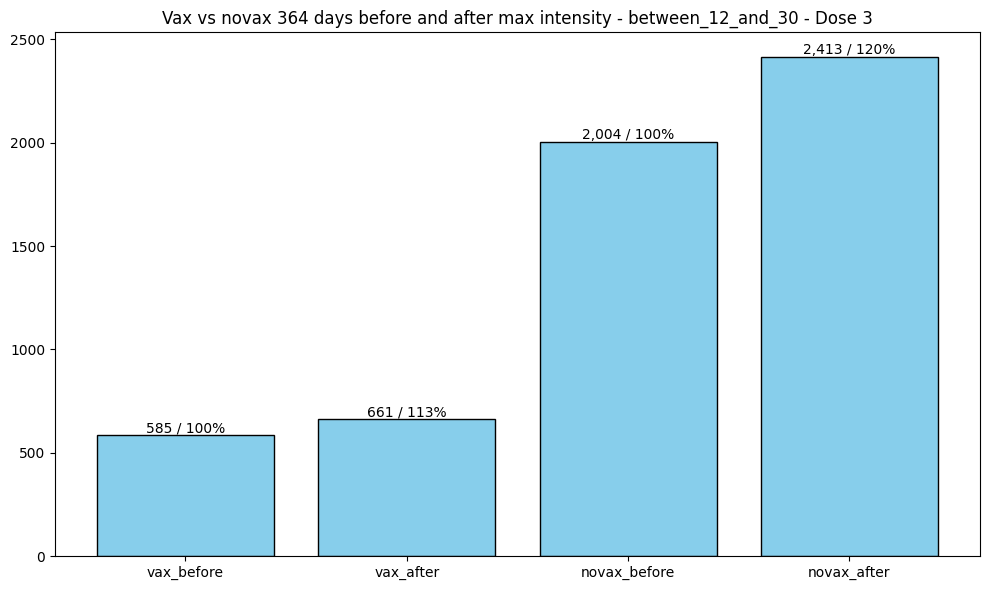

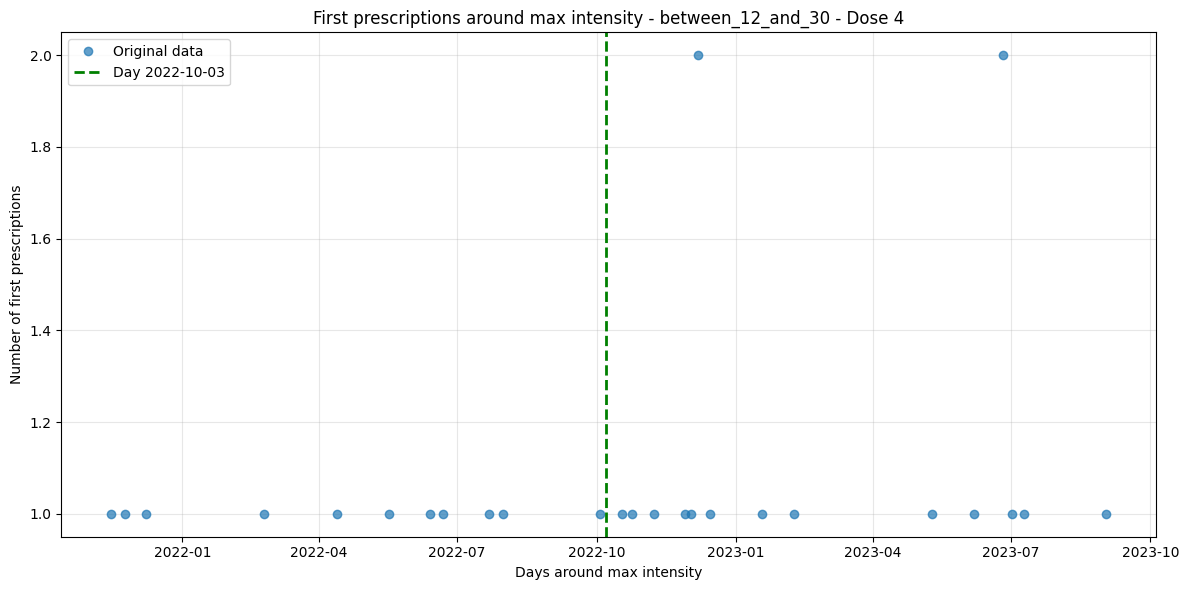

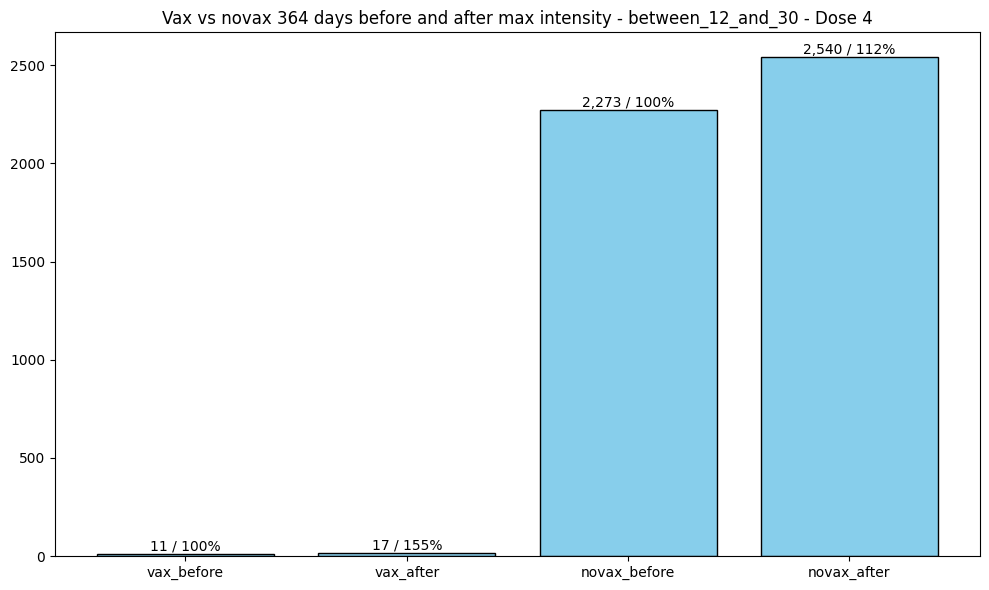

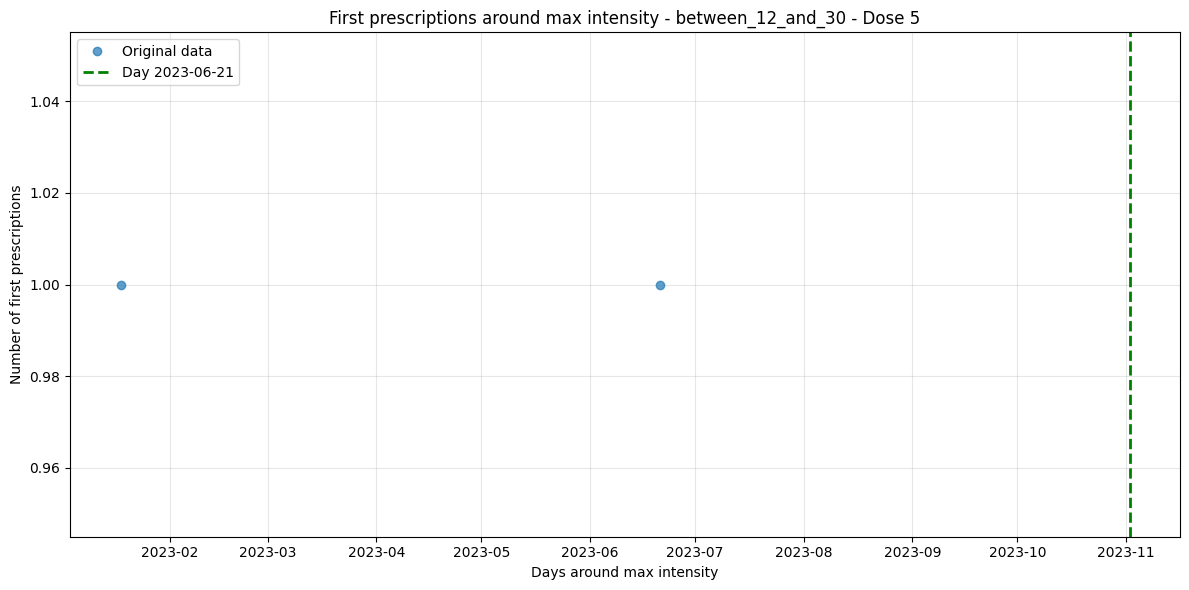

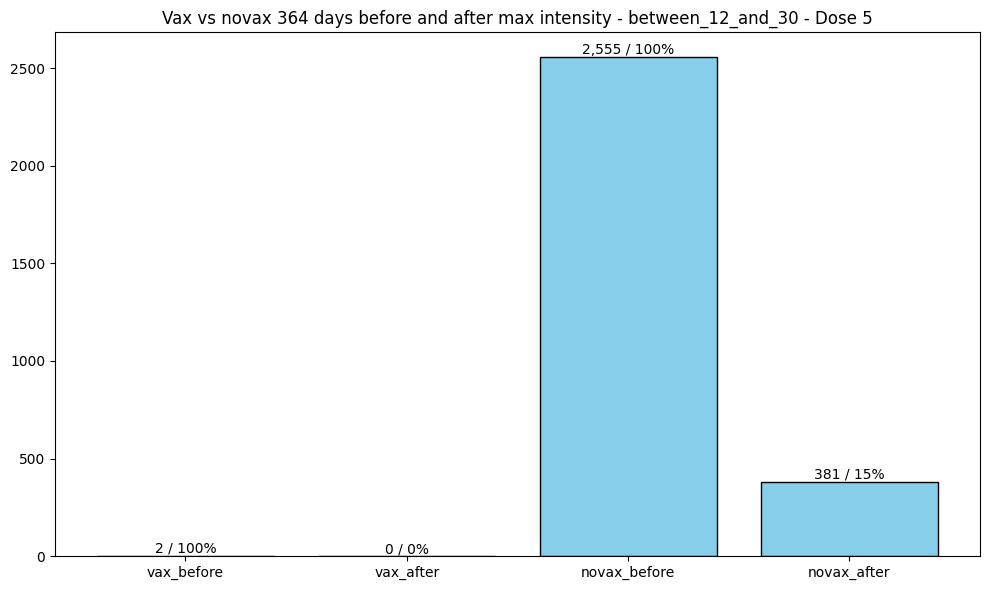

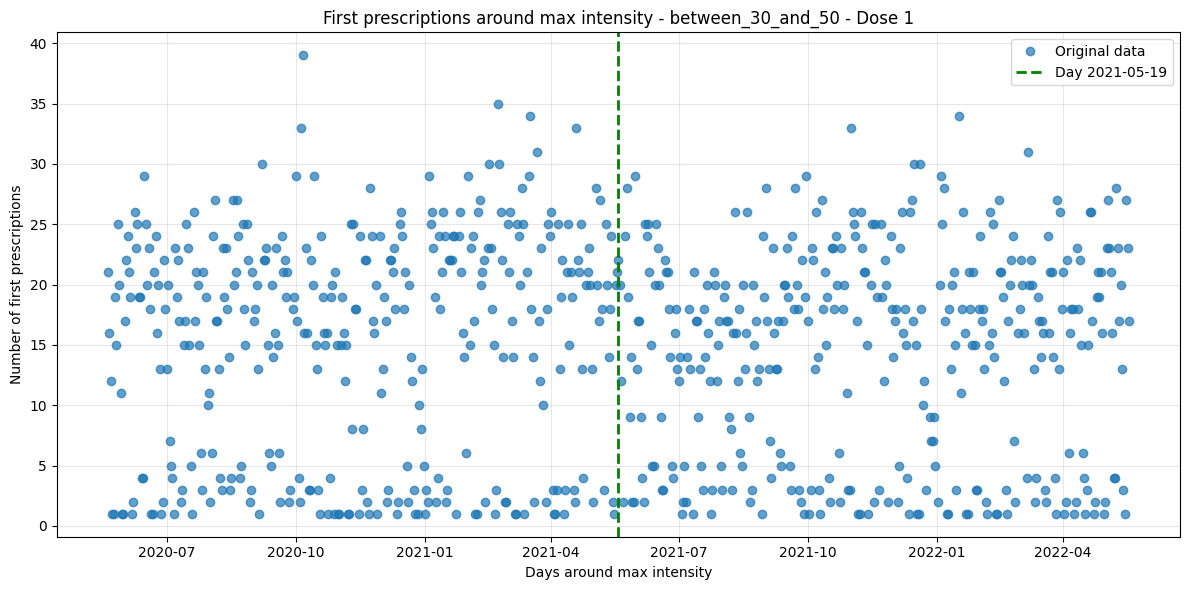

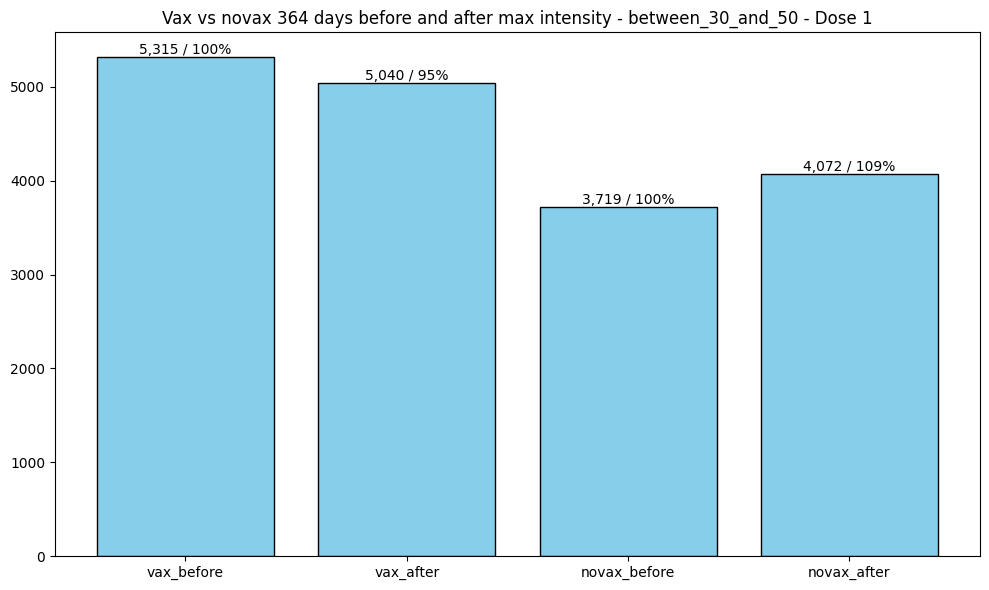

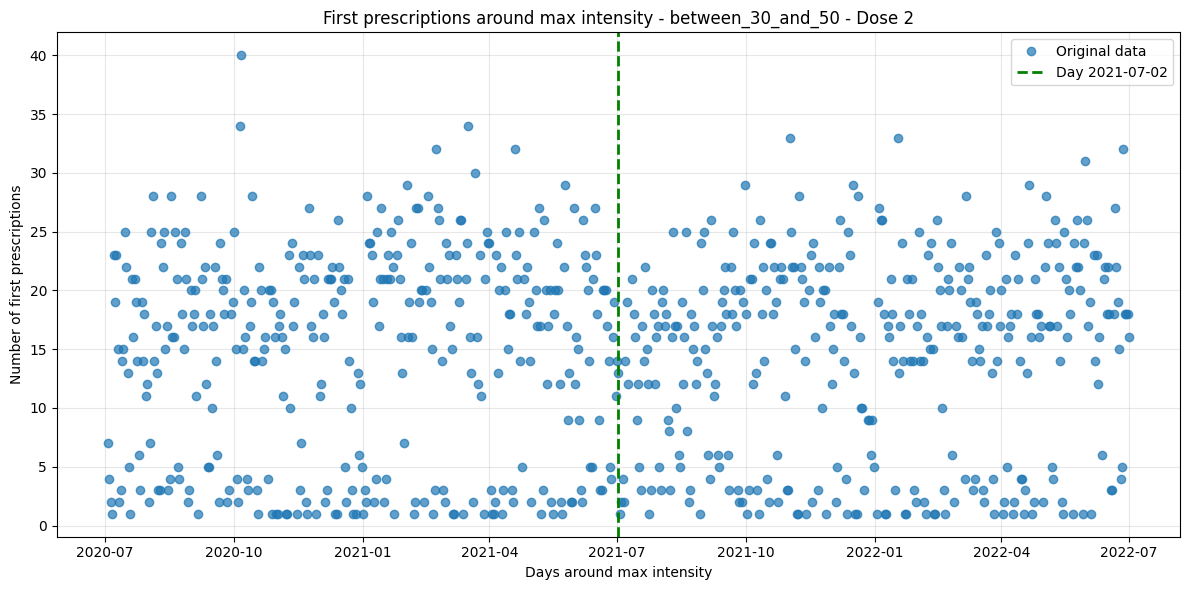

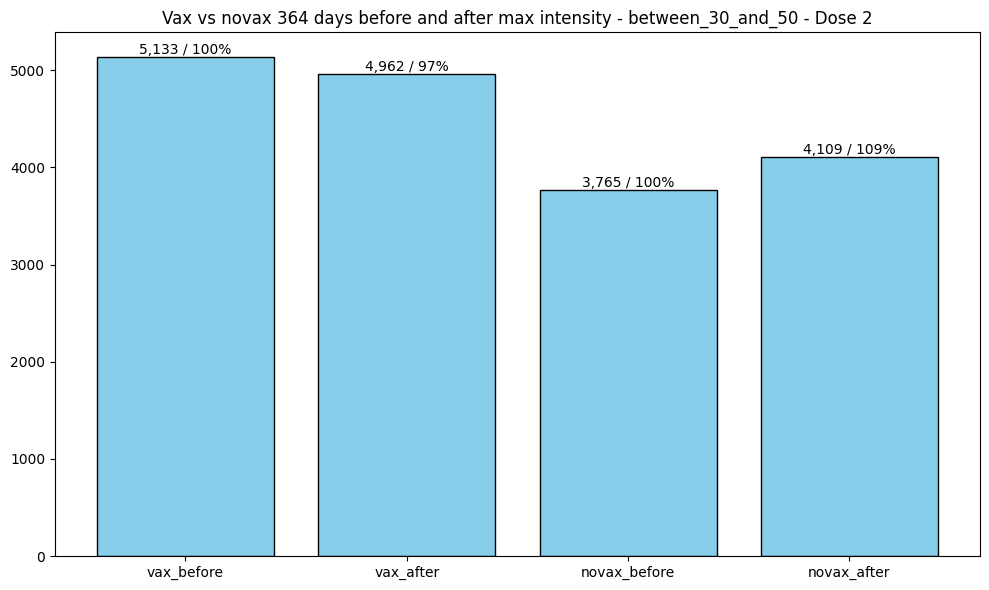

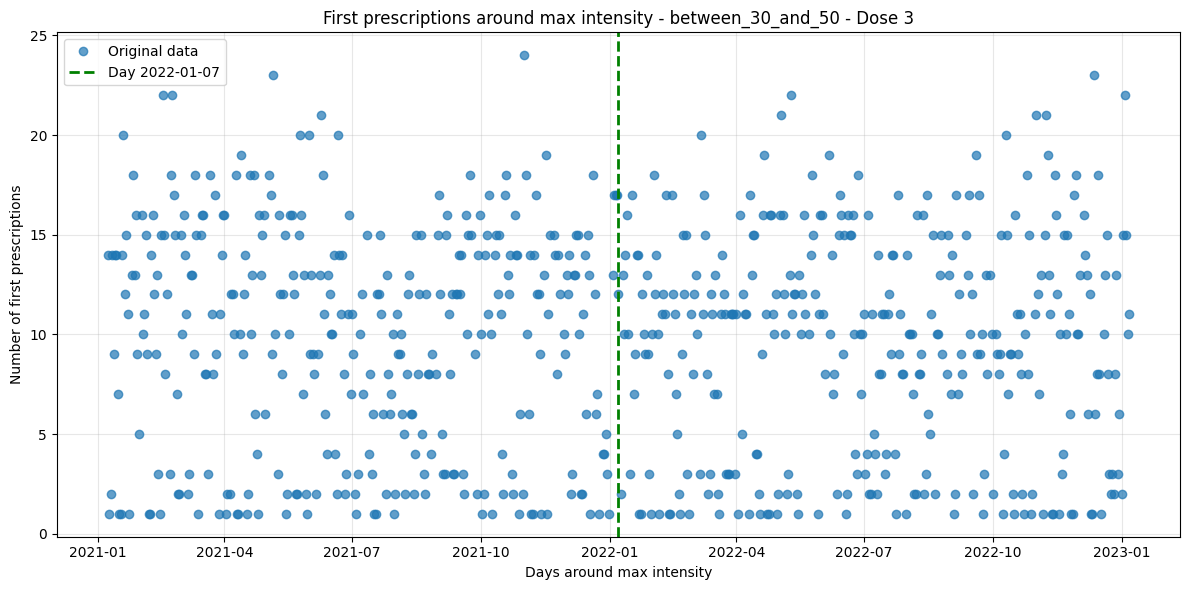

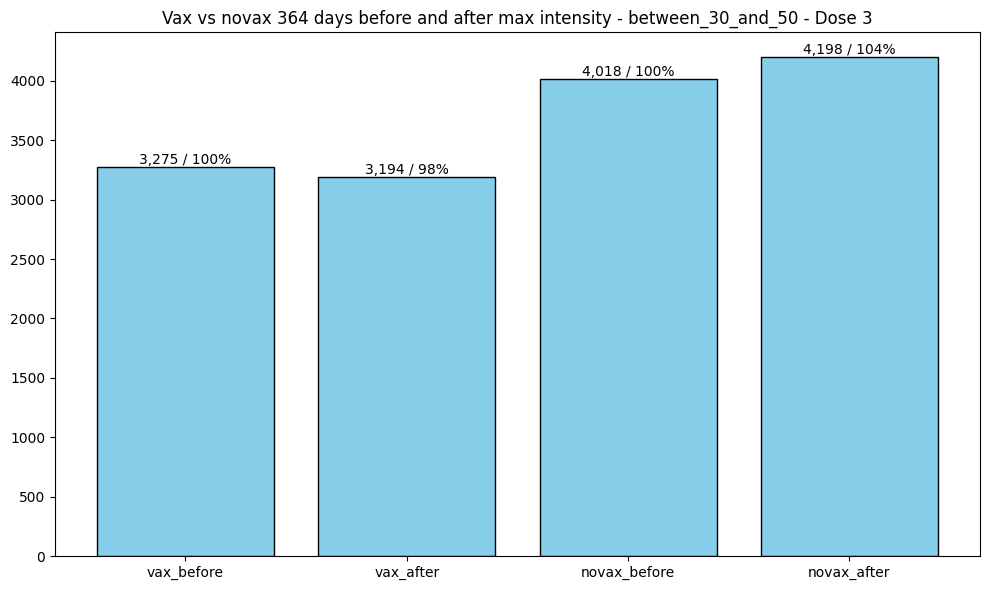

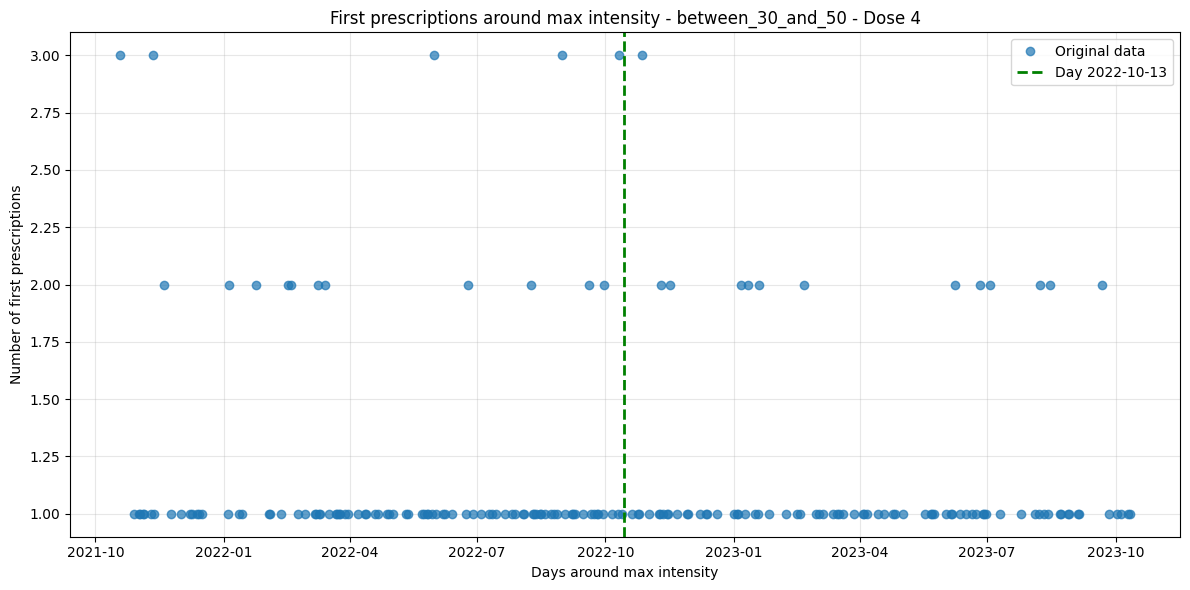

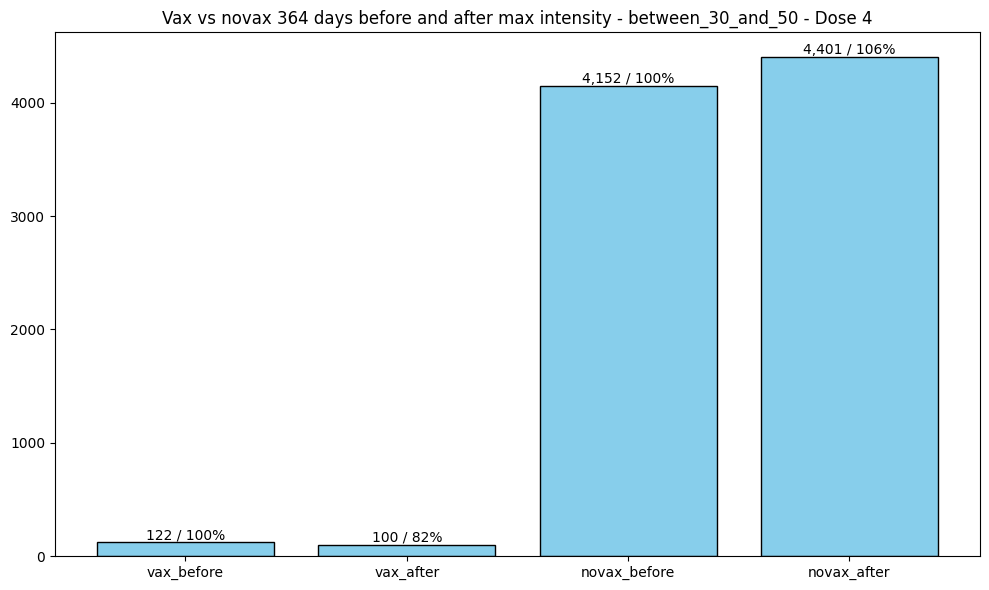

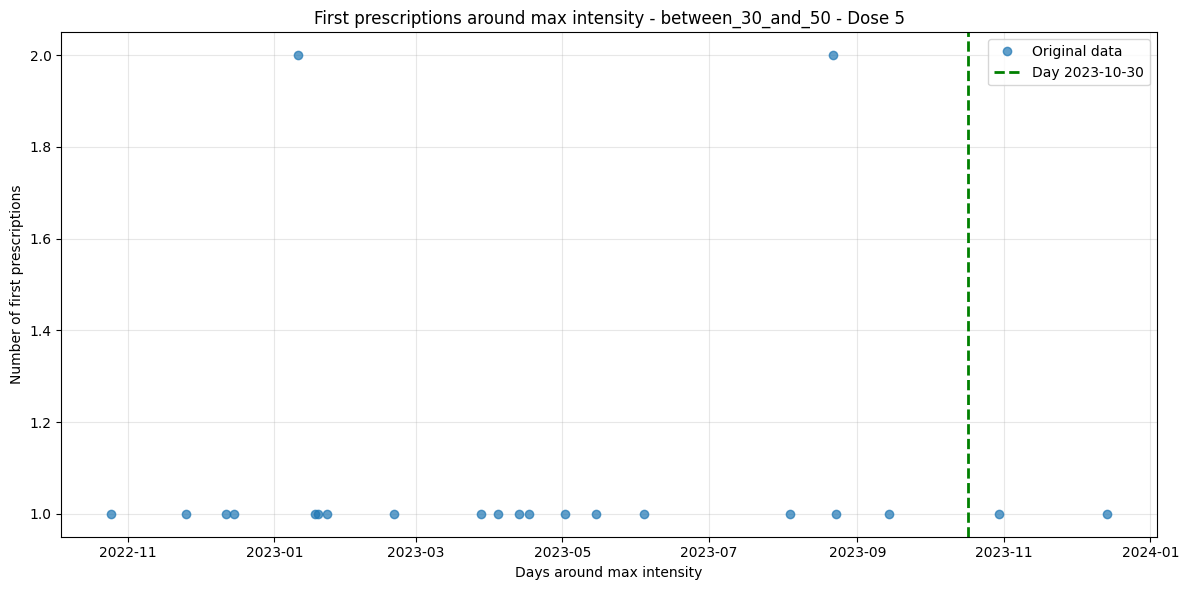

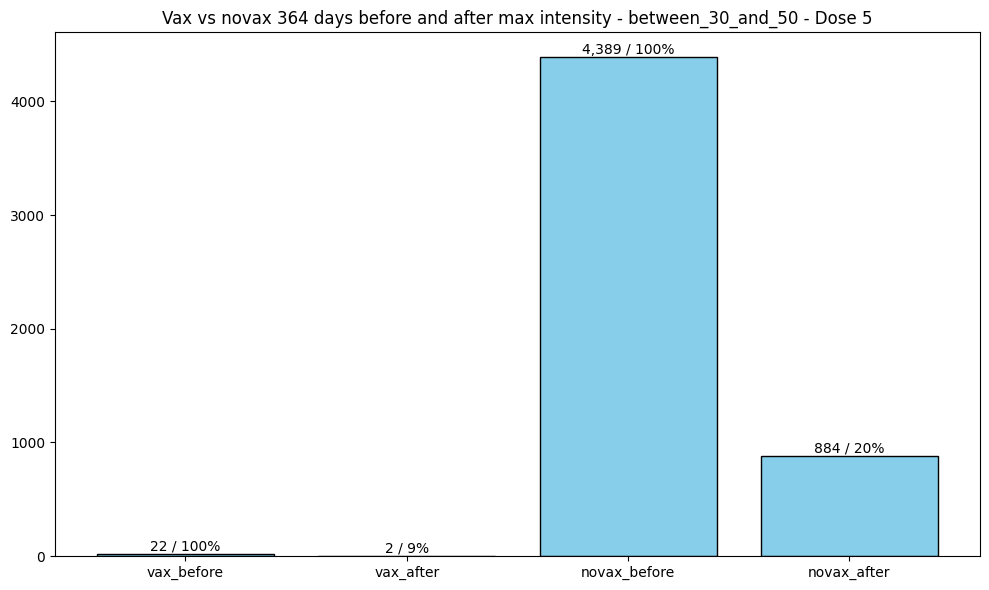

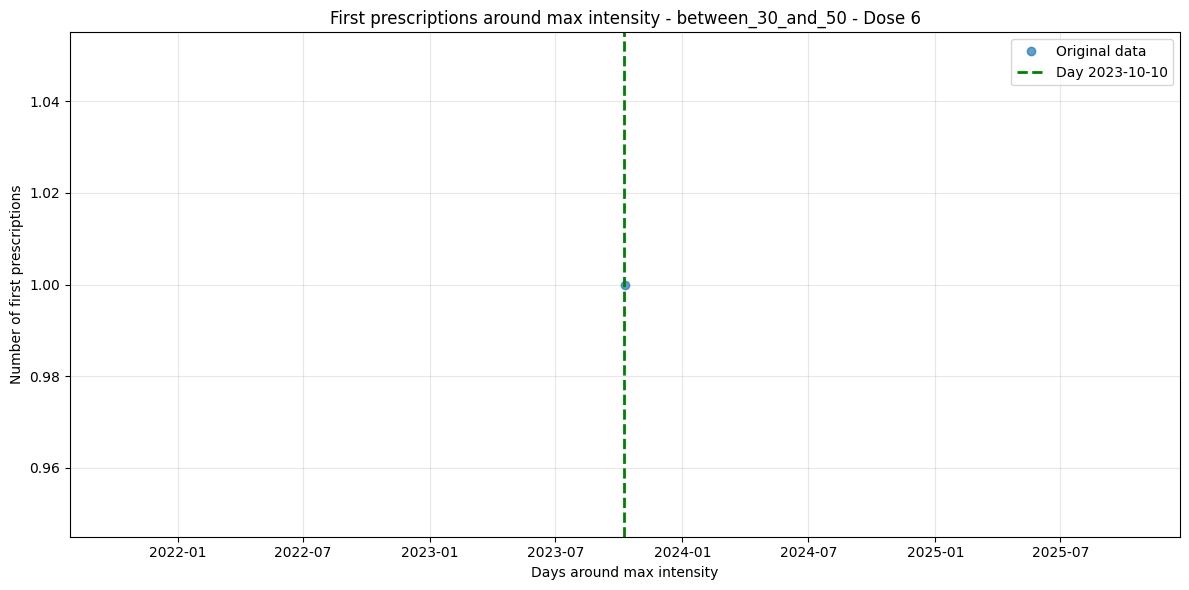

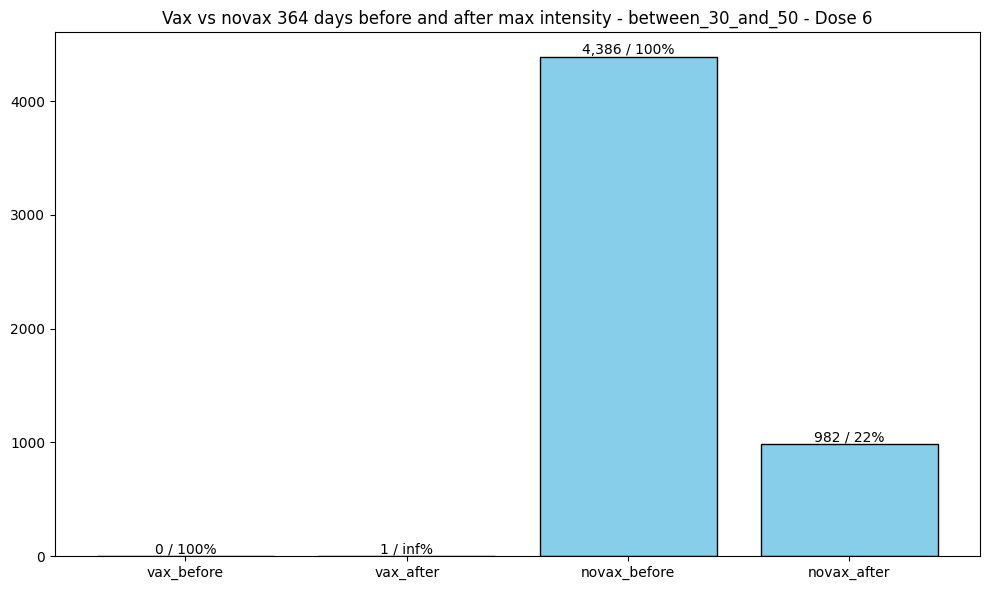

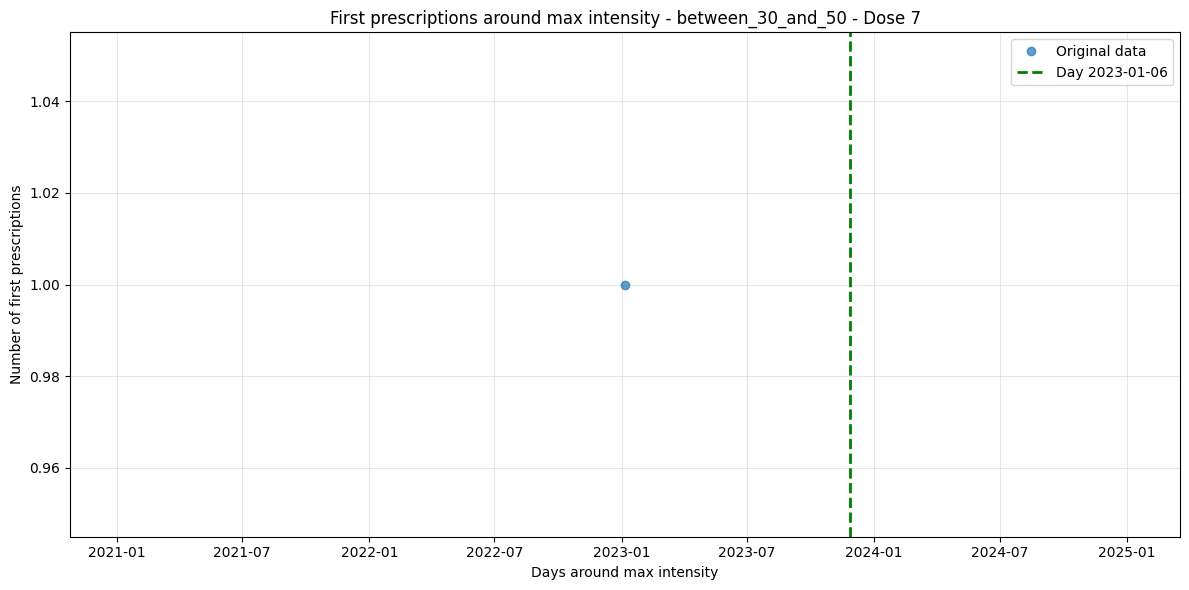

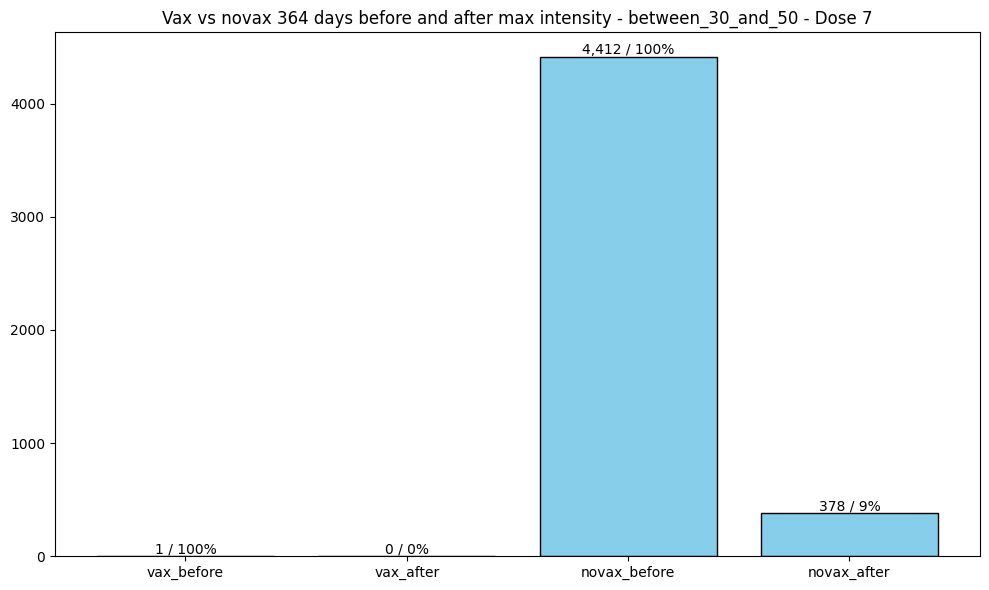

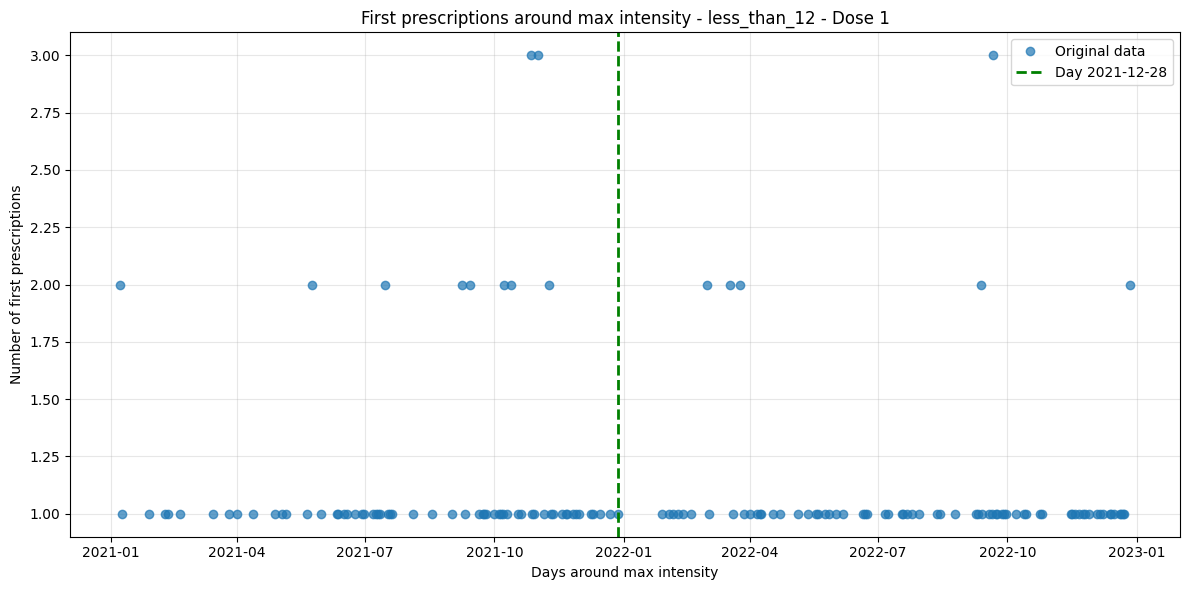

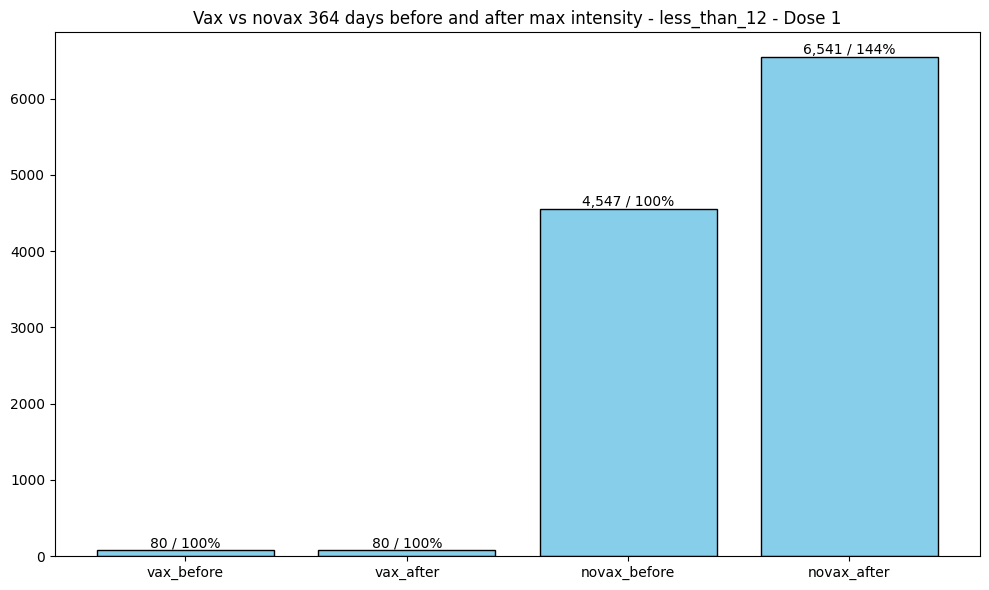

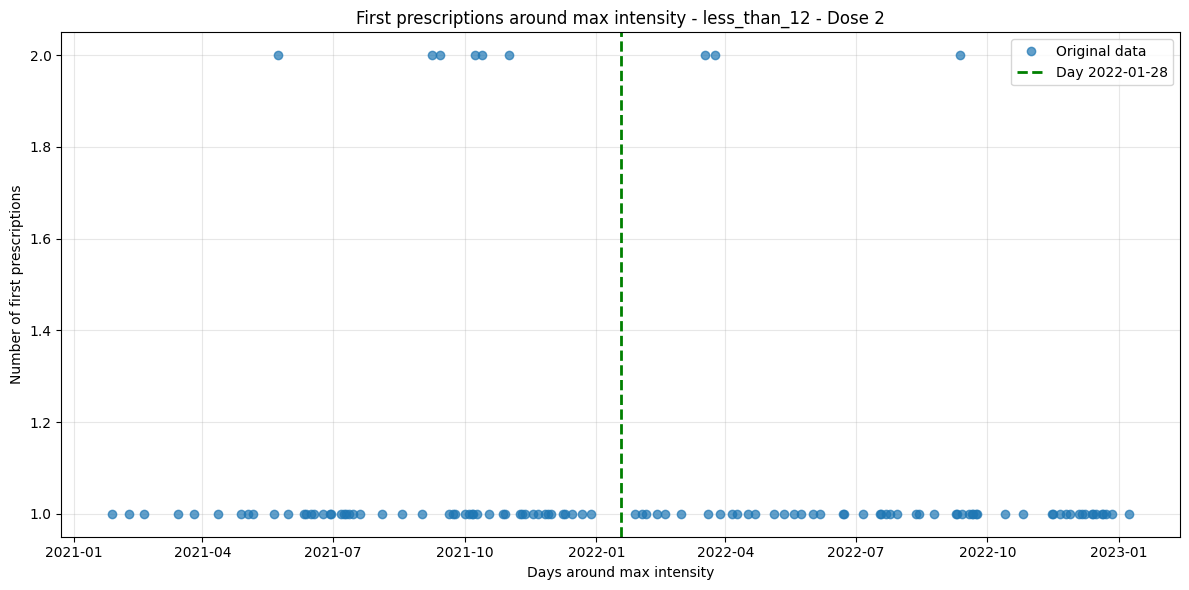

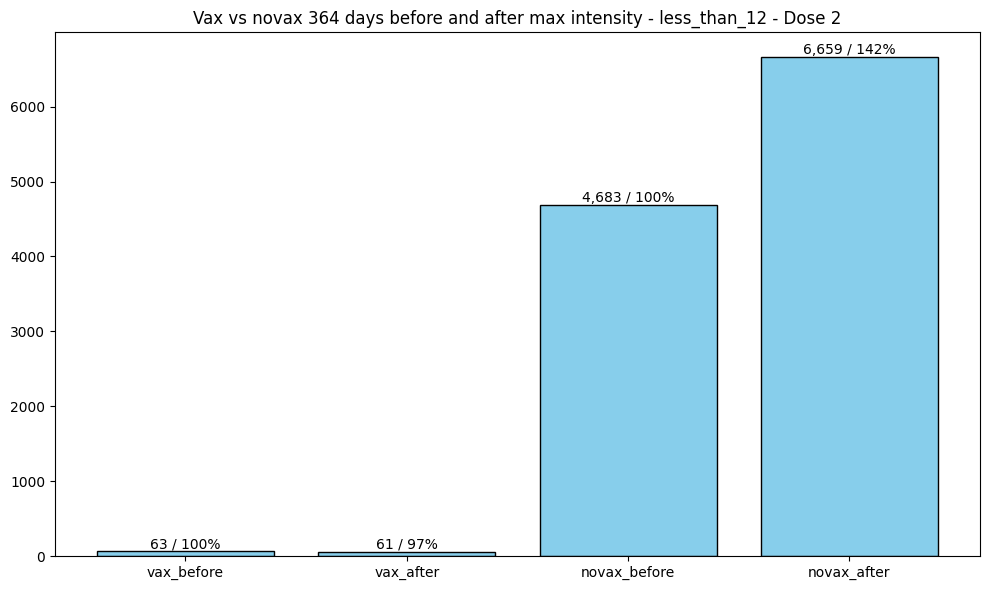

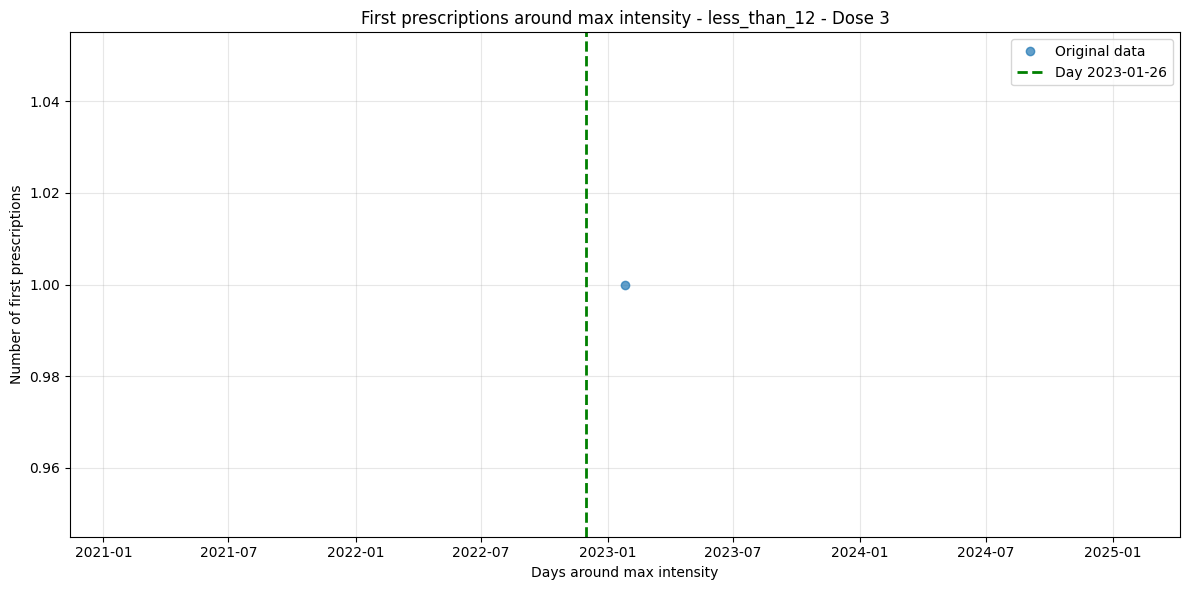

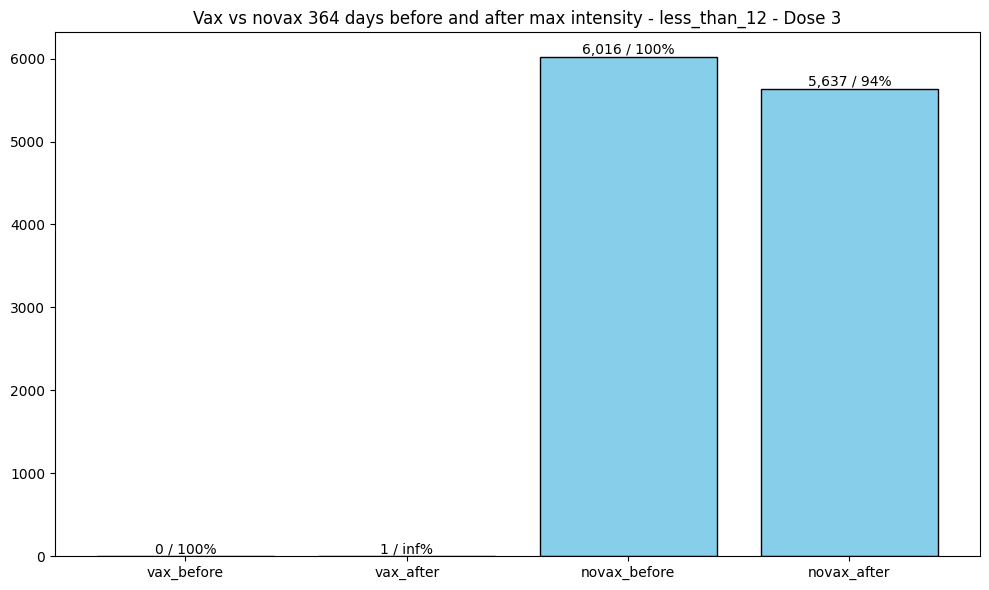

In [13]:
for age_cohort, doses_map in prvopredpisy_map.items():
    for dose_number, dates in doses_map.items():
        if not dates:
            continue

        rozhodne_datum = max_vax_dates_map[age_cohort][dose_number]
        novax_before_after_sums = get_before_after_sums(
            nov_vax_ppl_prvopredpisy_map[age_cohort],
            rozhodne_datum,
            PRESCRIPTION_PERIOD_IN_DAYS,
        )
        vax_before_after_sums = get_before_after_sums(
            dates, rozhodne_datum, PRESCRIPTION_PERIOD_IN_DAYS
        )

        obj = {
            "vax_before": vax_before_after_sums["before"],
            "vax_after": vax_before_after_sums["after"],
            "novax_before": novax_before_after_sums["before"],
            "novax_after": novax_before_after_sums["after"],
        }

        draw_chart(
            mapp=dates,
            x_label="Days around max intensity",
            y_label="Number of first prescriptions",
            title=f"First prescriptions around max intensity - {age_cohort.value} - Dose {dose_number}",
            # save_location=f"out/{POJISTOVNA}/prvopredpisy/{age_cohort.value}_dose_{dose_number}.png",
            vertical_line=rozhodne_datum,
        )
        draw_bar_chart(
            mapp=obj,
            title=f"Vax vs novax {PRESCRIPTION_PERIOD_IN_DAYS} days before and after max intensity - {age_cohort.value} - Dose {dose_number}",
            # save_location=f"out/{POJISTOVNA}/prvopredpisy/vax_vs_novax_{age_cohort.value}_dose_{dose_number}.png",
        )

In [ ]:
for age_cohort, doses_map in prednison_equivs_map.items():
    for dose_number, dates in doses_map.items():
        if not dates:
            continue

        draw_chart(
            mapp=dates,
            x_label="Days around max intensity",
            y_label="Number of prednison equivalents",
            title=f"Prednison equivalents around max intensity - {age_cohort.value} - Dose {dose_number}",
            save_location=f"out/{POJISTOVNA}/prednison_equivs/{age_cohort.value}_dose_{dose_number}.png",
            vertical_line=max_vax_dates_map[age_cohort][dose_number],
        )

✓ Chart saved: out/cpzp/prednison_equivs/between_50_and_70_dose_1.png
✓ Chart saved: out/cpzp/prednison_equivs/between_50_and_70_dose_2.png
✓ Chart saved: out/cpzp/prednison_equivs/between_50_and_70_dose_3.png
✓ Chart saved: out/cpzp/prednison_equivs/between_50_and_70_dose_4.png
✓ Chart saved: out/cpzp/prednison_equivs/between_50_and_70_dose_5.png
✓ Chart saved: out/cpzp/prednison_equivs/more_than_70_dose_4.png
✓ Chart saved: out/cpzp/prednison_equivs/more_than_70_dose_1.png
✓ Chart saved: out/cpzp/prednison_equivs/more_than_70_dose_2.png
✓ Chart saved: out/cpzp/prednison_equivs/more_than_70_dose_3.png
✓ Chart saved: out/cpzp/prednison_equivs/more_than_70_dose_5.png
✓ Chart saved: out/cpzp/prednison_equivs/more_than_70_dose_6.png
✓ Chart saved: out/cpzp/prednison_equivs/between_30_and_50_dose_1.png
✓ Chart saved: out/cpzp/prednison_equivs/between_30_and_50_dose_2.png
✓ Chart saved: out/cpzp/prednison_equivs/between_30_and_50_dose_3.png
✓ Chart saved: out/cpzp/prednison_equivs/between_3